In [8]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag, solve

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton
from config import SimulationConfig as config

In [9]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [10]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 6 * 3
H = 2 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [11]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(18)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [12]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [13]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}_ts_{int(dt)}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithm class to use
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

Windows:   0%|          | 0/394 [00:00<?, ?it/s]

[Centralized Newton] Before applying the algorithm
Cost function: 6489991.543956468
Gradient norm: 1525577.9956074522
Global estimation error: 386.2415432030463
Spectral radius of inv(T) @ R: 0.6732026695337482
T minimum eigenvalue: 2.9691790036077177
Initial conditions estimation errors: 245.6987158591327 m, 168.82575084104406 m, 244.2569388119579 m, 25.51633124937968 m
Position estimation errors: 244.98561077963686 m, 169.43007684029865 m, 243.41783811370797 m, 24.01262057112897 m

[Centralized Newton] Iteration 1
Cost function: 6.632583332954246 (-100.00%)
Gradient norm: 0.28715234387346683 (-100.00%)
Global estimation error: 2.1461641202270303 (-99.44%)
Spectral radius of inv(T) @ R: 0.6732026143790915
T minimum eigenvalue: 2.969179164016754
Initial conditions estimation errors: 0.15131438709257433 m, 1.4025698930491957 m, 1.4509835605145054 m, 0.7126550698377978 m
Position estimation errors: 0.19824562060361745 m, 0.7882443111171132 m, 0.9211474565957642 m, 0.7912573246878142 m

[

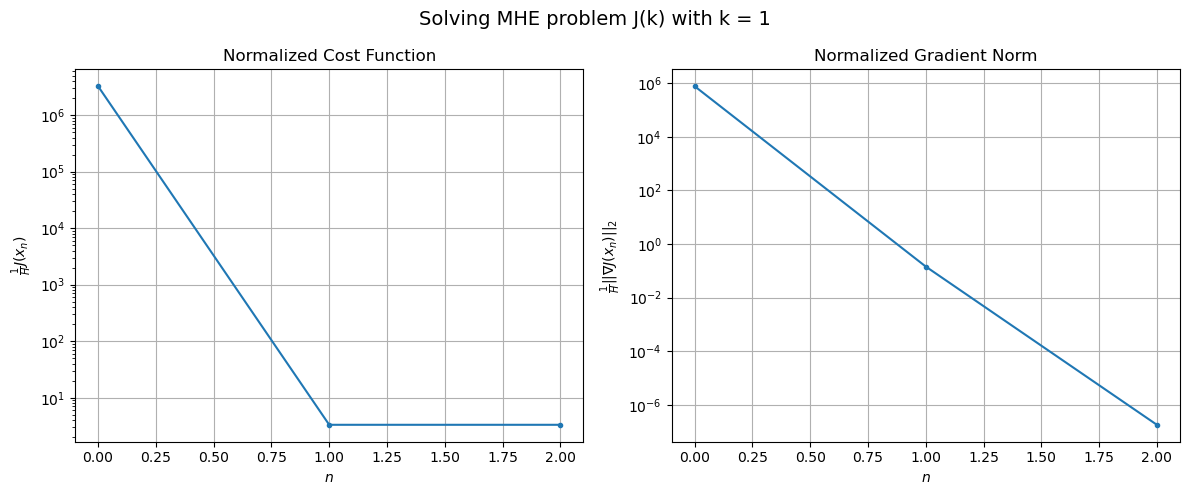

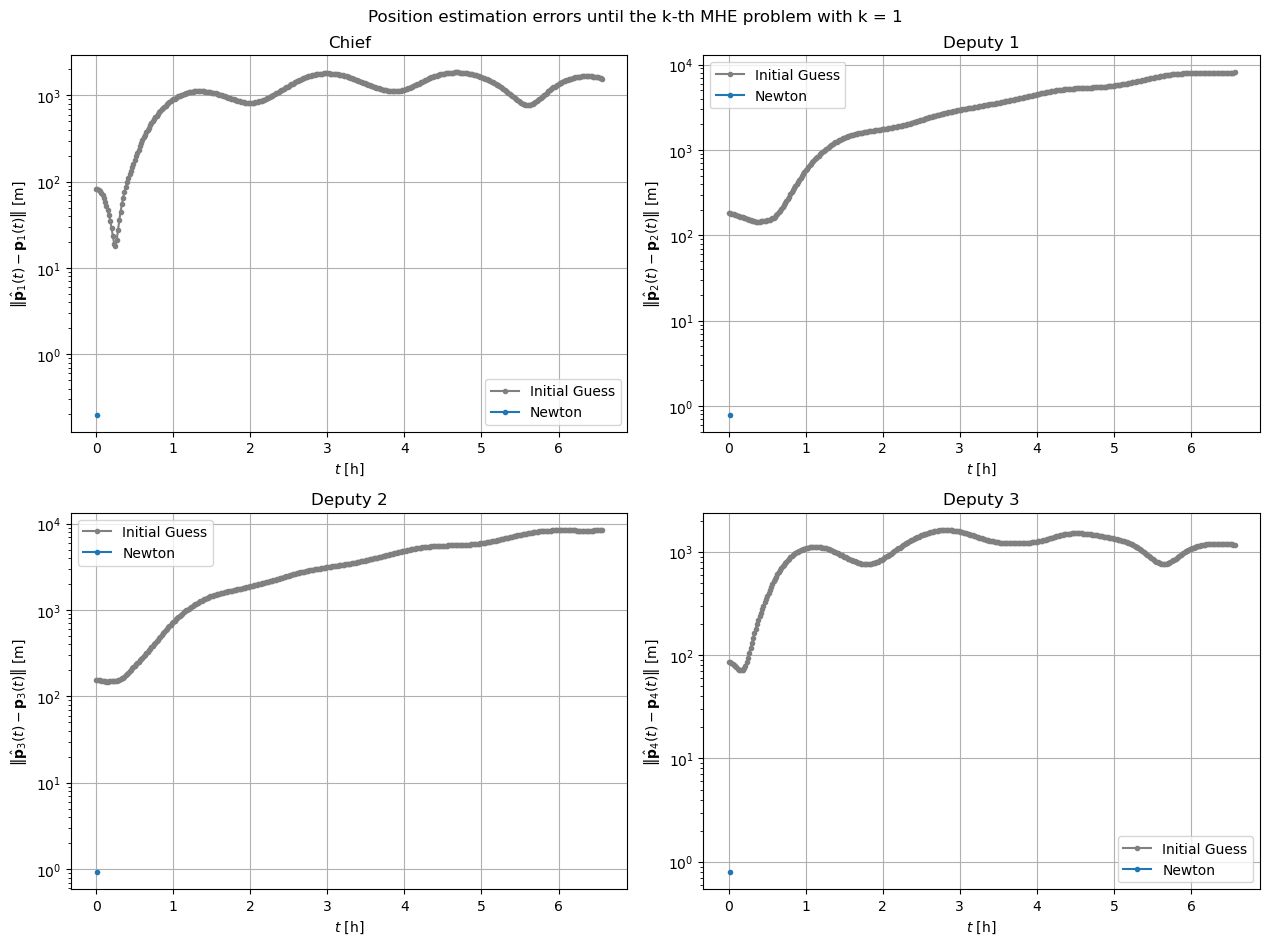

Windows:   0%|          | 1/394 [00:05<33:21,  5.09s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 203.84929515983578
Gradient norm: 10608.19085194804
Global estimation error: 1.4619608582578063
Spectral radius of inv(T) @ R: 0.673202614532479
T minimum eigenvalue: 2.969179164544529
Initial conditions estimation errors: 0.19825477313859943 m, 0.7882438095439309 m, 0.9210810203242552 m, 0.7912601199876227 m
Position estimation errors: 1.8494910426254862 m, 3.2301736317518315 m, 2.006368239012321 m, 2.0411702632116966 m
Iteration 0.0
Newton direction error: 0.04861066236615677 in 0.10128406581597775
Iteration 0.1
Newton direction error: 0.029323011105688197 in 0.10128406581597775
Iteration 0.2
Newton direction error: 0.01913707557797714 in 0.10128406581597775

[Centralized Newton] Iteration 1
Cost function: 8.129597017577815 (-96.01%)
Gradient norm: 77.24267681923929 (-99.27%)
Global estimation error: 1.4621585103393153 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144526237
T minimum eigenvalue: 2.969179165021782
Ini

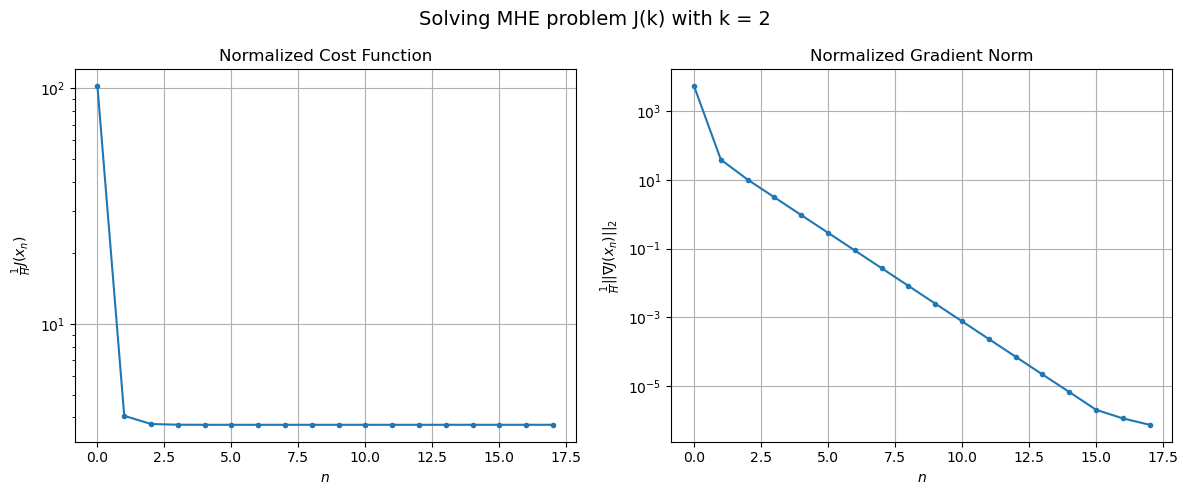

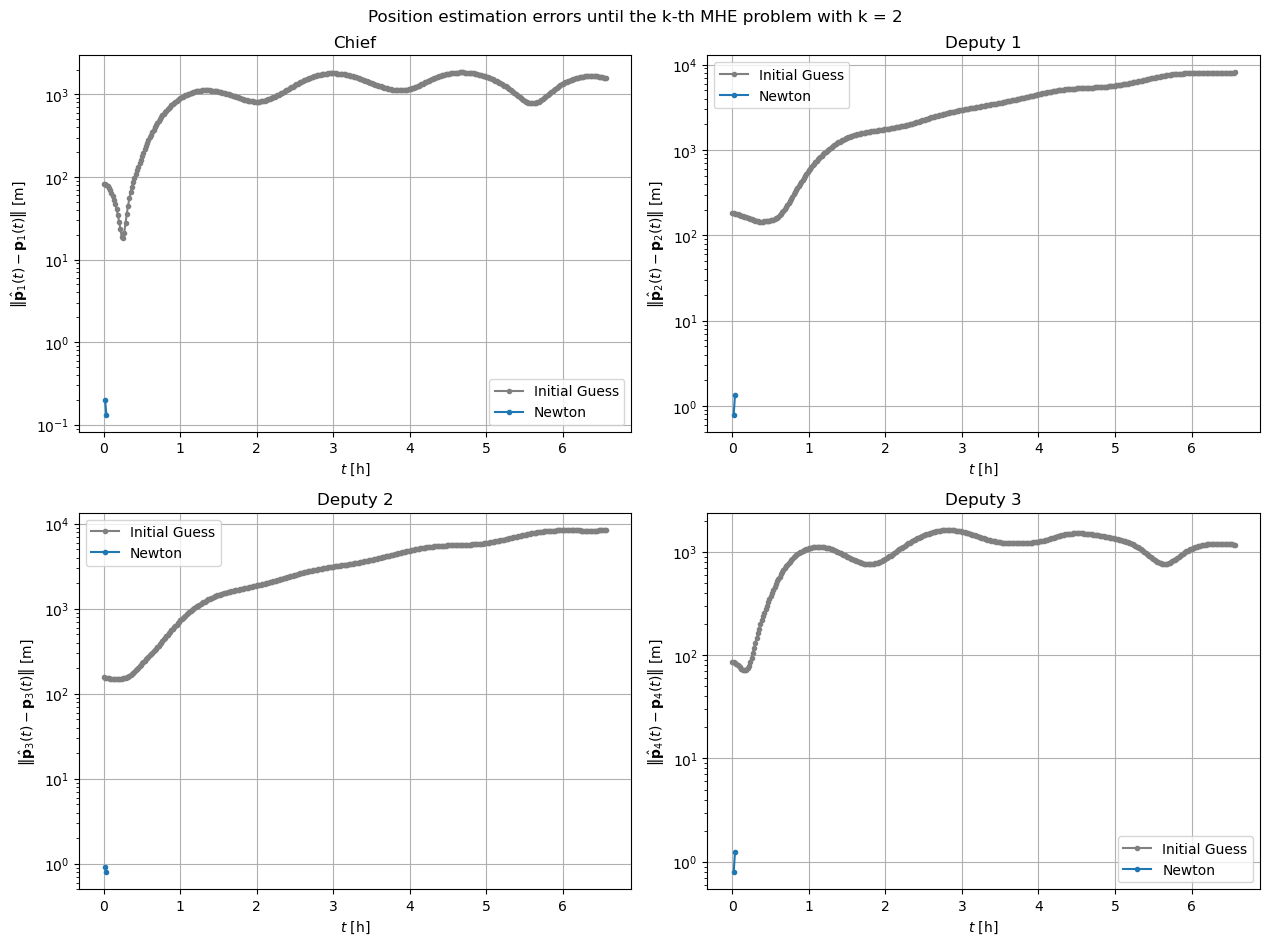

Windows:   1%|          | 2/394 [00:16<59:03,  9.04s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 176.9731228250326
Gradient norm: 10391.668799413725
Global estimation error: 1.9924164666963442
Spectral radius of inv(T) @ R: 0.6732026146824199
T minimum eigenvalue: 2.9691791649703903
Initial conditions estimation errors: 0.13203723283357724 m, 1.3397332389864118 m, 0.7946759493227039 m, 1.234350980151206 m
Position estimation errors: 1.6080721298560359 m, 3.542453150067842 m, 1.5863813800127982 m, 2.5803546797563572 m
Iteration 0.0
Newton direction error: 0.03963509807091127 in 0.07968299013100971
Iteration 0.1
Newton direction error: 0.024628026600453348 in 0.07968299013100971
Iteration 0.2
Newton direction error: 0.01622258424116747 in 0.07968299013100971

[Centralized Newton] Iteration 1
Cost function: 8.271401104813856 (-95.33%)
Gradient norm: 62.88390707303458 (-99.39%)
Global estimation error: 1.9920631152602954 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144388686
T minimum eigenvalue: 2.969179165804311
I

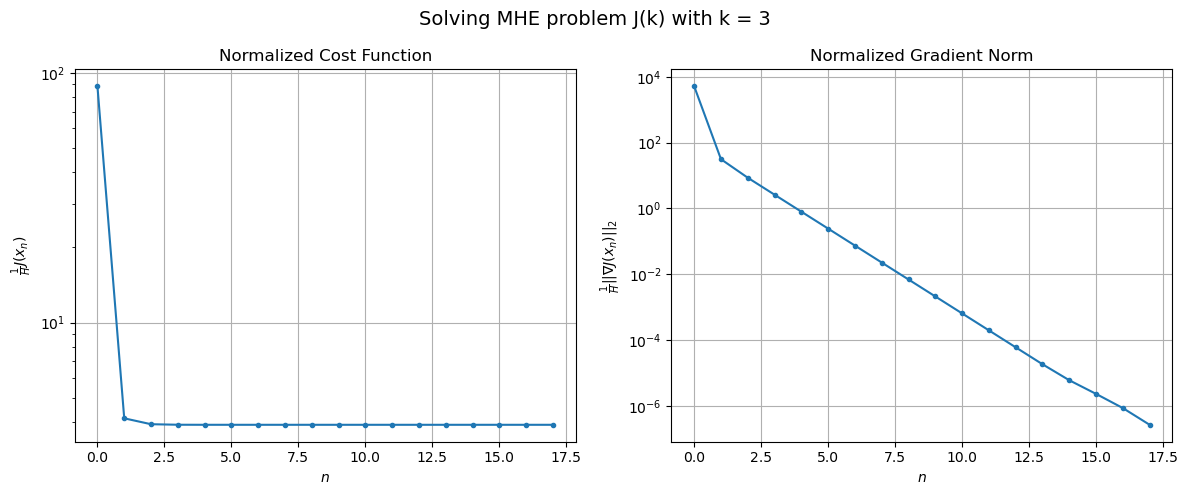

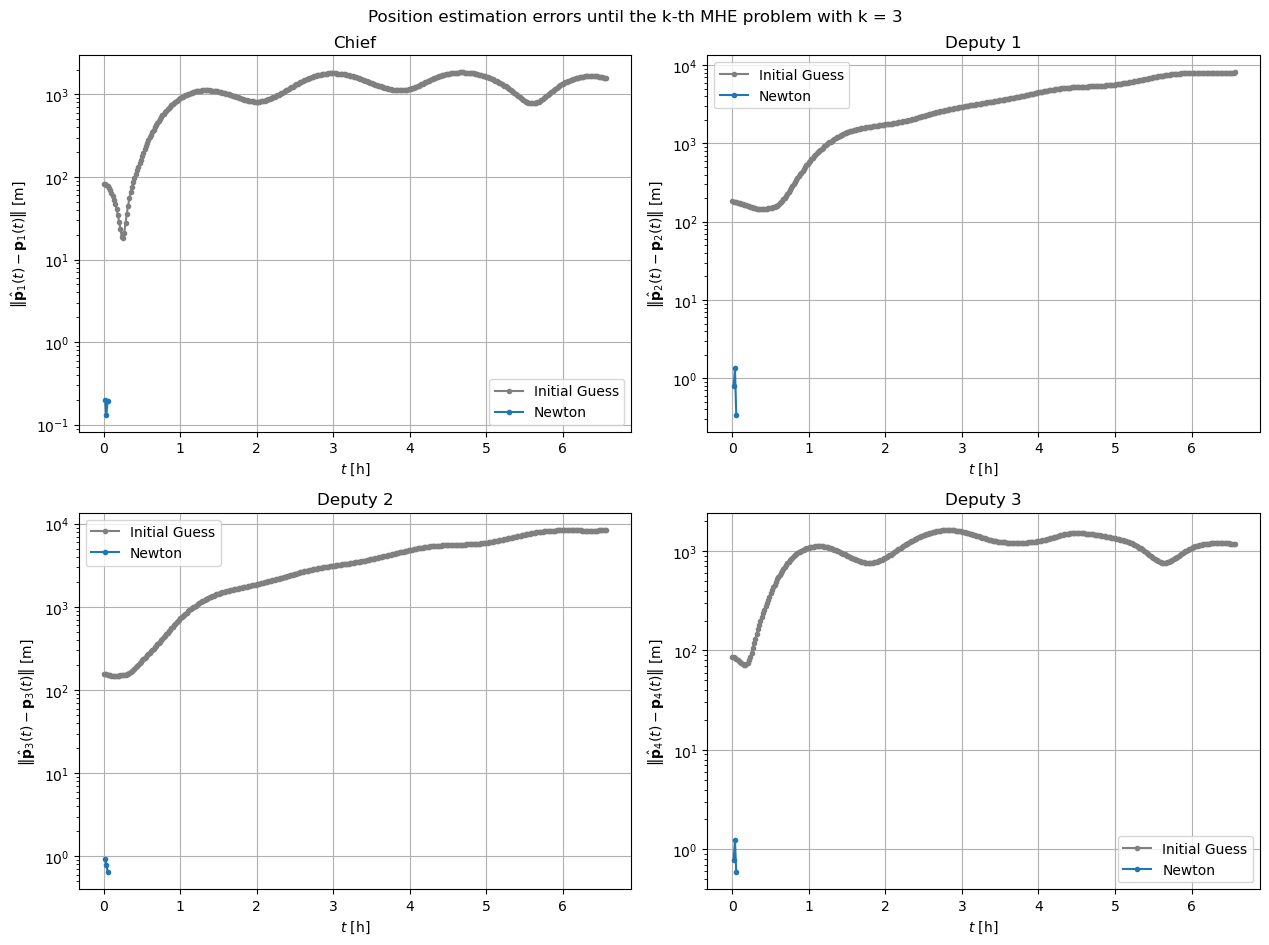

Windows:   1%|          | 3/394 [00:28<1:07:34, 10.37s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 110.87191492468321
Gradient norm: 8221.800232927717
Global estimation error: 0.9572002203882787
Spectral radius of inv(T) @ R: 0.6732026146973684
T minimum eigenvalue: 2.9691791660902034
Initial conditions estimation errors: 0.1936861316956872 m, 0.34168700068978486 m, 0.6435578322335297 m, 0.5882136969669884 m
Position estimation errors: 1.3849943490258532 m, 2.0468535280731053 m, 2.1271122109505796 m, 1.4472706084128377 m
Iteration 0.0
Newton direction error: 0.03566323590262199 in 0.06033211455704321
Iteration 0.1
Newton direction error: 0.02364353687923296 in 0.06033211455704321
Iteration 0.2
Newton direction error: 0.015856059178535765 in 0.06033211455704321

[Centralized Newton] Iteration 1
Cost function: 12.57060583342069 (-88.66%)
Gradient norm: 56.45423068219732 (-99.31%)
Global estimation error: 0.9566124628102426 (-0.06%)
Spectral radius of inv(T) @ R: 0.6732026144382706
T minimum eigenvalue: 2.969179166874292

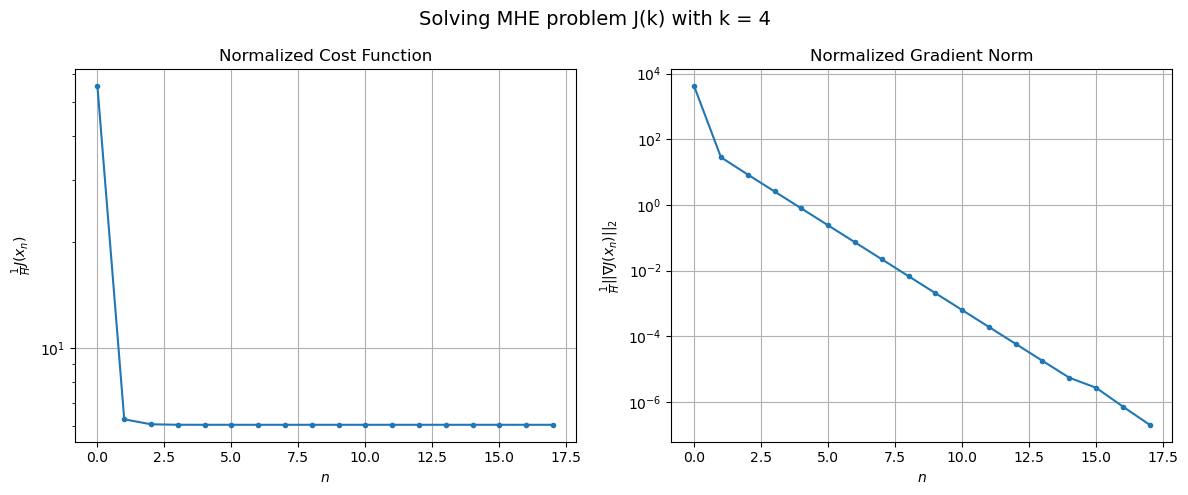

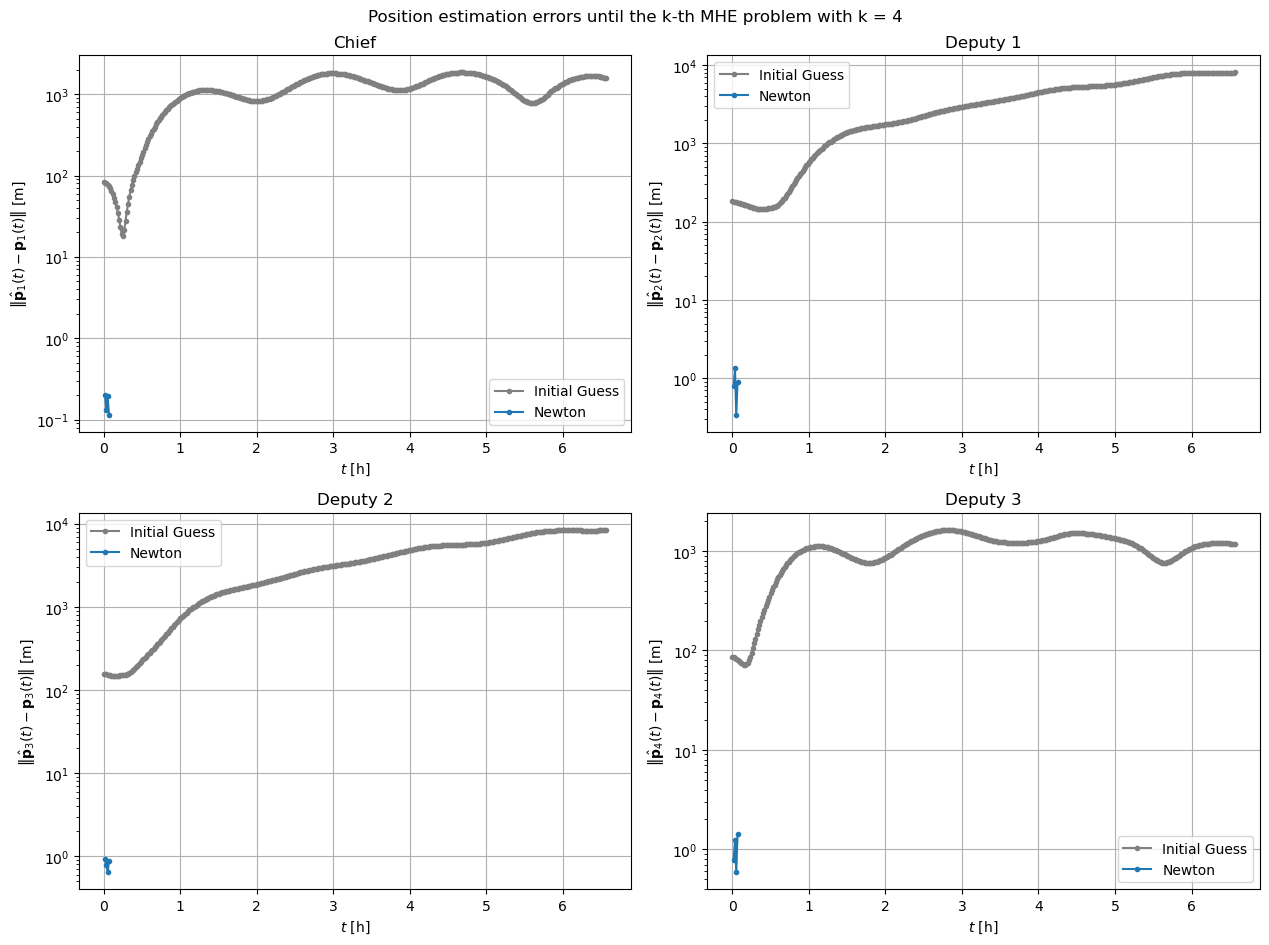

Windows:   1%|          | 4/394 [00:40<1:11:14, 10.96s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 126.97299054675726
Gradient norm: 8217.16966742045
Global estimation error: 1.9027740158710635
Spectral radius of inv(T) @ R: 0.6732026147047468
T minimum eigenvalue: 2.9691791699035863
Initial conditions estimation errors: 0.11453321459337132 m, 0.8857043605001776 m, 0.883943903117583 m, 1.4278511690421651 m
Position estimation errors: 1.4679749347296682 m, 2.7248560789002187 m, 3.092900497537257 m, 3.7711096073198775 m
Iteration 0.0
Newton direction error: 0.06870093597639 in 0.10796606767901325
Iteration 0.1
Newton direction error: 0.04585769329658665 in 0.10796606767901325
Iteration 0.2
Newton direction error: 0.030806478193578013 in 0.10796606767901325

[Centralized Newton] Iteration 1
Cost function: 13.553140365657304 (-89.33%)
Gradient norm: 109.00479356352679 (-98.67%)
Global estimation error: 1.9023607046476527 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144999114
T minimum eigenvalue: 2.9691791691636773
In

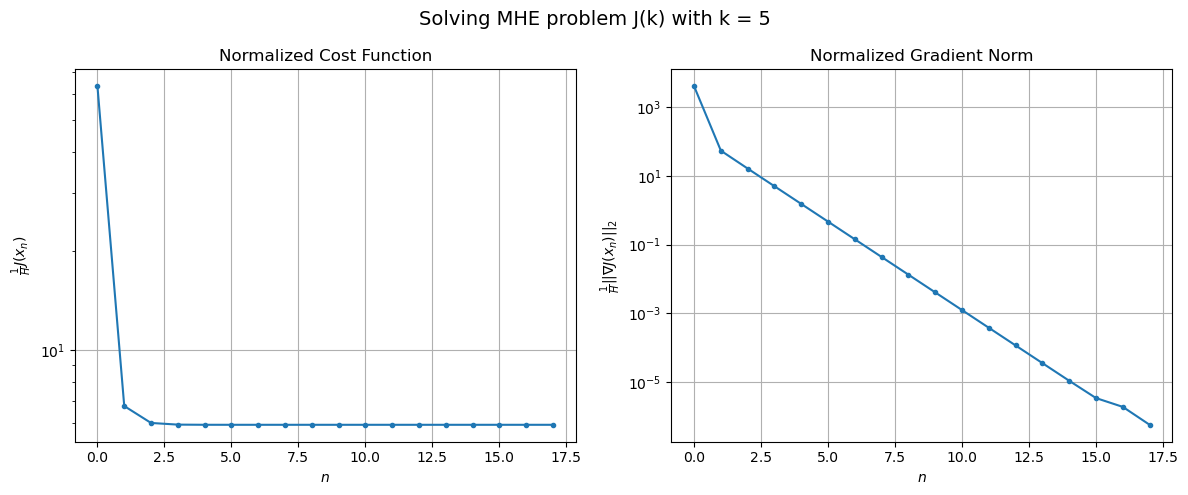

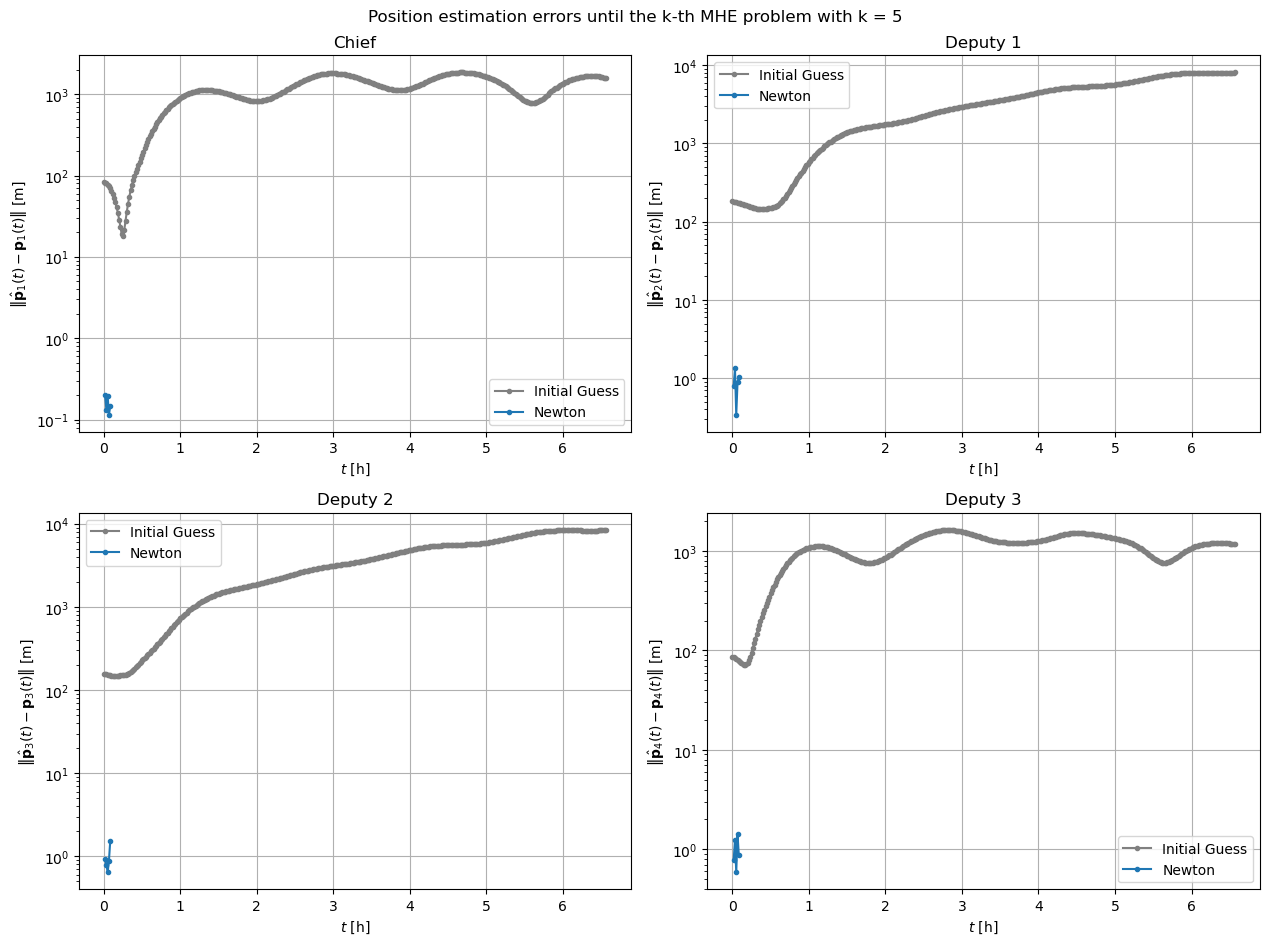

Windows:   1%|▏         | 5/394 [00:52<1:13:16, 11.30s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 92.93325617997498
Gradient norm: 6980.255762112068
Global estimation error: 2.03901348459969
Spectral radius of inv(T) @ R: 0.6732026147140114
T minimum eigenvalue: 2.9691791699188315
Initial conditions estimation errors: 0.14505959314647807 m, 1.0402093221169888 m, 1.5144607331976612 m, 0.8707758246171695 m
Position estimation errors: 1.1891334834870644 m, 2.992923103013893 m, 3.3115755524623096 m, 2.3283946888360982 m
Iteration 0.0
Newton direction error: 0.05491064405478294 in 0.09143974965547785
Iteration 0.1
Newton direction error: 0.03603623934250003 in 0.09143974965547785
Iteration 0.2
Newton direction error: 0.0241037558288267 in 0.09143974965547785

[Centralized Newton] Iteration 1
Cost function: 5.326769270653449 (-94.27%)
Gradient norm: 86.95867850940922 (-98.75%)
Global estimation error: 2.0386790096197402 (-0.02%)
Spectral radius of inv(T) @ R: 0.673202614468798
T minimum eigenvalue: 2.9691791704118713
Initi

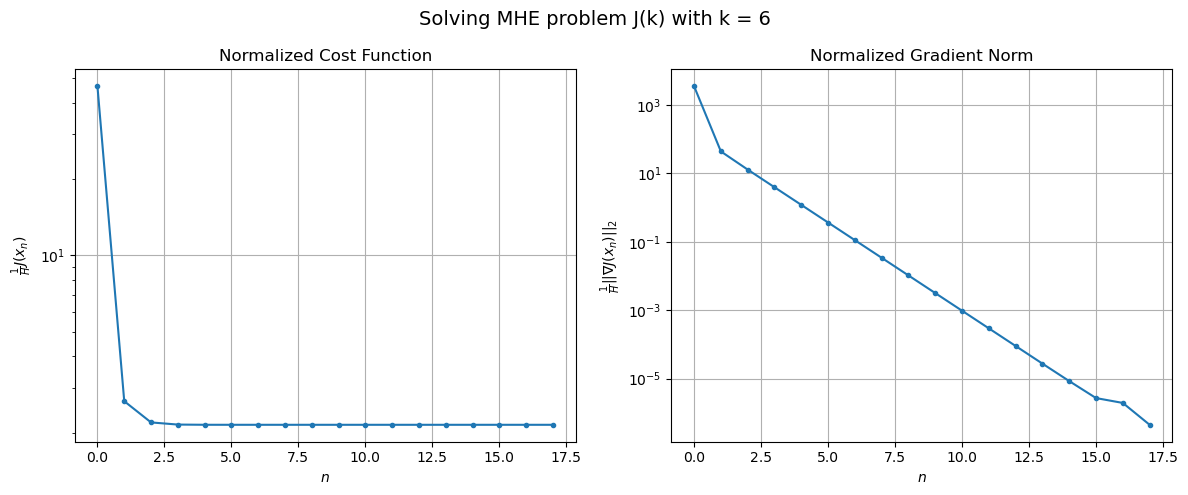

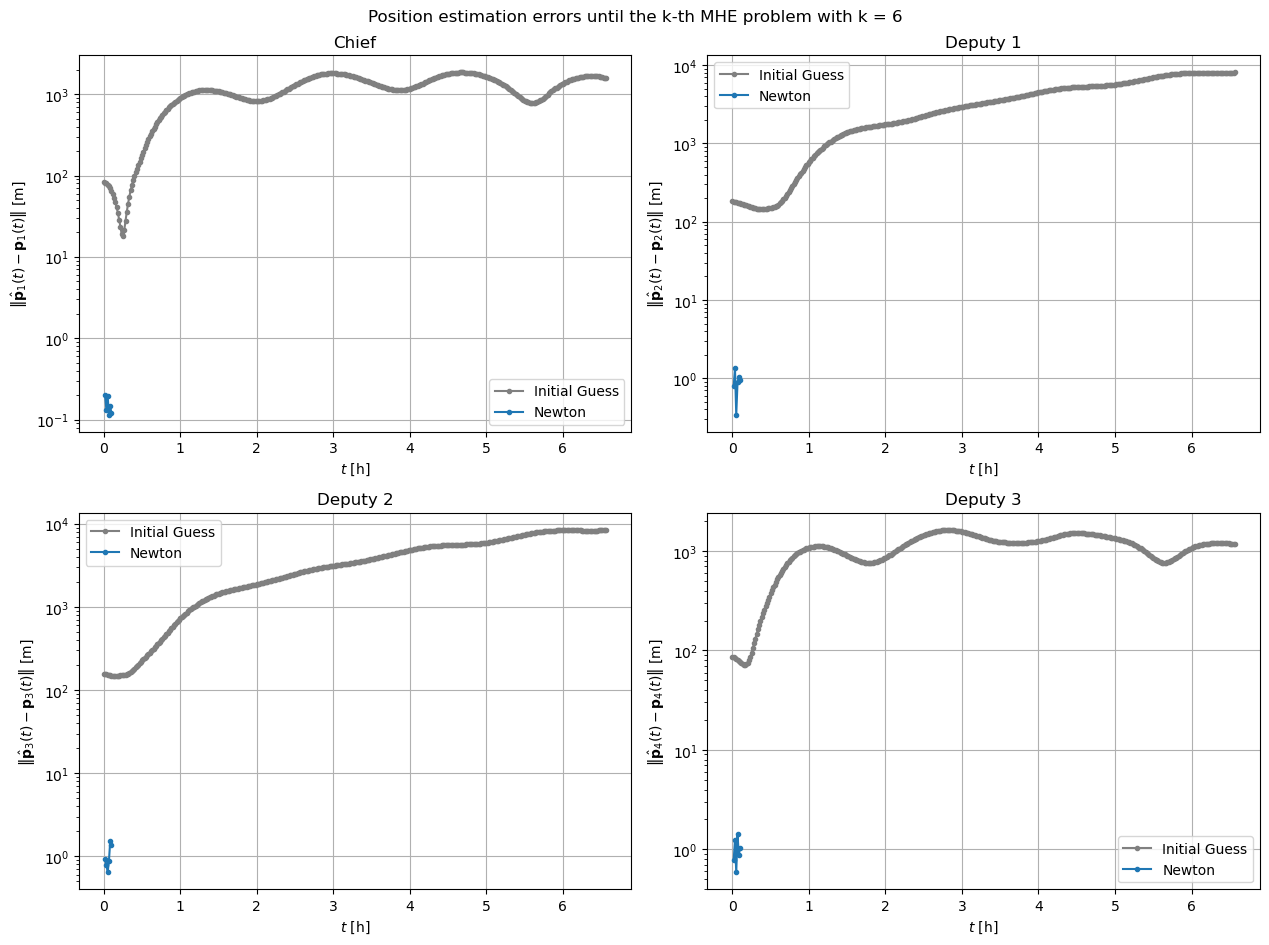

Windows:   2%|▏         | 6/394 [01:04<1:14:19, 11.49s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 90.89032524388699
Gradient norm: 6753.721392057341
Global estimation error: 1.9649991914327163
Spectral radius of inv(T) @ R: 0.6732026148187394
T minimum eigenvalue: 2.9691791709172937
Initial conditions estimation errors: 0.11914568609754445 m, 0.9564530263284757 m, 1.3602408900329443 m, 1.0395875839802817 m
Position estimation errors: 1.0328531168342474 m, 2.0906724699854475 m, 1.2801730008373344 m, 1.8166903819211397 m
Iteration 0.0
Newton direction error: 0.03706111626722779 in 0.07469619181445894
Iteration 0.1
Newton direction error: 0.022571614433076048 in 0.07469619181445894
Iteration 0.2
Newton direction error: 0.014776329912270084 in 0.07469619181445894

[Centralized Newton] Iteration 1
Cost function: 5.367964927593318 (-94.09%)
Gradient norm: 58.79649105436157 (-99.13%)
Global estimation error: 1.9651301124608223 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144568551
T minimum eigenvalue: 2.969179172024795


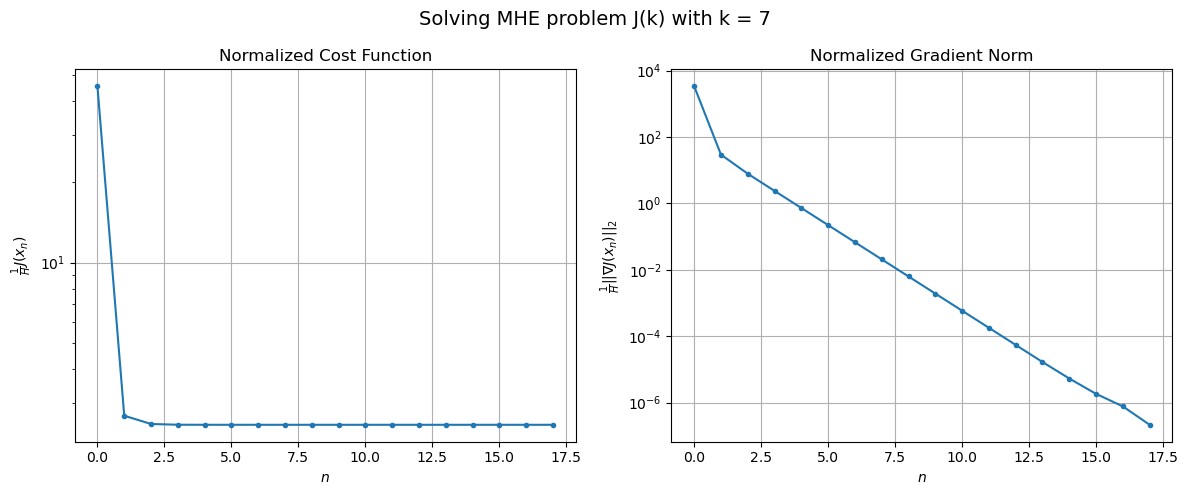

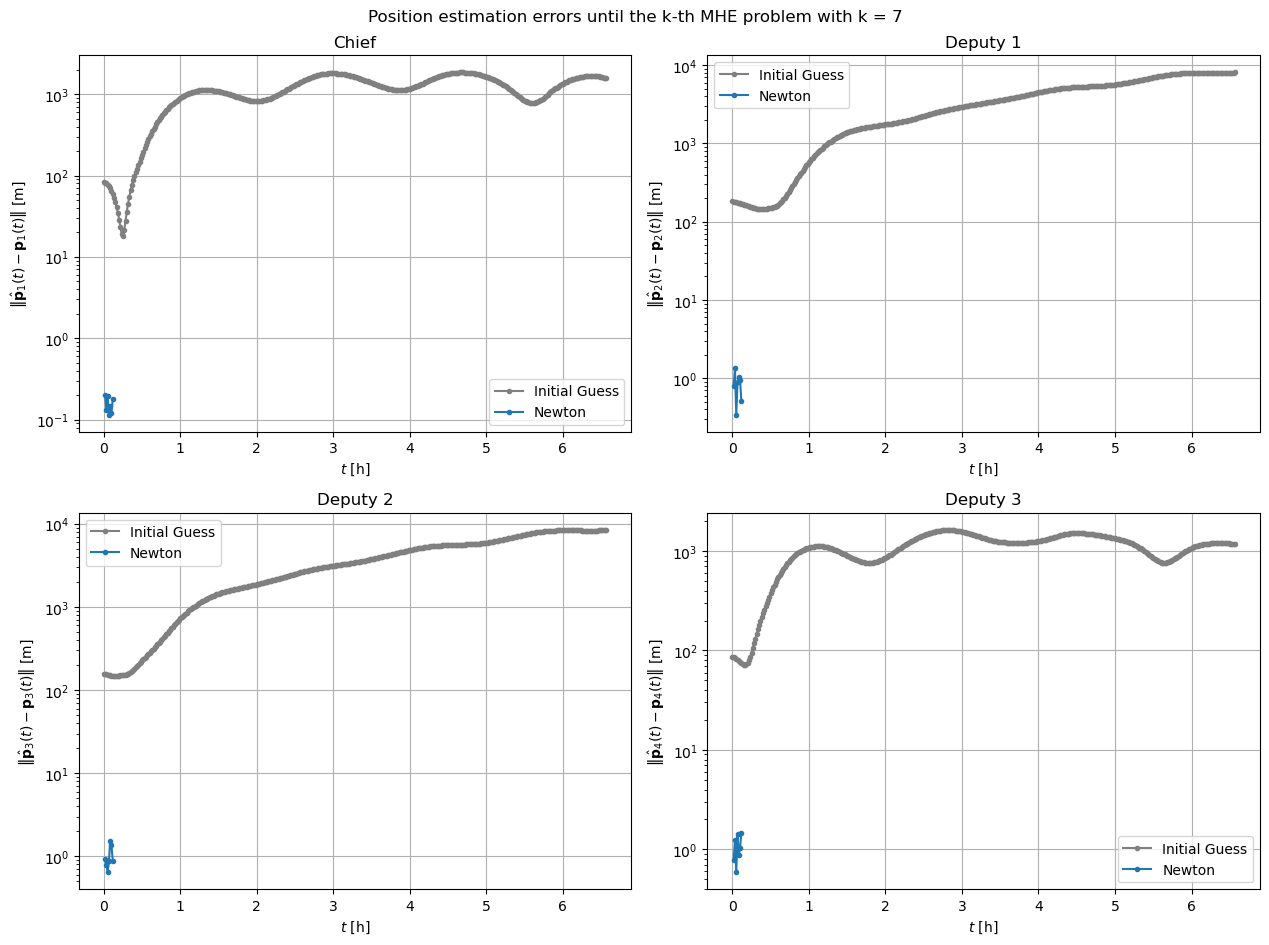

Windows:   2%|▏         | 7/394 [01:16<1:14:53, 11.61s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 98.39239959366748
Gradient norm: 4964.148163804771
Global estimation error: 1.7922787252747132
Spectral radius of inv(T) @ R: 0.6732026147779869
T minimum eigenvalue: 2.969179176532283
Initial conditions estimation errors: 0.17965401770202263 m, 0.5140047878267365 m, 0.8803692979089508 m, 1.461943862078729 m
Position estimation errors: 0.7913834179245822 m, 1.1925630547517847 m, 2.7390656476369912 m, 4.472193854636913 m
Iteration 0.0
Newton direction error: 0.08504350103738548 in 0.14028362473453426
Iteration 0.1
Newton direction error: 0.0556851597849422 in 0.14028362473453426
Iteration 0.2
Newton direction error: 0.037224307481367326 in 0.14028362473453426

[Centralized Newton] Iteration 1
Cost function: 9.808234680502736 (-90.03%)
Gradient norm: 134.90411123340684 (-97.28%)
Global estimation error: 1.7922697179267222 (-0.00%)
Spectral radius of inv(T) @ R: 0.6732026145208271
T minimum eigenvalue: 2.969179175323184
Ini

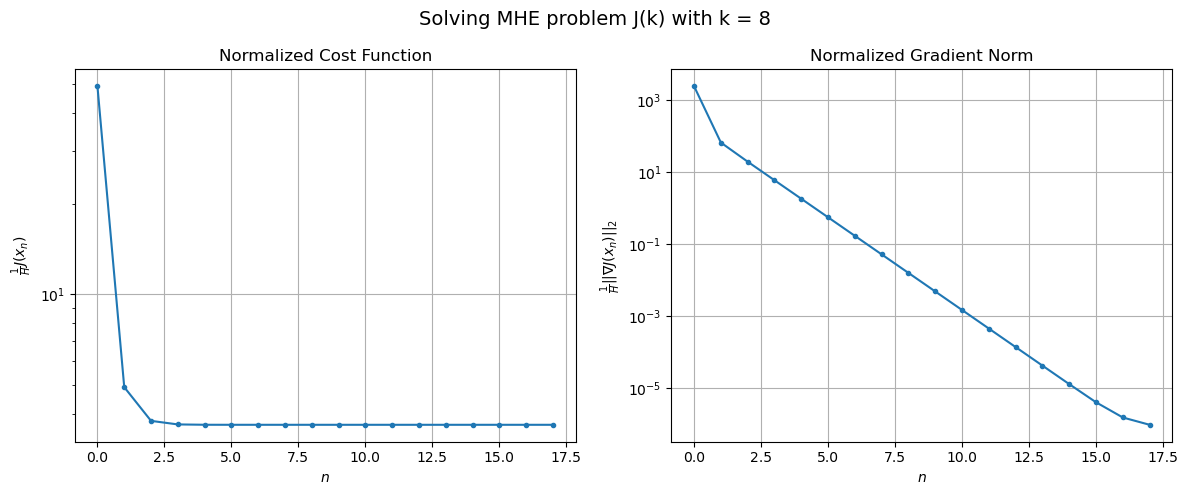

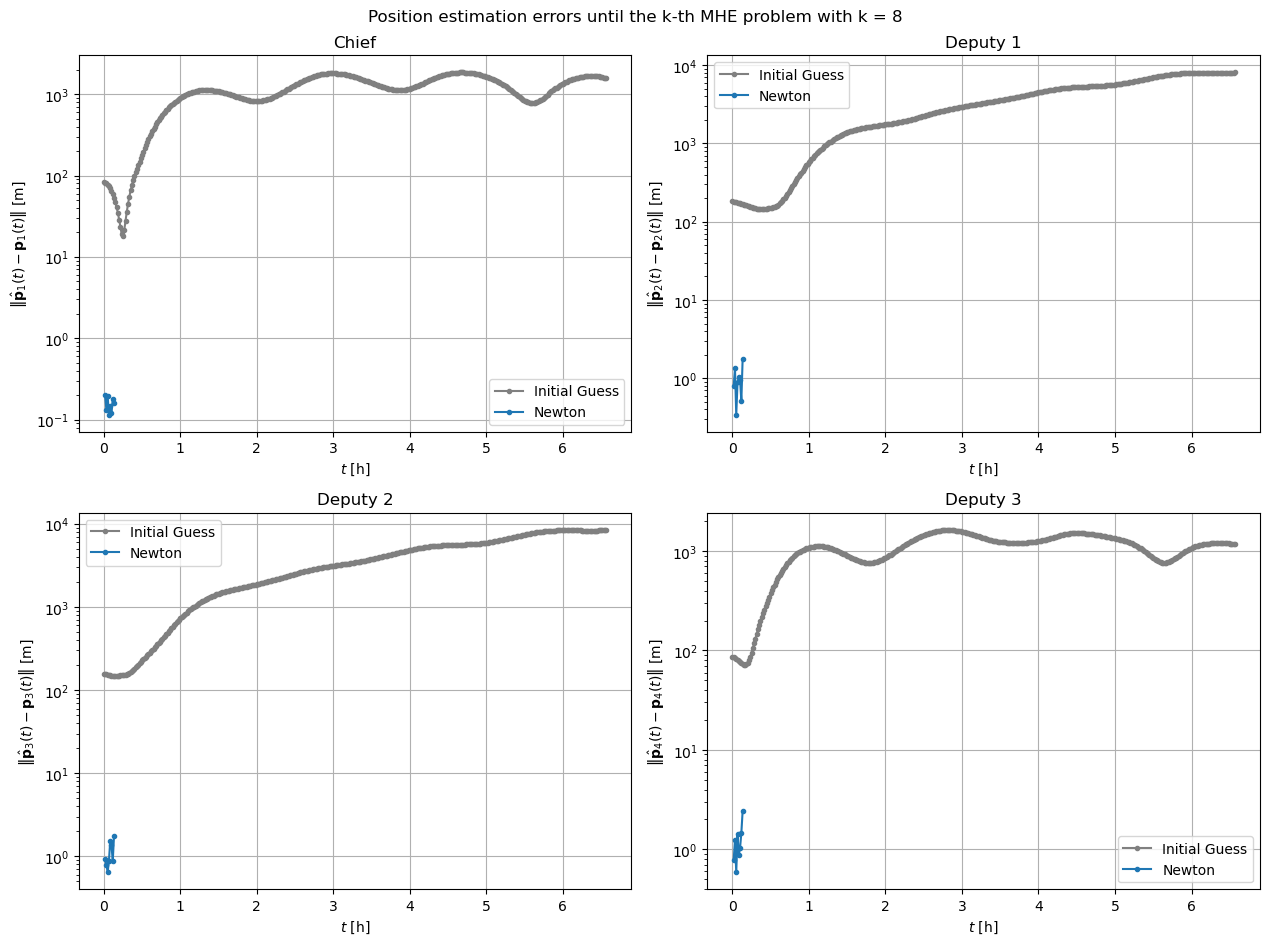

Windows:   2%|▏         | 8/394 [01:28<1:15:13, 11.69s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 83.99091670759611
Gradient norm: 3787.0766647769574
Global estimation error: 3.4810297222681212
Spectral radius of inv(T) @ R: 0.6732026151527436
T minimum eigenvalue: 2.96917917465623
Initial conditions estimation errors: 0.15891962304105597 m, 1.7425473295189728 m, 1.7810468876649113 m, 2.4245499307728715 m
Position estimation errors: 0.5893344692235614 m, 2.3973448169438956 m, 3.8236957385848442 m, 5.813345674711755 m
Iteration 0.0
Newton direction error: 0.08145534117287069 in 0.1345936148836545
Iteration 0.1
Newton direction error: 0.0532535114531382 in 0.1345936148836545
Iteration 0.2
Newton direction error: 0.0355843542153648 in 0.1345936148836545

[Centralized Newton] Iteration 1
Cost function: 12.362050256658641 (-85.28%)
Gradient norm: 129.12877227217894 (-96.59%)
Global estimation error: 3.4805540888294155 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026145949808
T minimum eigenvalue: 2.96917917634275
Initial

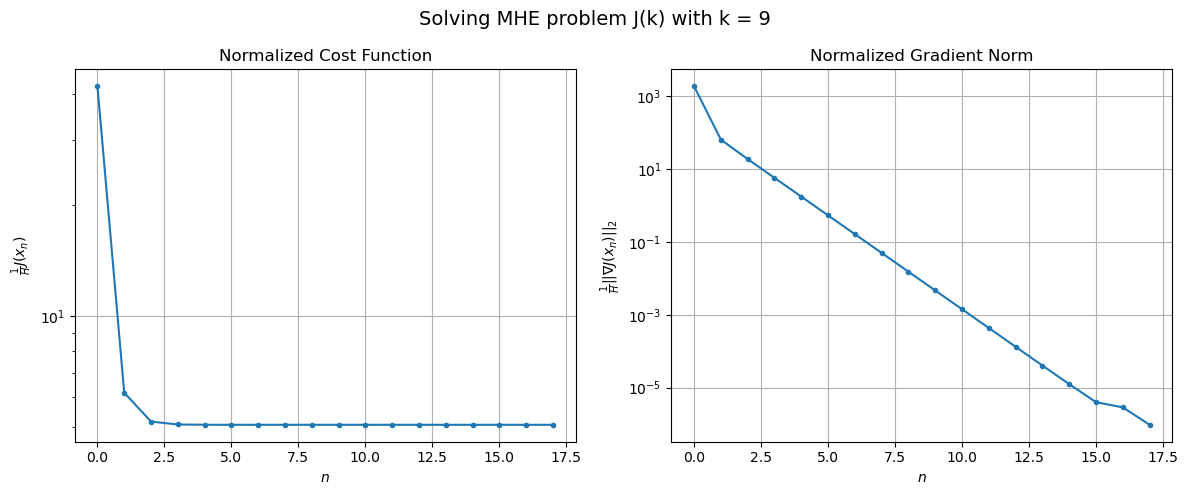

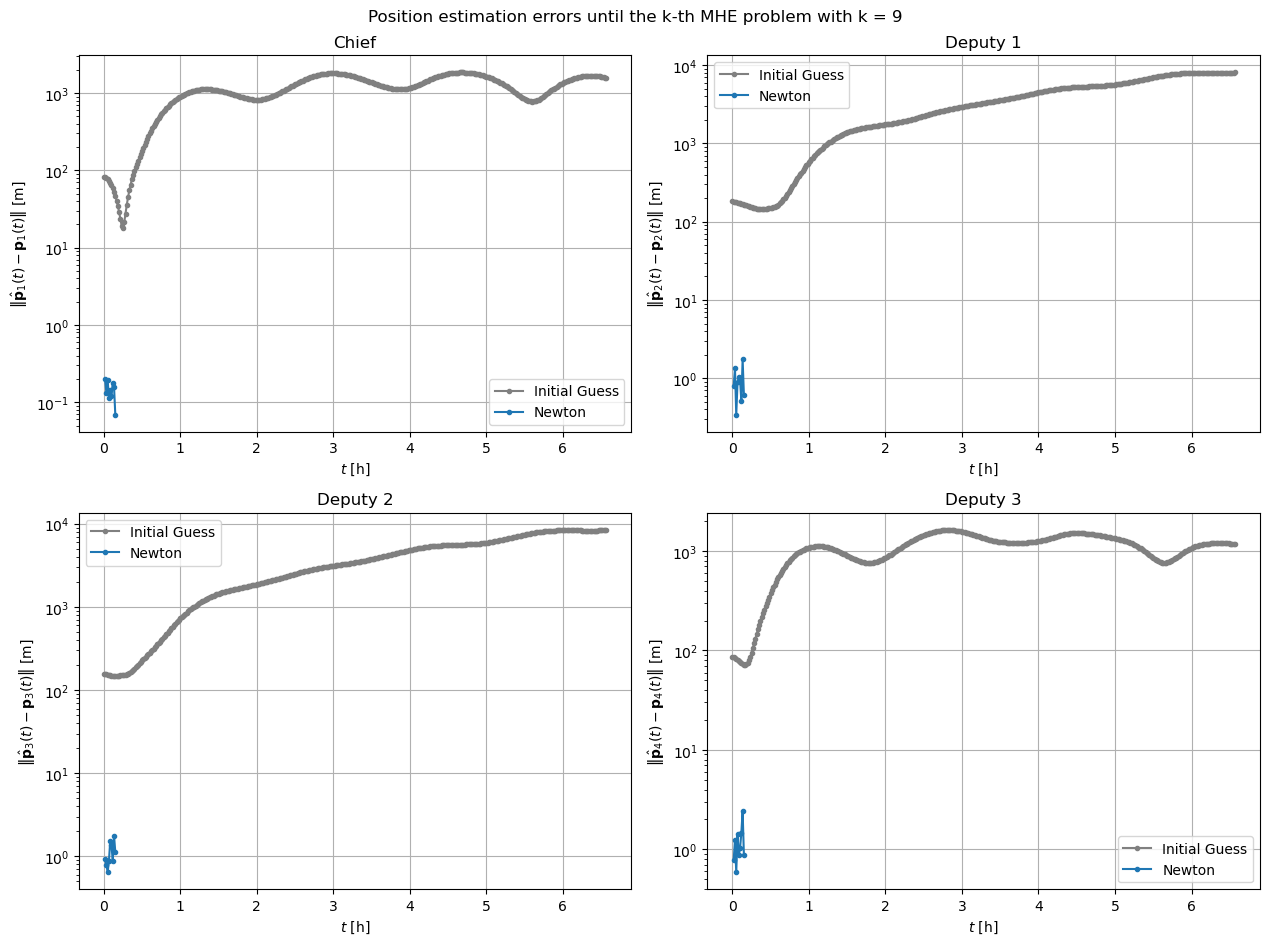

Windows:   2%|▏         | 9/394 [01:40<1:15:28, 11.76s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 62.93574508791865
Gradient norm: 3567.347391120817
Global estimation error: 1.5536992427905398
Spectral radius of inv(T) @ R: 0.6732026146120087
T minimum eigenvalue: 2.9691791813966275
Initial conditions estimation errors: 0.06881236221422249 m, 0.6129141078759343 m, 1.1234790459398512 m, 0.8749962954312936 m
Position estimation errors: 0.6210238600467977 m, 3.227642654754452 m, 3.550221032047511 m, 3.194925616549984 m
Iteration 0.0
Newton direction error: 0.0531608908334774 in 0.09492830037122071
Iteration 0.1
Newton direction error: 0.03385990424254936 in 0.09492830037122071
Iteration 0.2
Newton direction error: 0.022464896129114977 in 0.09492830037122071

[Centralized Newton] Iteration 1
Cost function: 12.955389506965851 (-79.41%)
Gradient norm: 84.49739528609943 (-97.63%)
Global estimation error: 1.552490629352543 (-0.08%)
Spectral radius of inv(T) @ R: 0.6732026144699059
T minimum eigenvalue: 2.9691791803316736
Ini

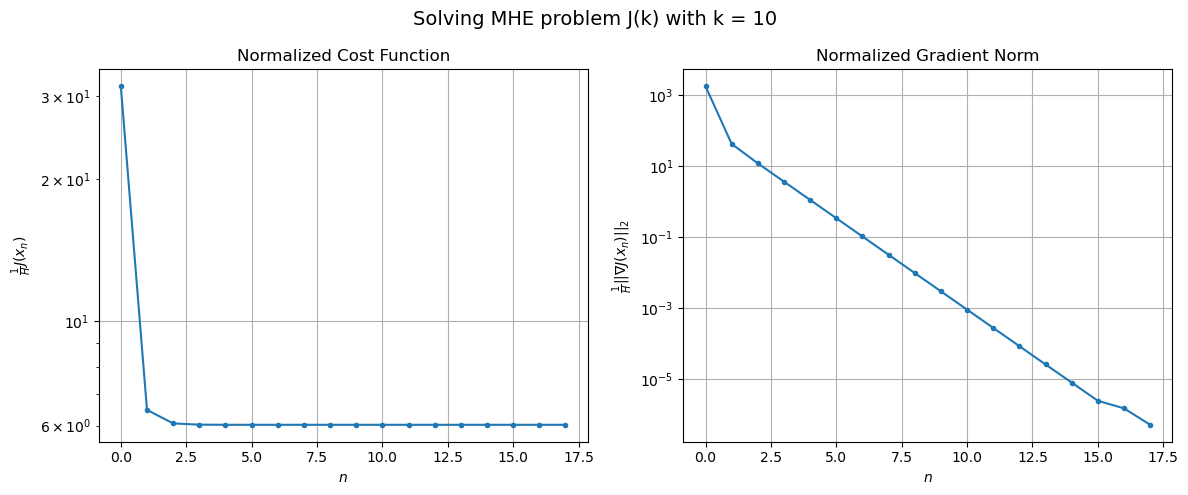

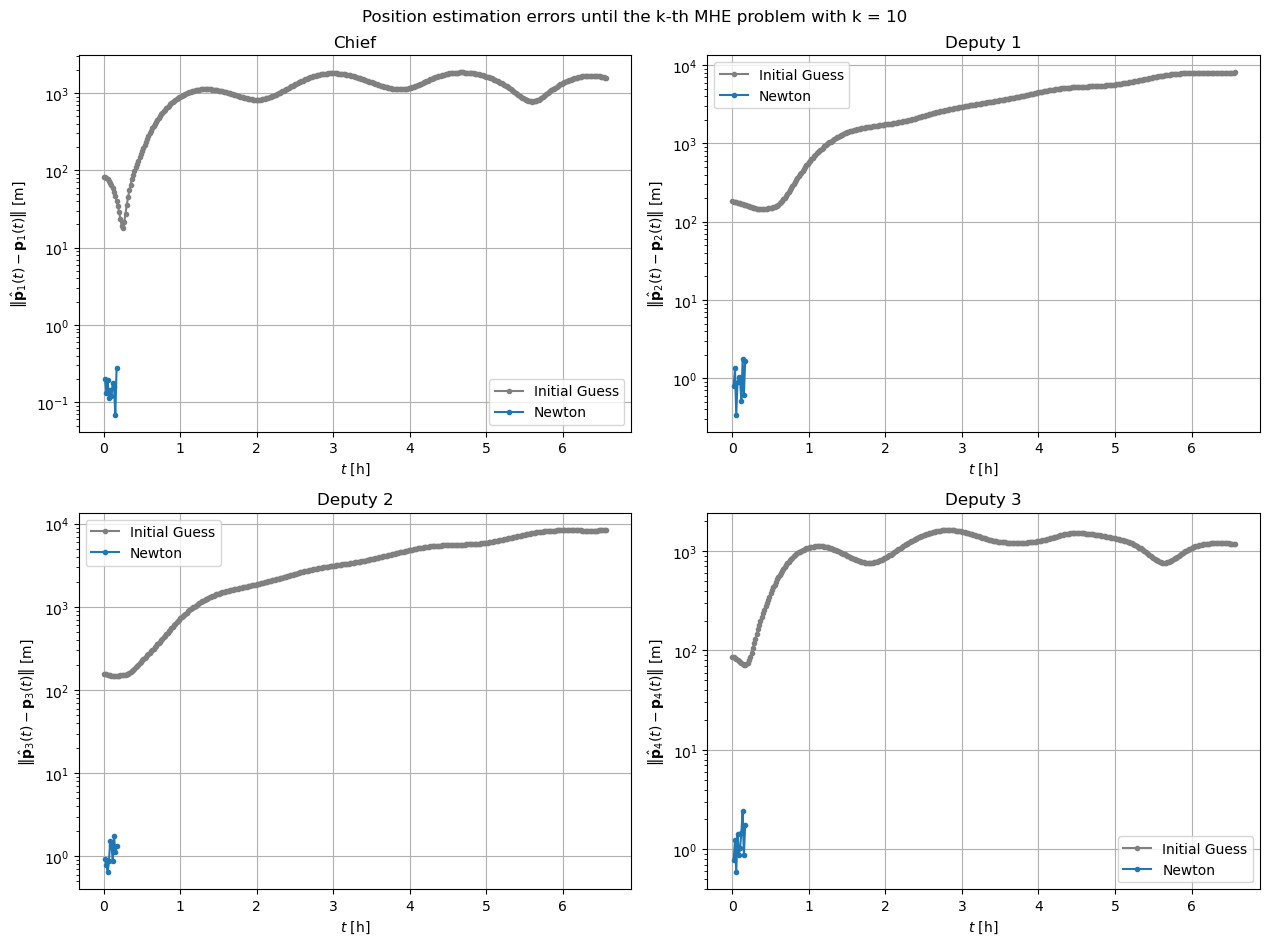

Windows:   3%|▎         | 10/394 [01:52<1:15:42, 11.83s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 60.79219692903769
Gradient norm: 4577.205796910775
Global estimation error: 2.785192876069286
Spectral radius of inv(T) @ R: 0.6732026147128248
T minimum eigenvalue: 2.9691791819005857
Initial conditions estimation errors: 0.2806780460541347 m, 1.648177351495105 m, 1.344382411373219 m, 1.7756573815798877 m
Position estimation errors: 0.6824679146638721 m, 2.663565326324517 m, 1.2606966571112102 m, 3.719510787518603 m
Iteration 0.0
Newton direction error: 0.05527711816804849 in 0.08778283632272783
Iteration 0.1
Newton direction error: 0.03667045735212277 in 0.08778283632272783
Iteration 0.2
Newton direction error: 0.024596324796888218 in 0.08778283632272783

[Centralized Newton] Iteration 1
Cost function: 15.083766096592015 (-75.19%)
Gradient norm: 87.47245737631201 (-98.09%)
Global estimation error: 2.7851465302822405 (-0.00%)
Spectral radius of inv(T) @ R: 0.6732026144826406
T minimum eigenvalue: 2.9691791824320695
Init

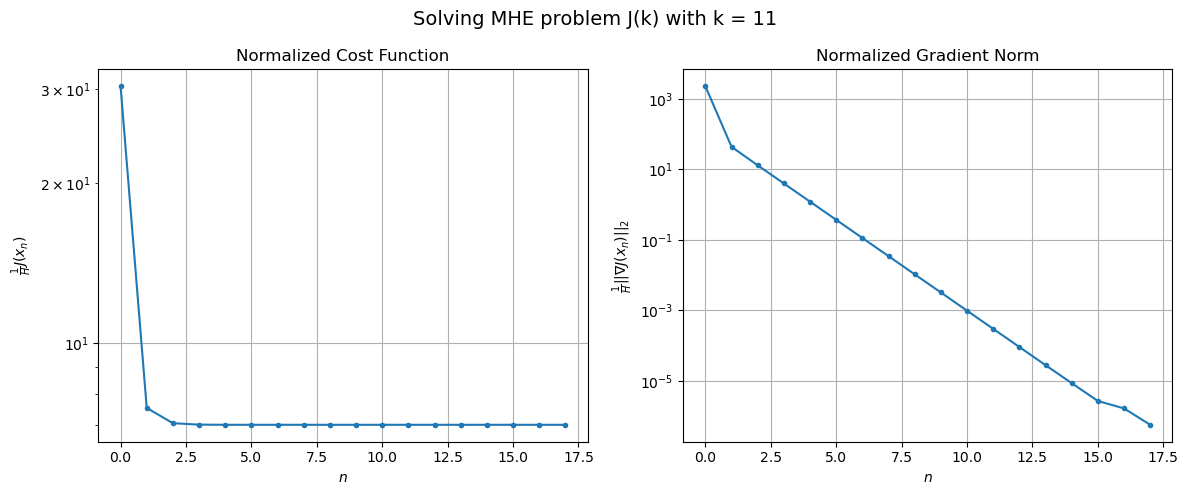

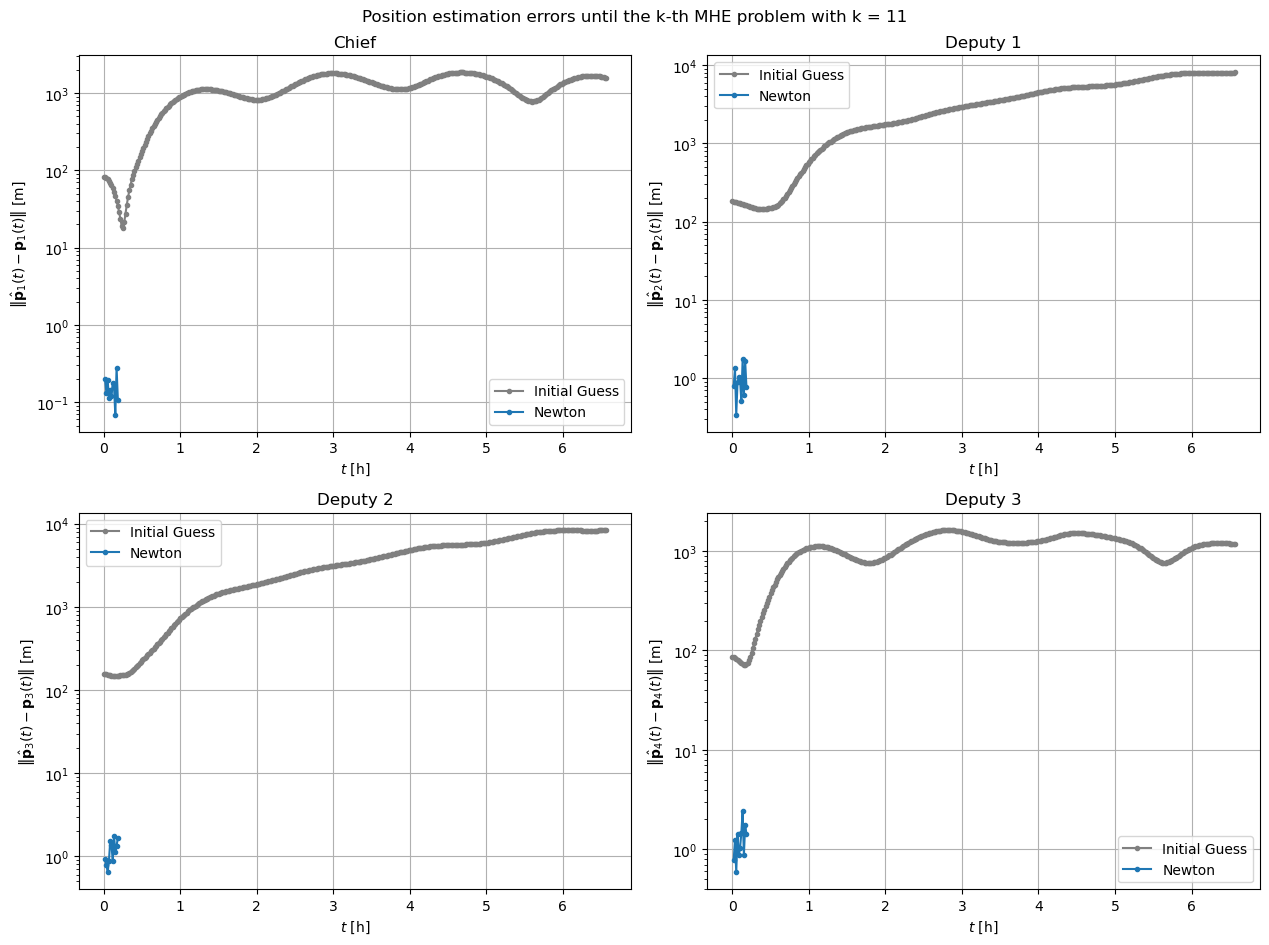

Windows:   3%|▎         | 11/394 [02:04<1:15:46, 11.87s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 67.57183046132698
Gradient norm: 4689.897526285589
Global estimation error: 2.3303082041155623
Spectral radius of inv(T) @ R: 0.6732026146488668
T minimum eigenvalue: 2.969179184413954
Initial conditions estimation errors: 0.10848979537337126 m, 0.7735488879618427 m, 1.6749732909947392 m, 1.4182131377517557 m
Position estimation errors: 0.6824198070983 m, 1.7894975631158903 m, 3.516814534172739 m, 2.7748205261088246 m
Iteration 0.0
Newton direction error: 0.03159872148226352 in 0.07099420848151489
Iteration 0.1
Newton direction error: 0.017817252947231882 in 0.07099420848151489
Iteration 0.2
Newton direction error: 0.011351839664634777 in 0.07099420848151489

[Centralized Newton] Iteration 1
Cost function: 11.324275951197999 (-83.24%)
Gradient norm: 50.24700831499873 (-98.93%)
Global estimation error: 2.3301272722915884 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144312949
T minimum eigenvalue: 2.9691791852131906
In

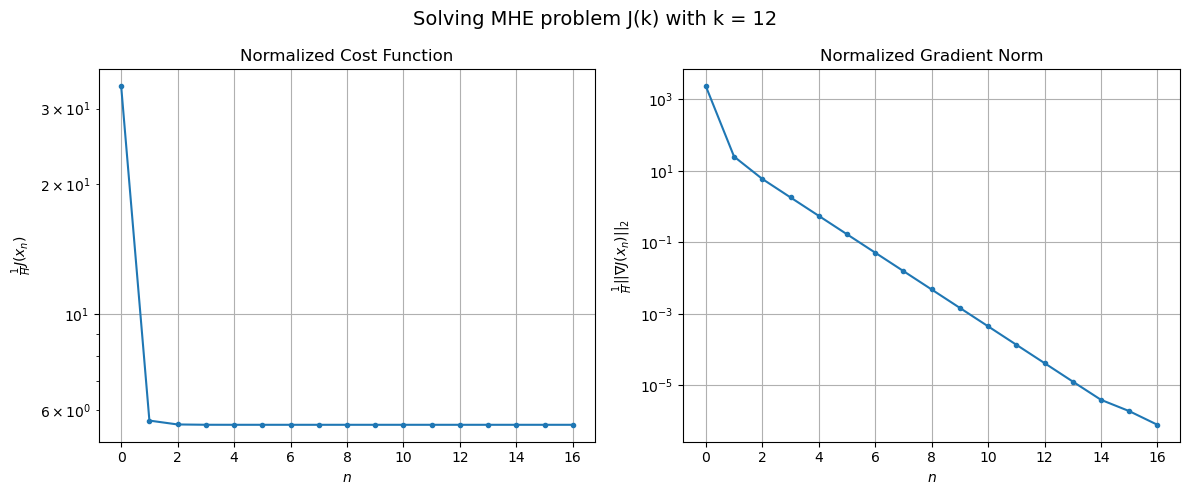

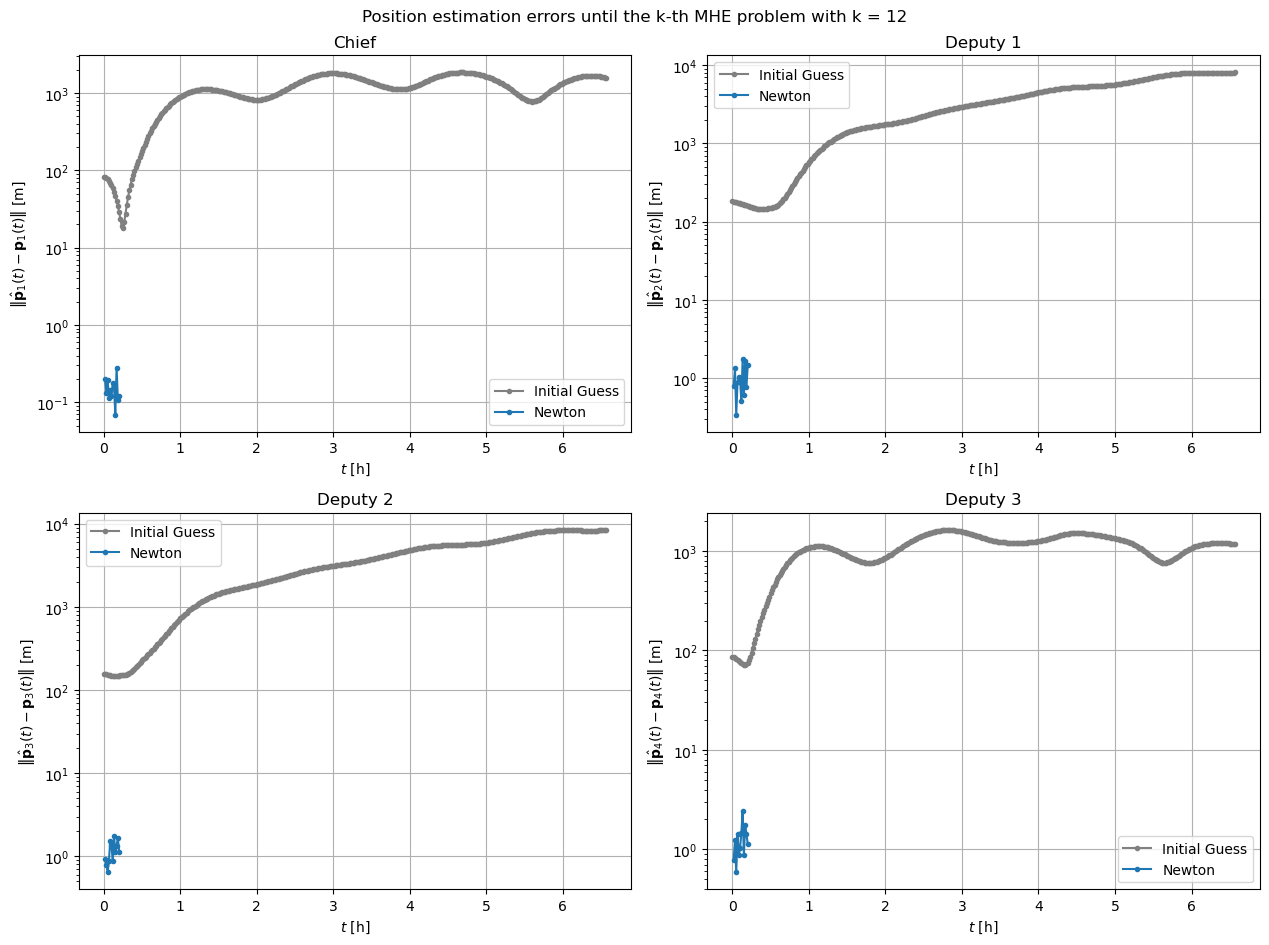

Windows:   3%|▎         | 12/394 [02:15<1:15:05, 11.79s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 50.769084384390474
Gradient norm: 3243.2041657454865
Global estimation error: 2.1692286605958735
Spectral radius of inv(T) @ R: 0.6732026146862776
T minimum eigenvalue: 2.969179190126434
Initial conditions estimation errors: 0.11903208385957041 m, 1.459186978584165 m, 1.1258960366911759 m, 1.1365732767179304 m
Position estimation errors: 0.610424343853195 m, 2.1120393278943586 m, 1.9713152888463314 m, 3.696022203386362 m
Iteration 0.0
Newton direction error: 0.06051399332281793 in 0.10050008770642814
Iteration 0.1
Newton direction error: 0.03952323828151183 in 0.10050008770642814
Iteration 0.2
Newton direction error: 0.026402740491260224 in 0.10050008770642814

[Centralized Newton] Iteration 1
Cost function: 7.122025035451191 (-85.97%)
Gradient norm: 96.09770213785112 (-97.04%)
Global estimation error: 2.1688933954801617 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144827881
T minimum eigenvalue: 2.9691791888674253
I

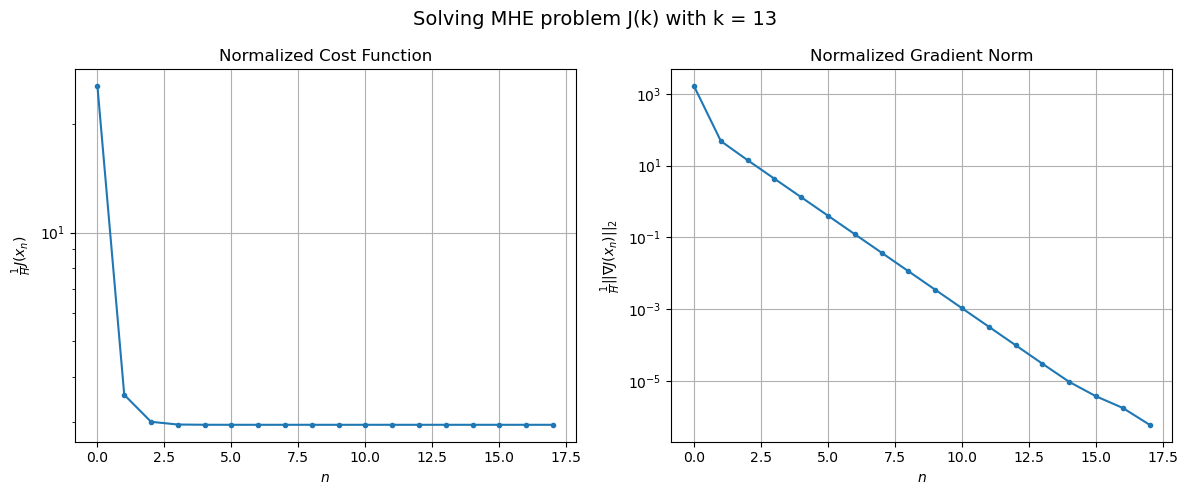

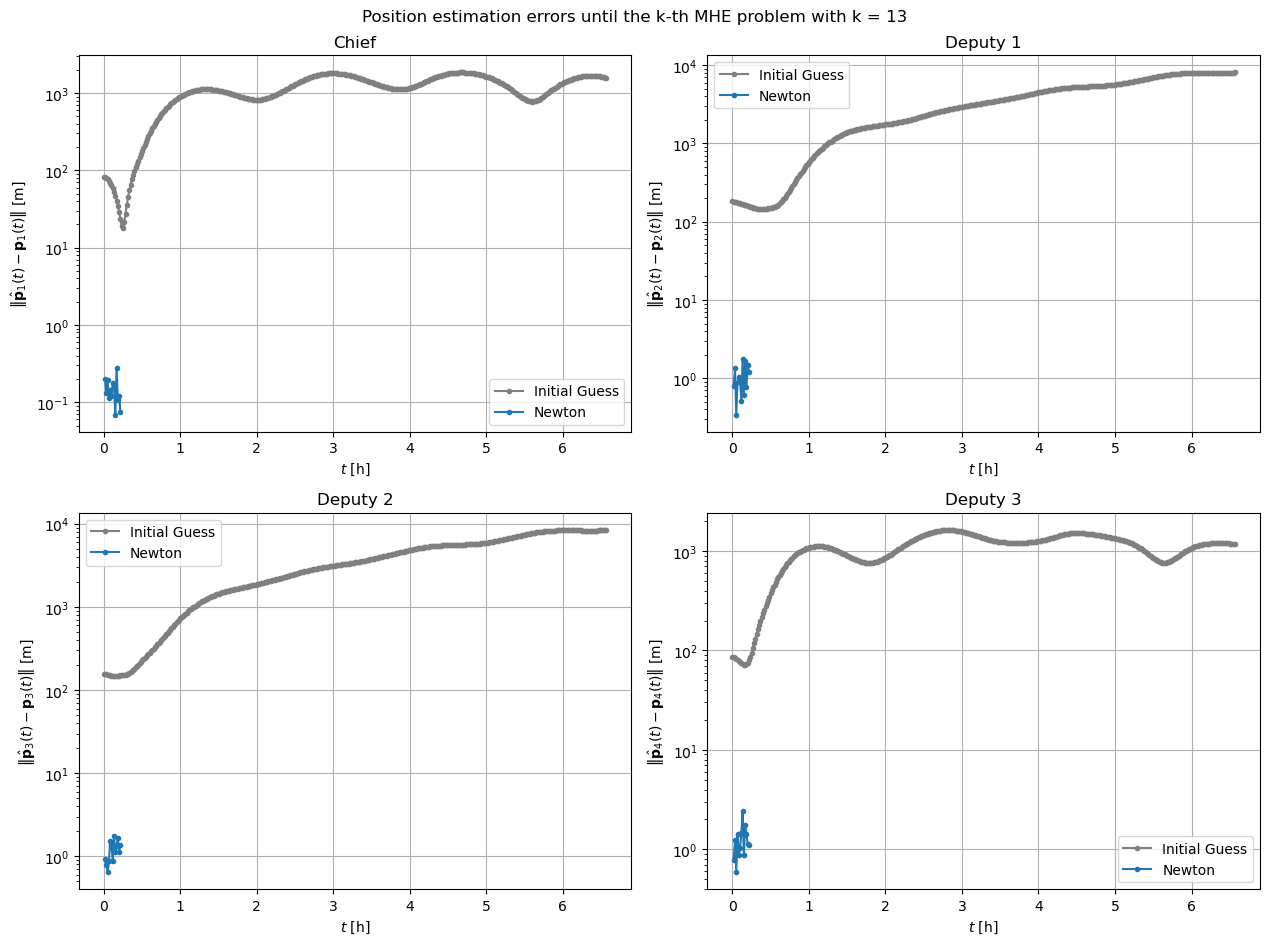

Windows:   3%|▎         | 13/394 [02:27<1:15:27, 11.88s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 76.28867305591267
Gradient norm: 6350.589555773085
Global estimation error: 2.1455817895158154
Spectral radius of inv(T) @ R: 0.673202614918917
T minimum eigenvalue: 2.969179189086932
Initial conditions estimation errors: 0.07495108227451397 m, 1.2118570354010694 m, 1.378787686085018 m, 1.1068310649757631 m
Position estimation errors: 0.9910187976591571 m, 2.3906015125237943 m, 3.347178919147686 m, 2.964918449896636 m
Iteration 0.0
Newton direction error: 0.05013011457449494 in 0.08207135447495811
Iteration 0.1
Newton direction error: 0.033073958421871635 in 0.08207135447495811
Iteration 0.2
Newton direction error: 0.022152850210626397 in 0.08207135447495811

[Centralized Newton] Iteration 1
Cost function: 5.546050424071453 (-92.73%)
Gradient norm: 79.43955633922104 (-98.75%)
Global estimation error: 2.1449765236231335 (-0.03%)
Spectral radius of inv(T) @ R: 0.6732026145098293
T minimum eigenvalue: 2.9691791906817326
Ini

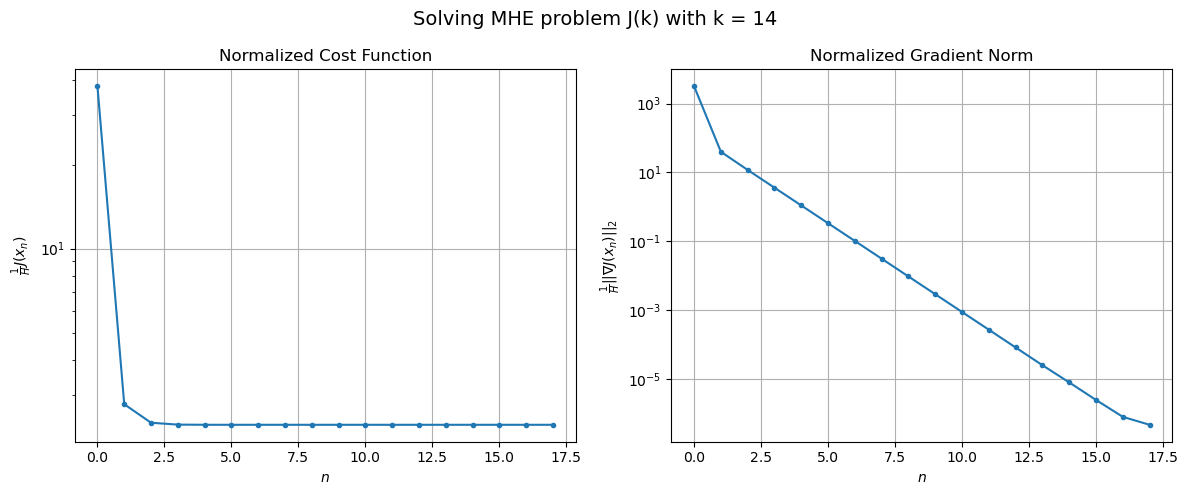

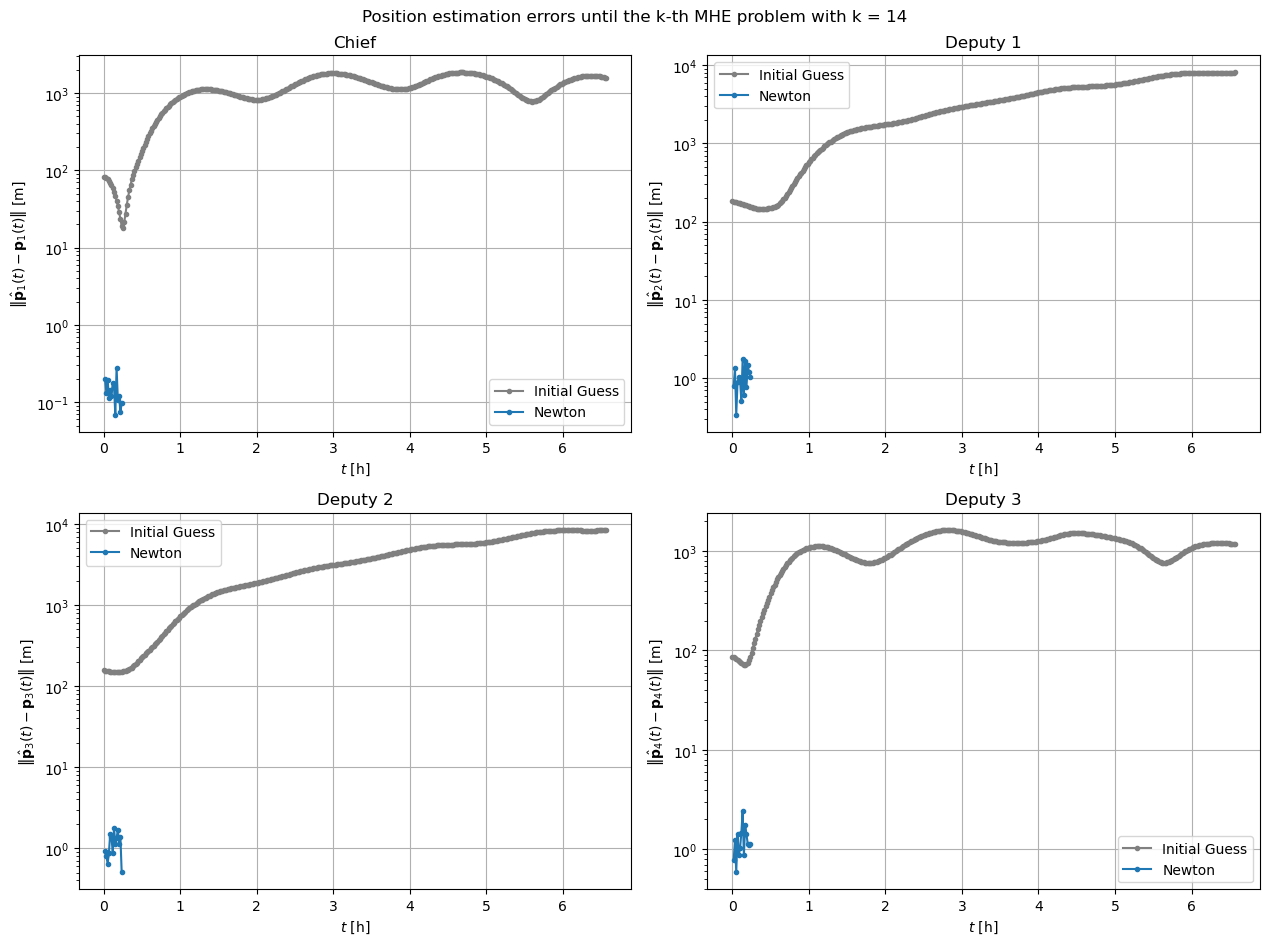

Windows:   4%|▎         | 14/394 [02:39<1:15:15, 11.88s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 32.54657636235567
Gradient norm: 2521.7752784617865
Global estimation error: 1.6173580222125203
Spectral radius of inv(T) @ R: 0.6732026145381498
T minimum eigenvalue: 2.969179194564152
Initial conditions estimation errors: 0.09773673122051599 m, 1.0431938110918784 m, 0.5035514694677422 m, 1.1238271248903036 m
Position estimation errors: 0.5308351395138414 m, 0.8257503304580145 m, 2.1818984012098506 m, 2.5450974049185557 m
Iteration 0.0
Newton direction error: 0.038923547650027715 in 0.0705088176531981
Iteration 0.1
Newton direction error: 0.024643353802844825 in 0.0705088176531981
Iteration 0.2
Newton direction error: 0.016322161409667954 in 0.0705088176531981

[Centralized Newton] Iteration 1
Cost function: 5.096478023063934 (-84.34%)
Gradient norm: 61.75522114133896 (-97.55%)
Global estimation error: 1.6174923951682174 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144389809
T minimum eigenvalue: 2.9691791941649046
I

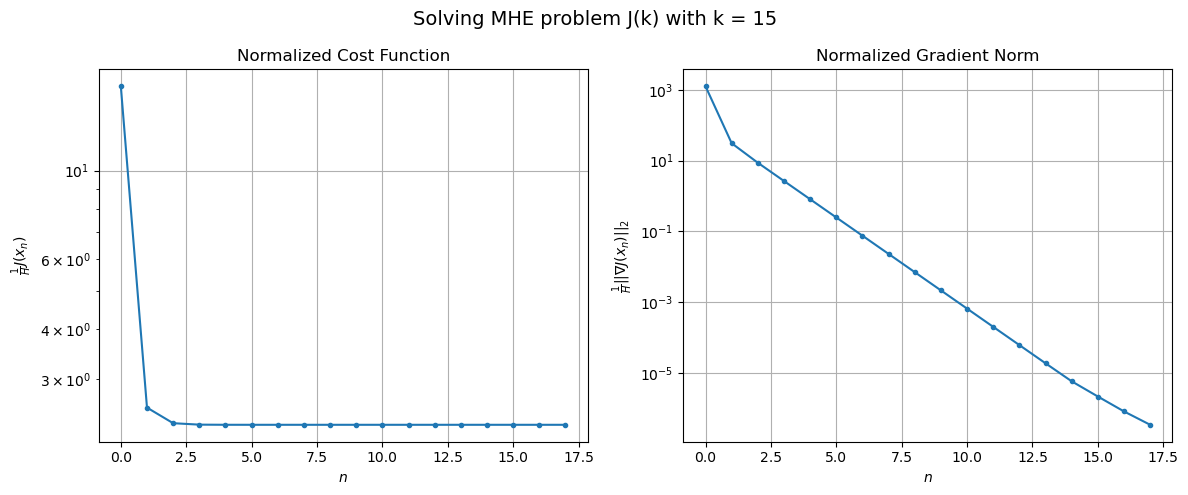

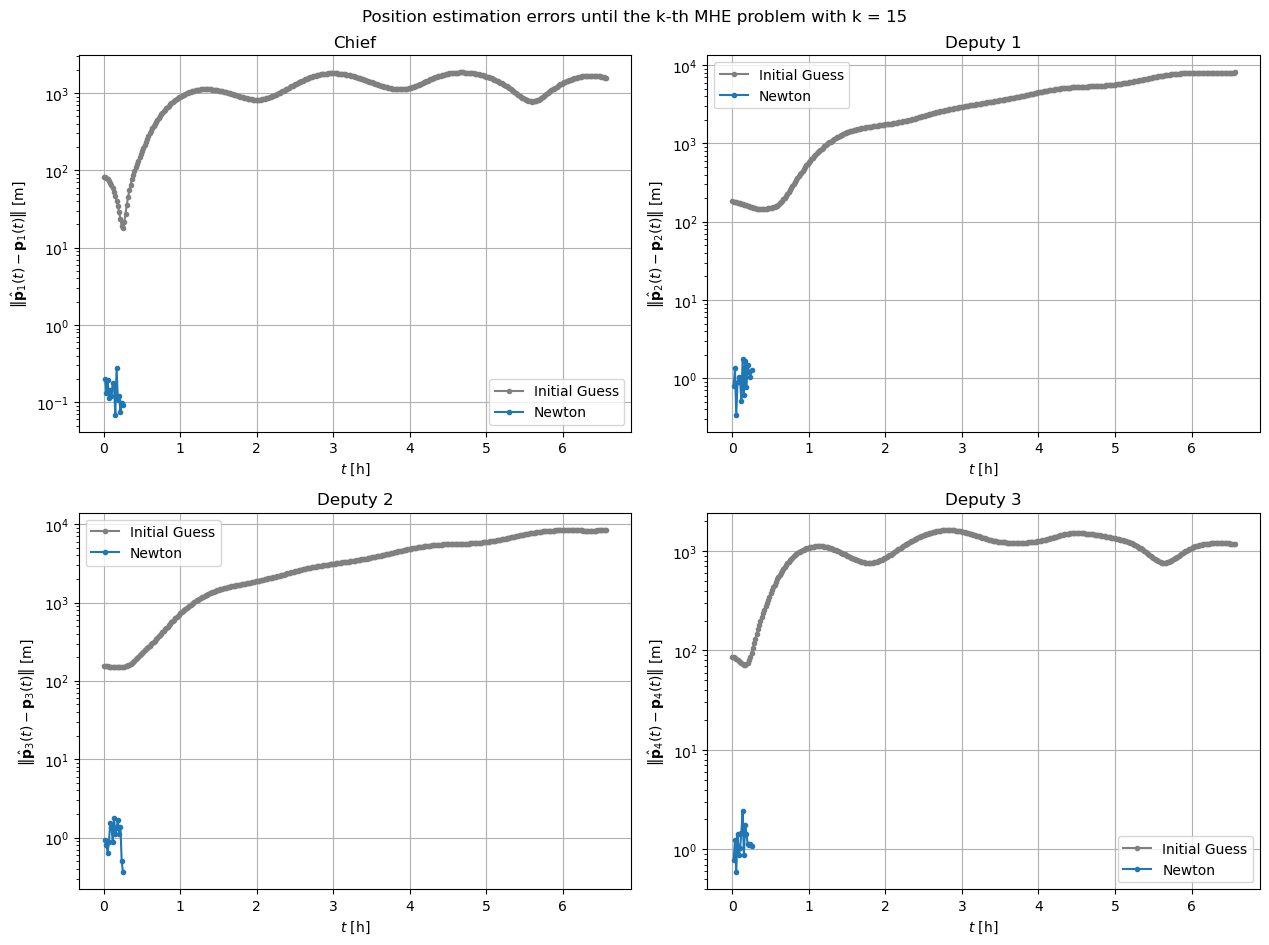

Windows:   4%|▍         | 15/394 [02:53<1:18:30, 12.43s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 64.40143563128056
Gradient norm: 5402.87309236732
Global estimation error: 1.7112872363868679
Spectral radius of inv(T) @ R: 0.6732026147040905
T minimum eigenvalue: 2.9691791967793217
Initial conditions estimation errors: 0.09336927278529987 m, 1.2812556264933377 m, 0.3603154662808496 m, 1.0707392361075656 m
Position estimation errors: 0.8783187193796482 m, 2.813172580511558 m, 0.5232846495600919 m, 2.406459291082167 m
Iteration 0.0
Newton direction error: 0.045592666539938854 in 0.07892592463488161
Iteration 0.1
Newton direction error: 0.02947836820559345 in 0.07892592463488161
Iteration 0.2
Newton direction error: 0.019639231547266055 in 0.07892592463488161

[Centralized Newton] Iteration 1
Cost function: 5.349236634766196 (-91.69%)
Gradient norm: 72.22728969547887 (-98.66%)
Global estimation error: 1.7110586994562282 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144519263
T minimum eigenvalue: 2.9691791968453316
I

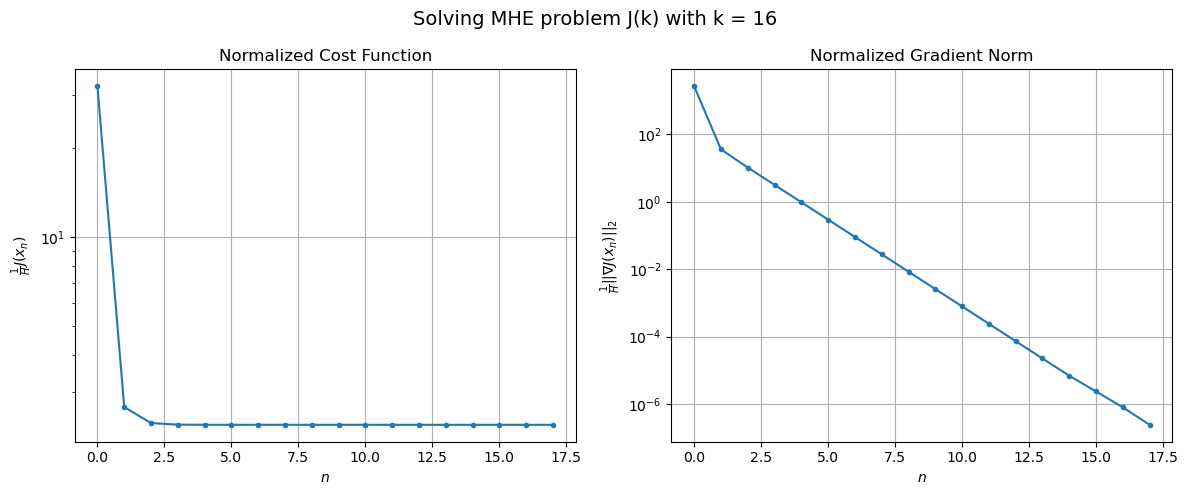

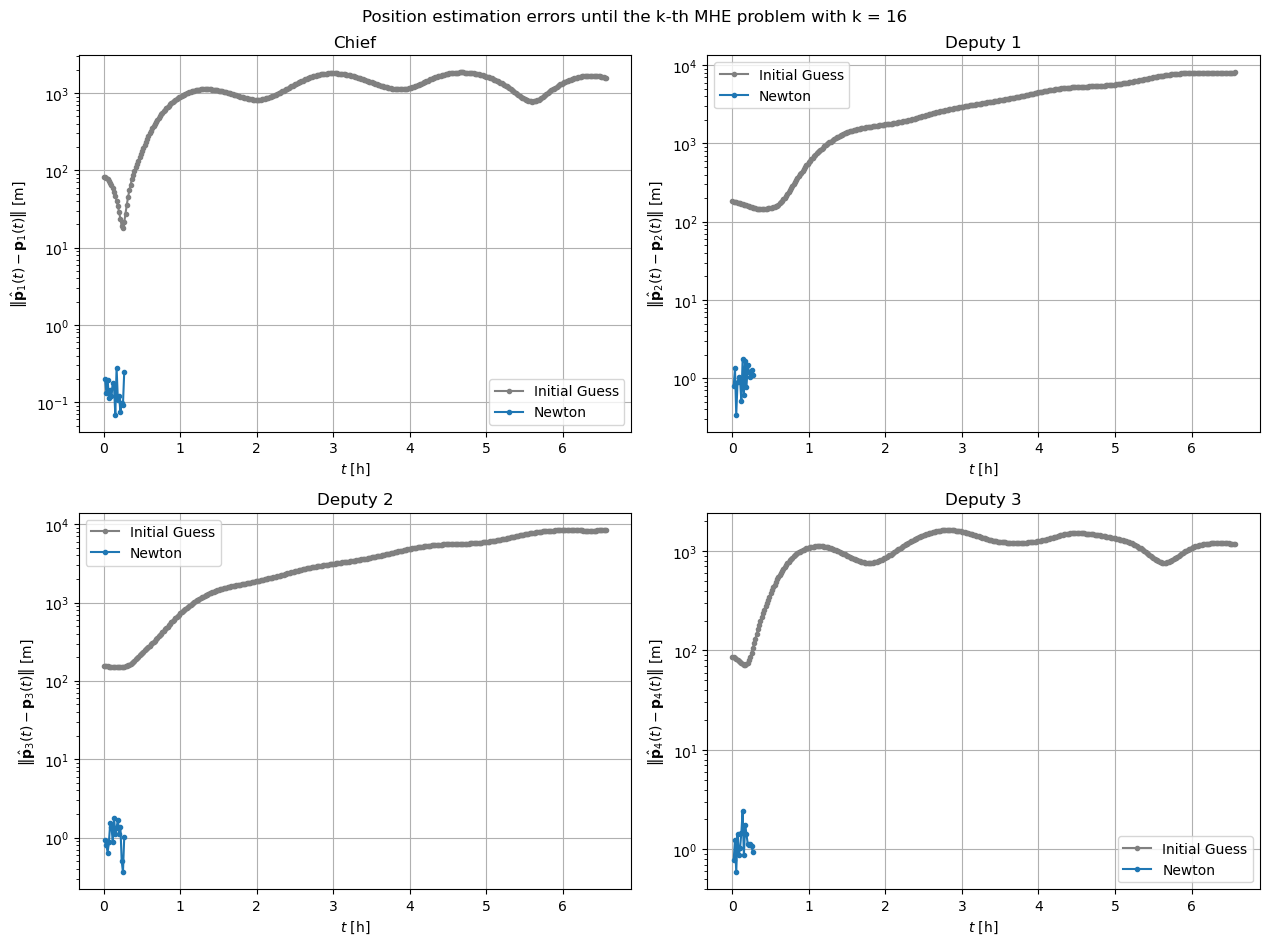

Windows:   4%|▍         | 16/394 [03:15<1:36:37, 15.34s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 74.7980178304538
Gradient norm: 4926.359918418522
Global estimation error: 1.7955824298795344
Spectral radius of inv(T) @ R: 0.6732026147779366
T minimum eigenvalue: 2.9691791984847162
Initial conditions estimation errors: 0.24806684122206618 m, 1.1147181298268323 m, 1.018419059526197 m, 0.937911579960536 m
Position estimation errors: 0.9223180348232474 m, 3.9518675384098185 m, 2.227651975710999 m, 2.608727557095662 m
Iteration 0.0
Newton direction error: 0.06481520270717075 in 0.10804097942026489
Iteration 0.1
Newton direction error: 0.04234244592260659 in 0.10804097942026489
Iteration 0.2
Newton direction error: 0.028287838437562354 in 0.10804097942026489

[Centralized Newton] Iteration 1
Cost function: 8.41476978008222 (-88.75%)
Gradient norm: 102.64103964831433 (-97.92%)
Global estimation error: 1.7951788831065247 (-0.02%)
Spectral radius of inv(T) @ R: 0.673202614514971
T minimum eigenvalue: 2.9691791990816925
Initi

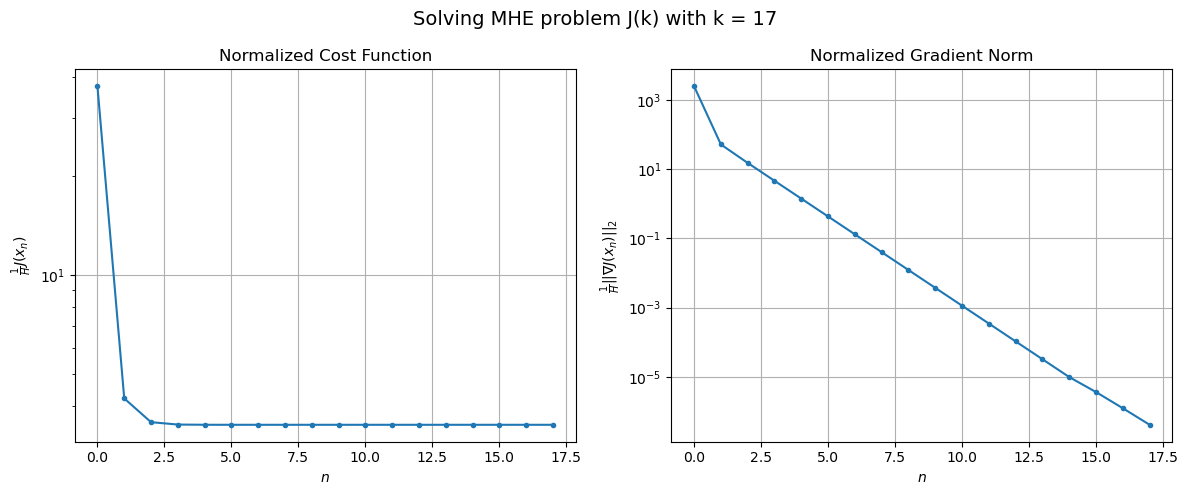

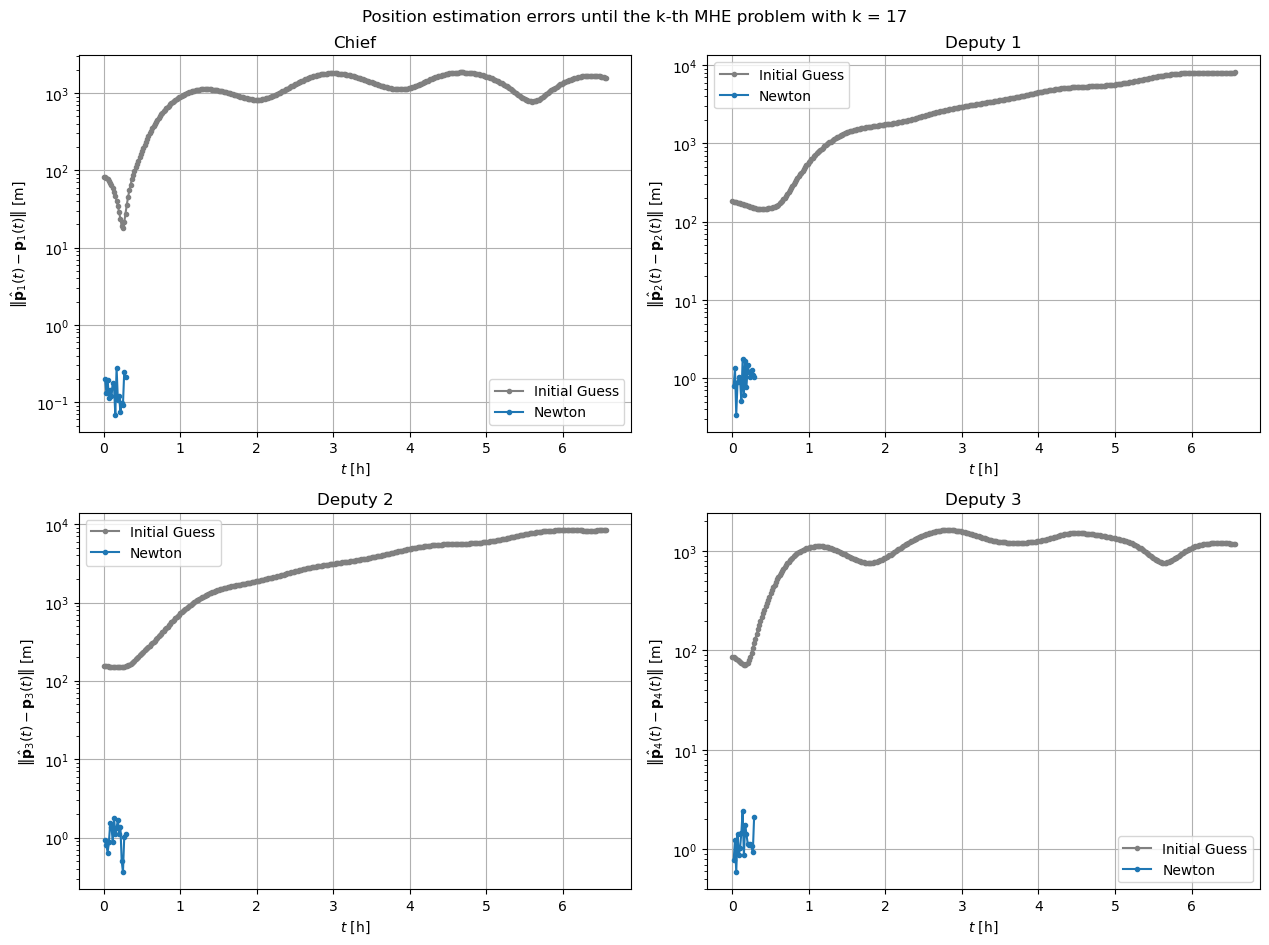

Windows:   4%|▍         | 17/394 [03:48<2:09:44, 20.65s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 52.0075645333733
Gradient norm: 1900.2809235108136
Global estimation error: 2.6096084010045995
Spectral radius of inv(T) @ R: 0.6732026146685703
T minimum eigenvalue: 2.96917920381781
Initial conditions estimation errors: 0.21056208575992047 m, 1.0416357919663555 m, 1.122924970670375 m, 2.1017260174591677 m
Position estimation errors: 0.47355244241861194 m, 2.513675934642669 m, 3.1672256354954444 m, 3.210877692705716 m
Iteration 0.0
Newton direction error: 0.0537445064917223 in 0.09834064843850364
Iteration 0.1
Newton direction error: 0.033822092932584404 in 0.09834064843850364
Iteration 0.2
Newton direction error: 0.022362593714468477 in 0.09834064843850364

[Centralized Newton] Iteration 1
Cost function: 8.789856332491784 (-83.10%)
Gradient norm: 85.4018878083947 (-95.51%)
Global estimation error: 2.6094779092865847 (-0.01%)
Spectral radius of inv(T) @ R: 0.673202614466658
T minimum eigenvalue: 2.9691792024058956
Initi

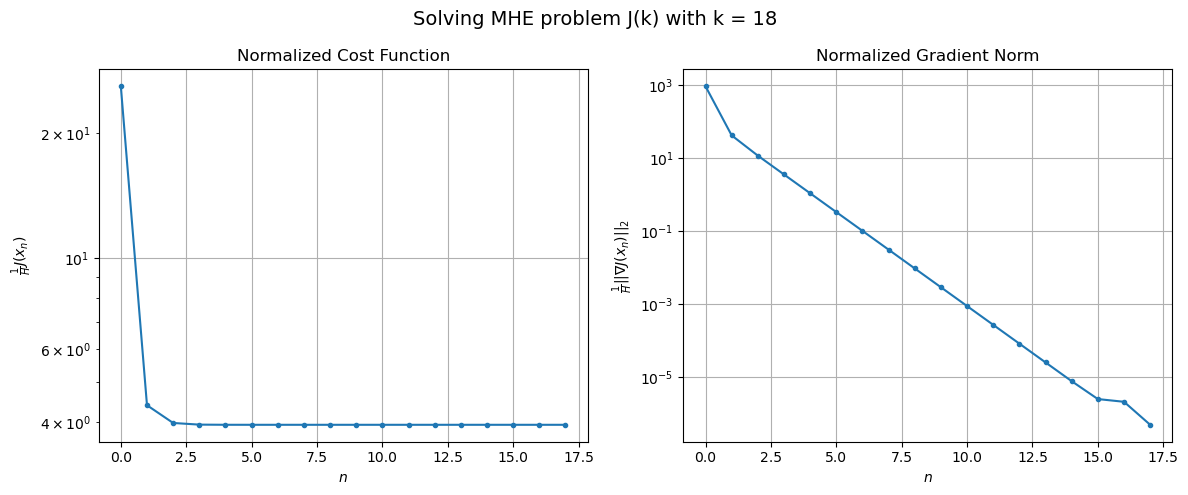

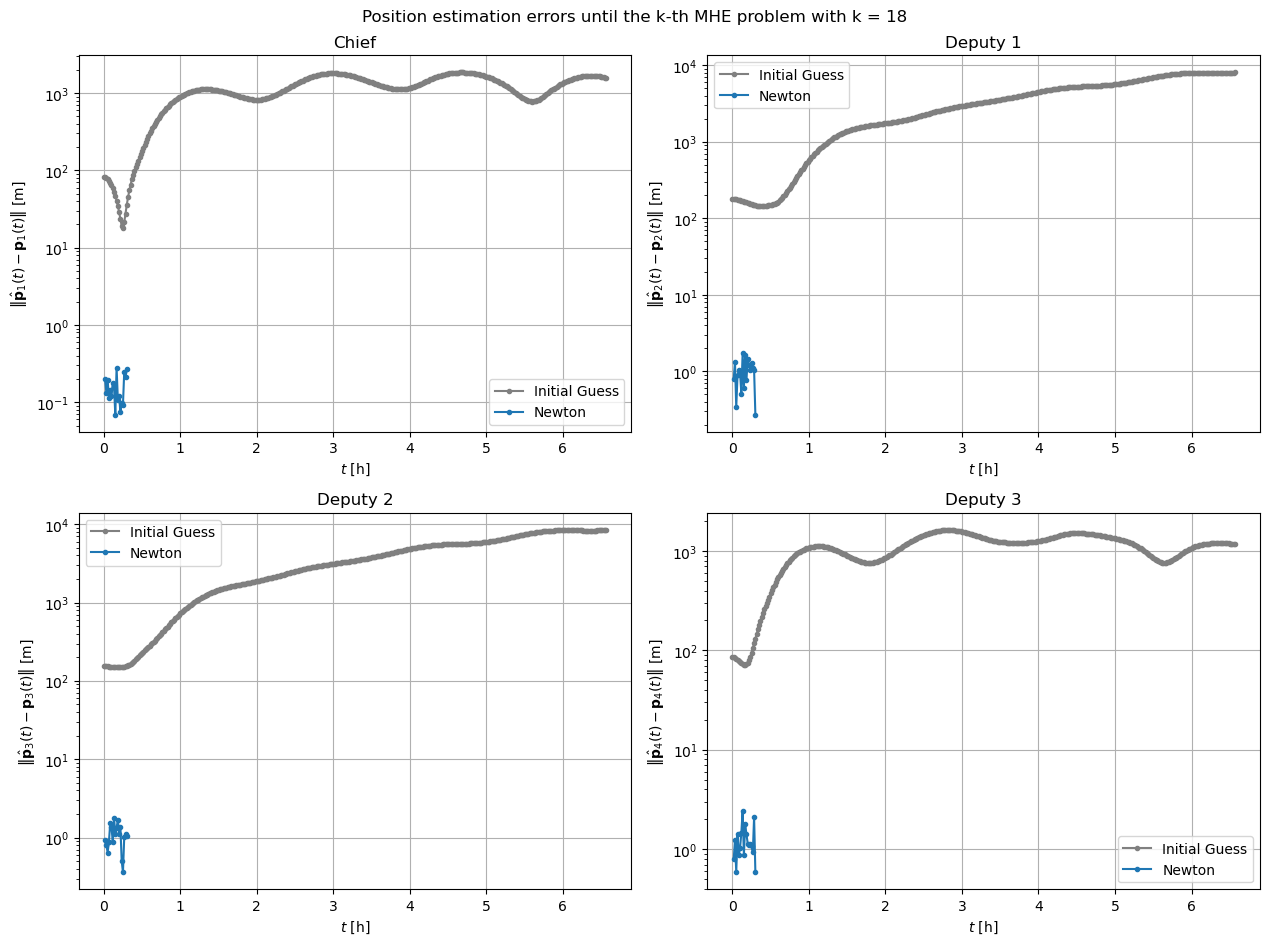

Windows:   5%|▍         | 18/394 [04:22<2:35:22, 24.80s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 124.85189876870562
Gradient norm: 7595.5395081009865
Global estimation error: 1.2576230250573632
Spectral radius of inv(T) @ R: 0.6732026145397312
T minimum eigenvalue: 2.969179203629967
Initial conditions estimation errors: 0.2718434591249802 m, 0.2707564051510436 m, 1.0429734421237393 m, 0.5859489601530976 m
Position estimation errors: 1.0829215889327344 m, 1.8285614556566485 m, 2.912449626372403 m, 2.760283636046474 m
Iteration 0.0
Newton direction error: 0.03701444851503908 in 0.08356452032639174
Iteration 0.1
Newton direction error: 0.021059159518969 in 0.08356452032639174
Iteration 0.2
Newton direction error: 0.013463850588755153 in 0.08356452032639174

[Centralized Newton] Iteration 1
Cost function: 11.739117992475338 (-90.60%)
Gradient norm: 58.83283385455998 (-99.23%)
Global estimation error: 1.2571887429230995 (-0.03%)
Spectral radius of inv(T) @ R: 0.6732026144471254
T minimum eigenvalue: 2.969179203942688
Ini

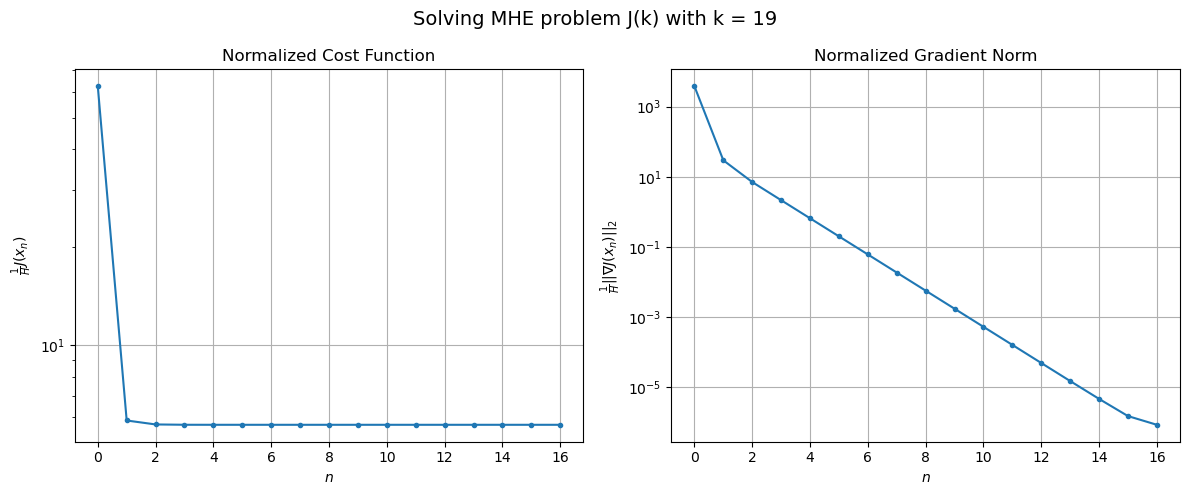

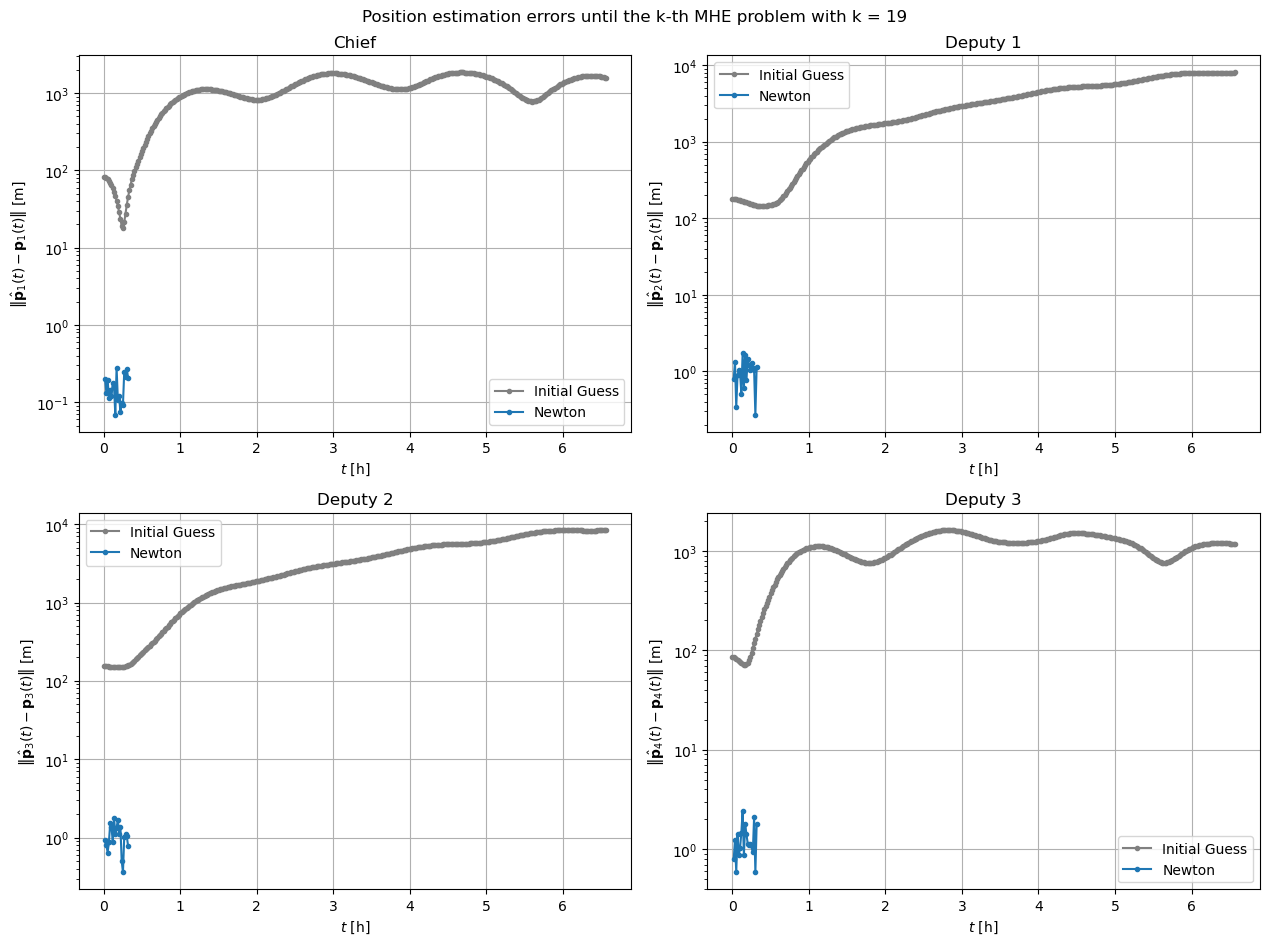

Windows:   5%|▍         | 19/394 [04:46<2:33:10, 24.51s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 43.51624693415553
Gradient norm: 2515.2967710150324
Global estimation error: 2.26408805554667
Spectral radius of inv(T) @ R: 0.6732026148653083
T minimum eigenvalue: 2.969179204305742
Initial conditions estimation errors: 0.2069620293279766 m, 1.1472821734631524 m, 0.7848082124525368 m, 1.774601569956725 m
Position estimation errors: 0.33691096954233374 m, 2.0328819675191436 m, 1.7536411004154457 m, 3.8740265304210277 m
Iteration 0.0
Newton direction error: 0.044253232299549944 in 0.07881411162524078
Iteration 0.1
Newton direction error: 0.02818707762407337 in 0.07881411162524078
Iteration 0.2
Newton direction error: 0.01870130995051991 in 0.07881411162524078

[Centralized Newton] Iteration 1
Cost function: 12.193714097259686 (-71.98%)
Gradient norm: 70.38166666164874 (-97.20%)
Global estimation error: 2.2638995070050827 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026145306843
T minimum eigenvalue: 2.9691792055817134
I

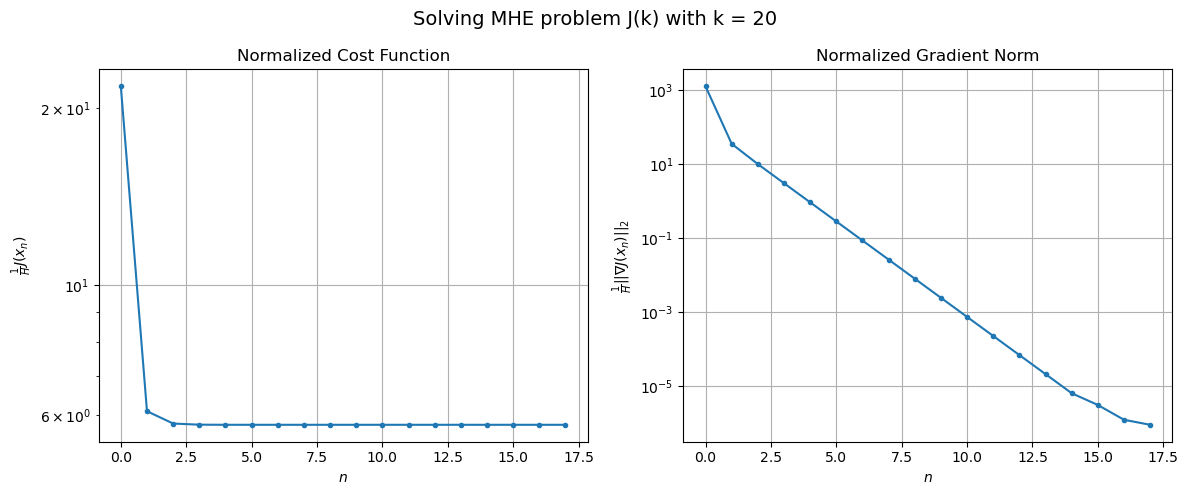

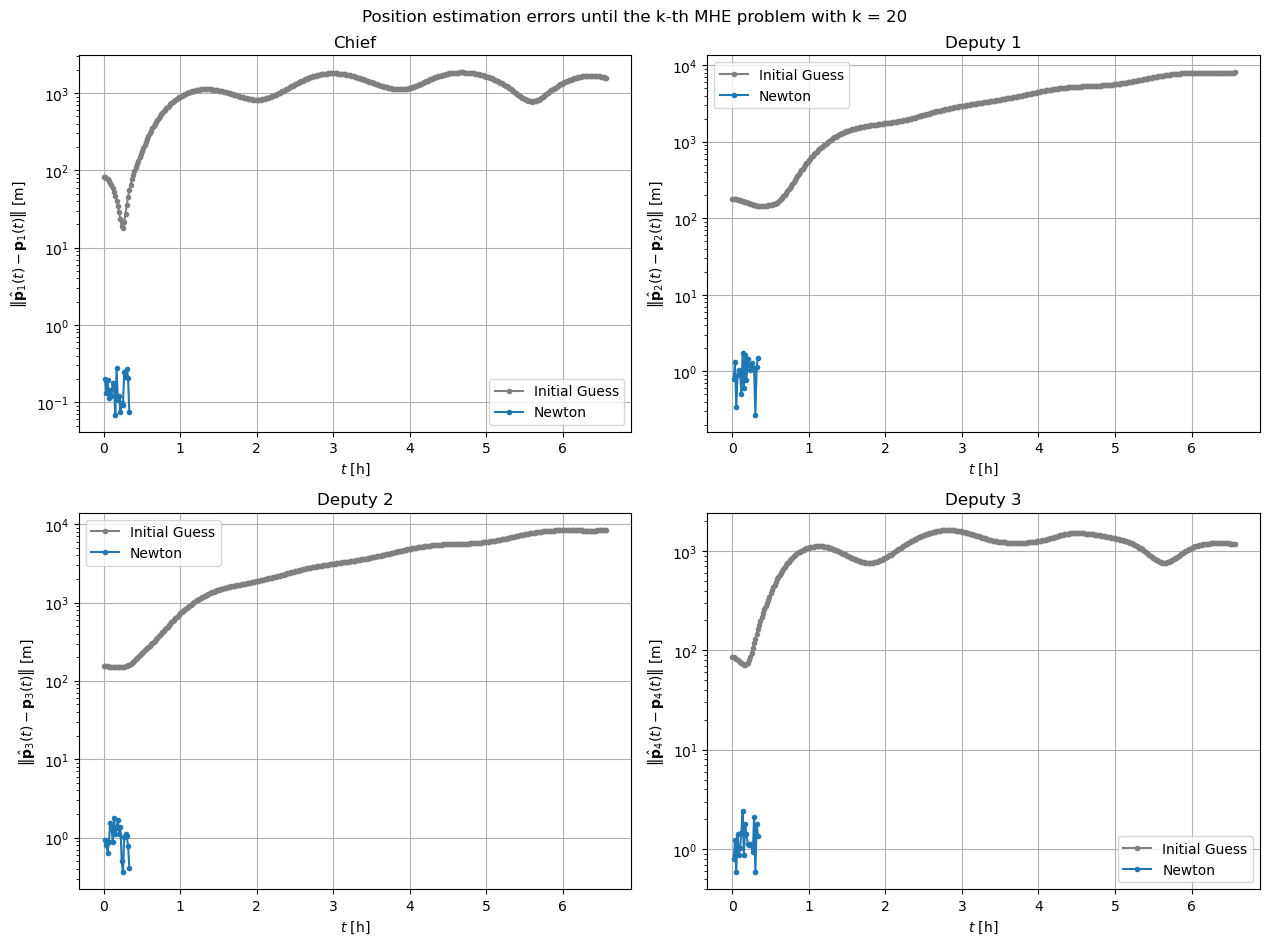

Windows:   5%|▌         | 20/394 [05:20<2:50:45, 27.40s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 67.42619331967026
Gradient norm: 4763.624015311746
Global estimation error: 2.0822529278105146
Spectral radius of inv(T) @ R: 0.6732026146327287
T minimum eigenvalue: 2.969179209590073
Initial conditions estimation errors: 0.07402842567965474 m, 1.5080807508103404 m, 0.4111263238585095 m, 1.3729557002282768 m
Position estimation errors: 0.6862285879981845 m, 2.7915376590592036 m, 0.8771285708329971 m, 2.7926693365183763 m
Iteration 0.0
Newton direction error: 0.04844673169021202 in 0.08634120796398599
Iteration 0.1
Newton direction error: 0.030943036158586283 in 0.08634120796398599
Iteration 0.2
Newton direction error: 0.020545676502020053 in 0.08634120796398599

[Centralized Newton] Iteration 1
Cost function: 10.462259580232518 (-84.48%)
Gradient norm: 76.8490946361941 (-98.39%)
Global estimation error: 2.0824440974767273 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144548118
T minimum eigenvalue: 2.969179208385691
I

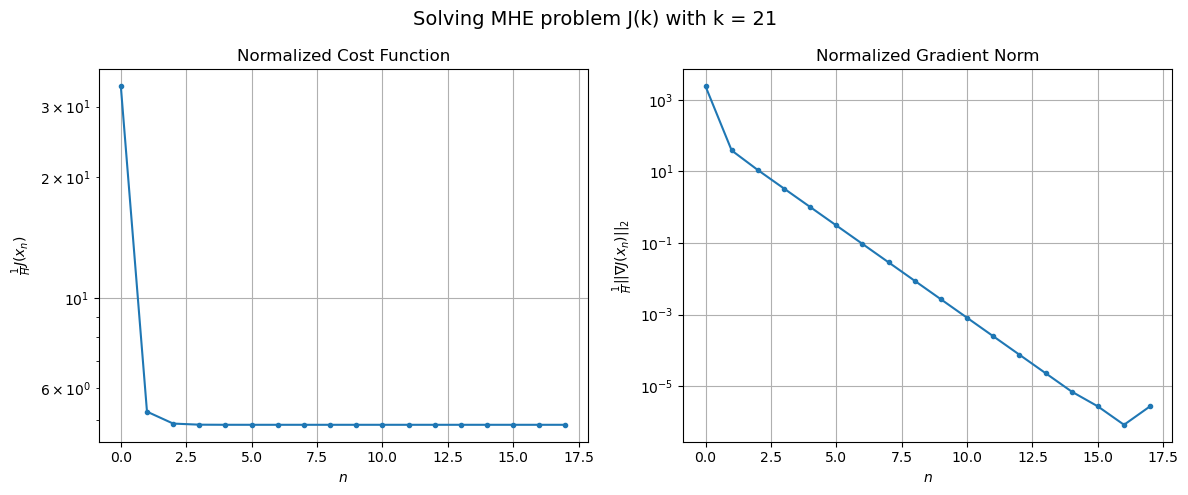

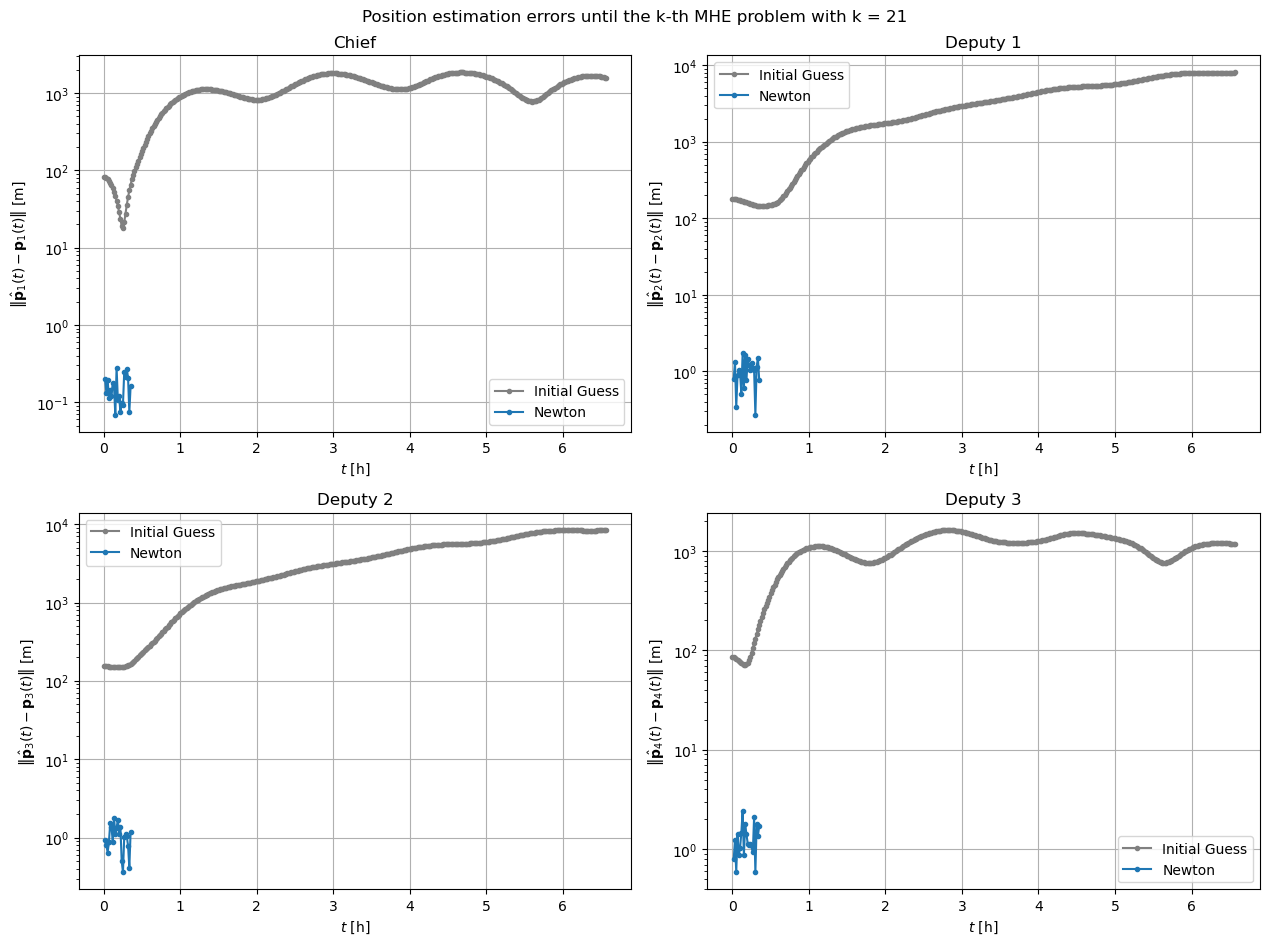

Windows:   5%|▌         | 21/394 [05:43<2:41:25, 25.97s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 75.57486534109616
Gradient norm: 4427.826517393042
Global estimation error: 2.221200596380202
Spectral radius of inv(T) @ R: 0.6732026145085741
T minimum eigenvalue: 2.9691792100481447
Initial conditions estimation errors: 0.16236593034656238 m, 0.768147288204314 m, 1.1864423430853275 m, 1.7045548276614024 m
Position estimation errors: 0.6545950266976761 m, 2.377565631722772 m, 3.1733812163388007 m, 4.534330086325176 m
Iteration 0.0
Newton direction error: 0.041567413113057256 in 0.08888475823506352
Iteration 0.1
Newton direction error: 0.024182932505086338 in 0.08888475823506352
Iteration 0.2
Newton direction error: 0.015588807112494187 in 0.08888475823506352

[Centralized Newton] Iteration 1
Cost function: 9.111930842788926 (-87.94%)
Gradient norm: 66.00098054225023 (-98.51%)
Global estimation error: 2.2209044014370107 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144371587
T minimum eigenvalue: 2.9691792096207985
I

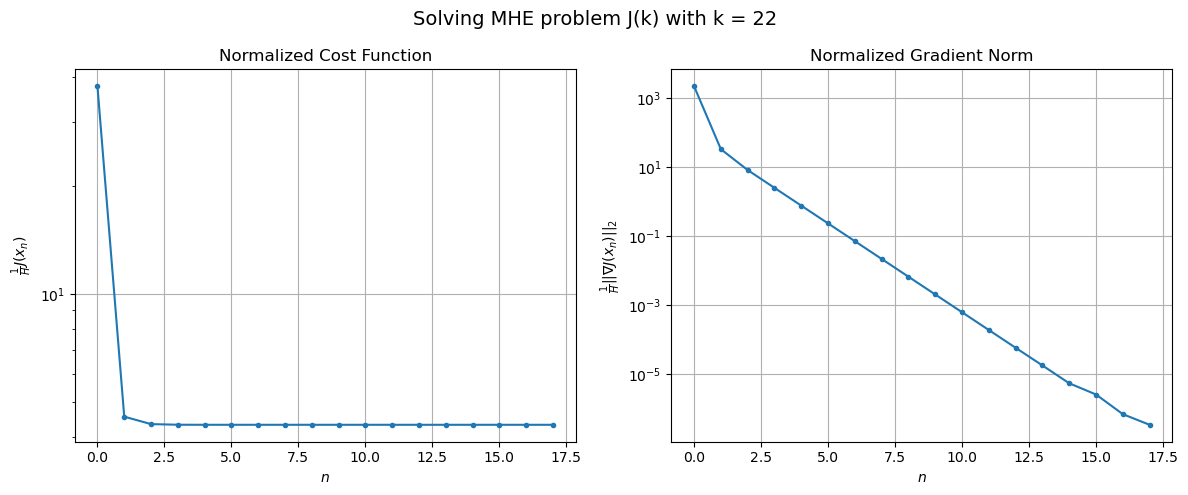

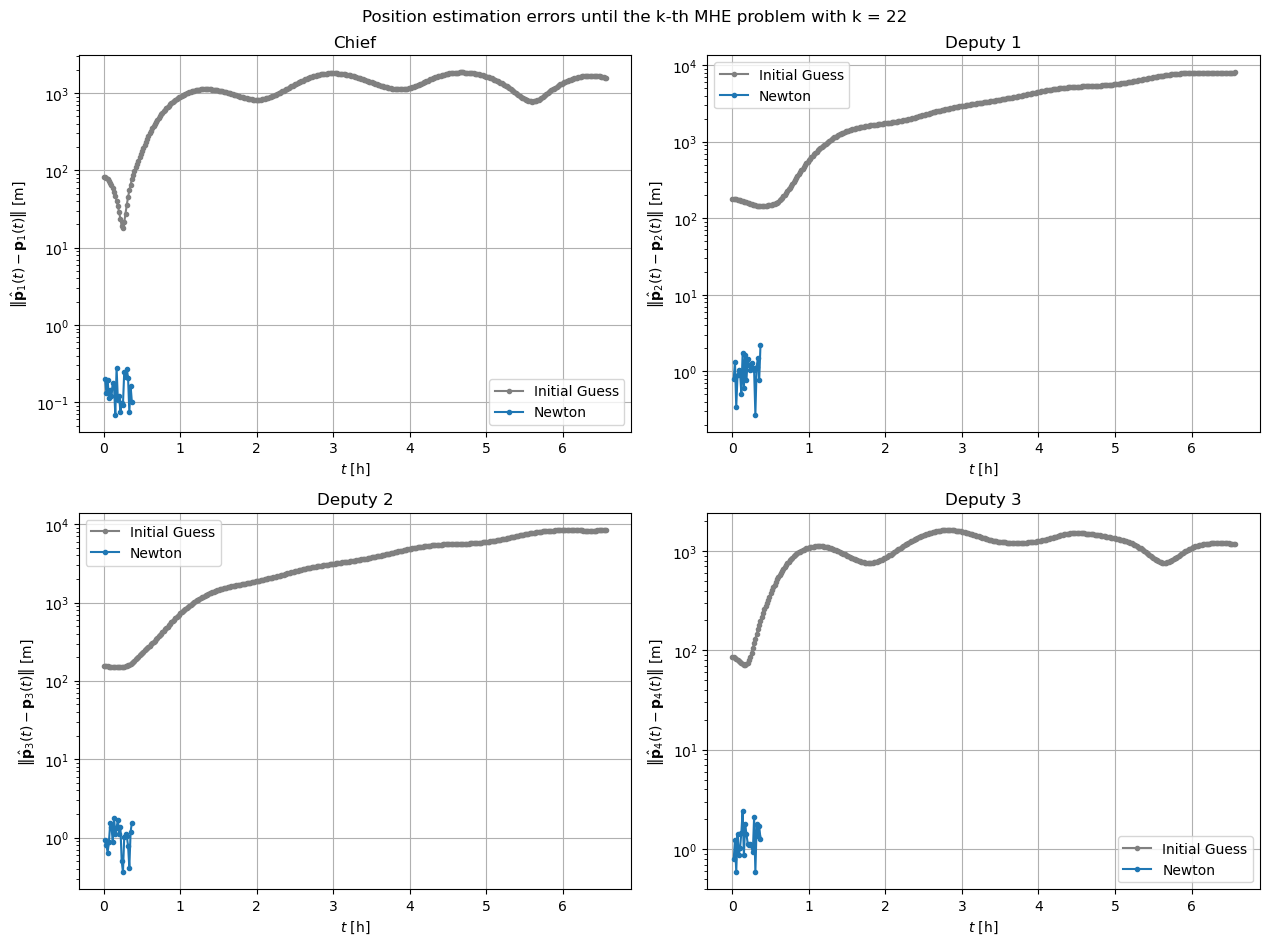

Windows:   6%|▌         | 22/394 [06:14<2:50:21, 27.48s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 77.14897212592415
Gradient norm: 5118.641208598933
Global estimation error: 2.9915789644461865
Spectral radius of inv(T) @ R: 0.6732026150060877
T minimum eigenvalue: 2.9691792085921
Initial conditions estimation errors: 0.10057621239421671 m, 2.206897001064159 m, 1.5567375208359278 m, 1.2815363602768783 m
Position estimation errors: 0.7313067999033543 m, 4.493498761552624 m, 3.55522683190892 m, 2.512804289465654 m
Iteration 0.0
Newton direction error: 0.06911308154160983 in 0.11414571365063818
Iteration 0.1
Newton direction error: 0.04527472485692902 in 0.11414571365063818
Iteration 0.2
Newton direction error: 0.03026876937648811 in 0.11414571365063818

[Centralized Newton] Iteration 1
Cost function: 5.512969360733269 (-92.85%)
Gradient norm: 109.73021855191531 (-97.86%)
Global estimation error: 2.9913338501338766 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026146024237
T minimum eigenvalue: 2.9691792099743752
Initial

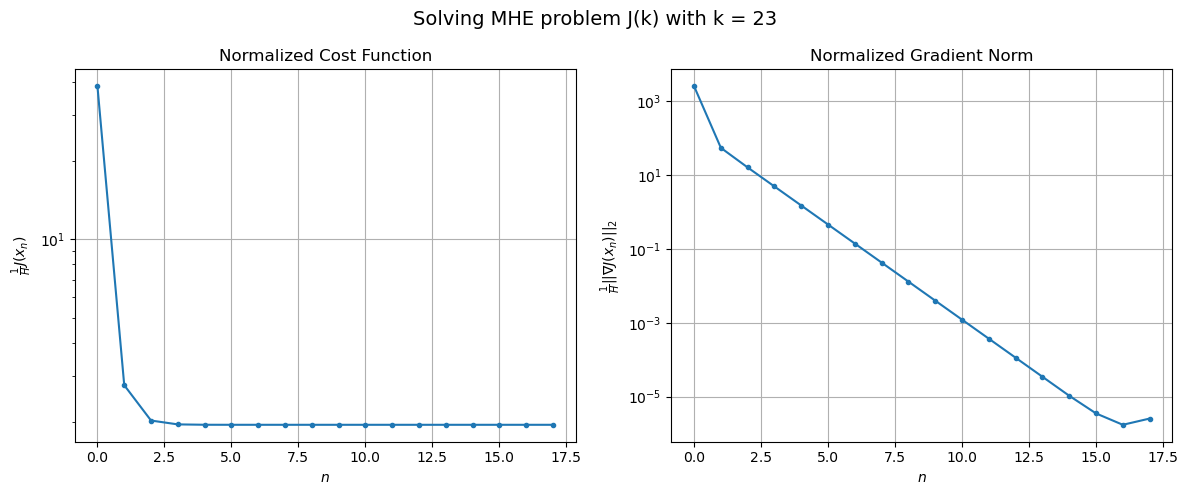

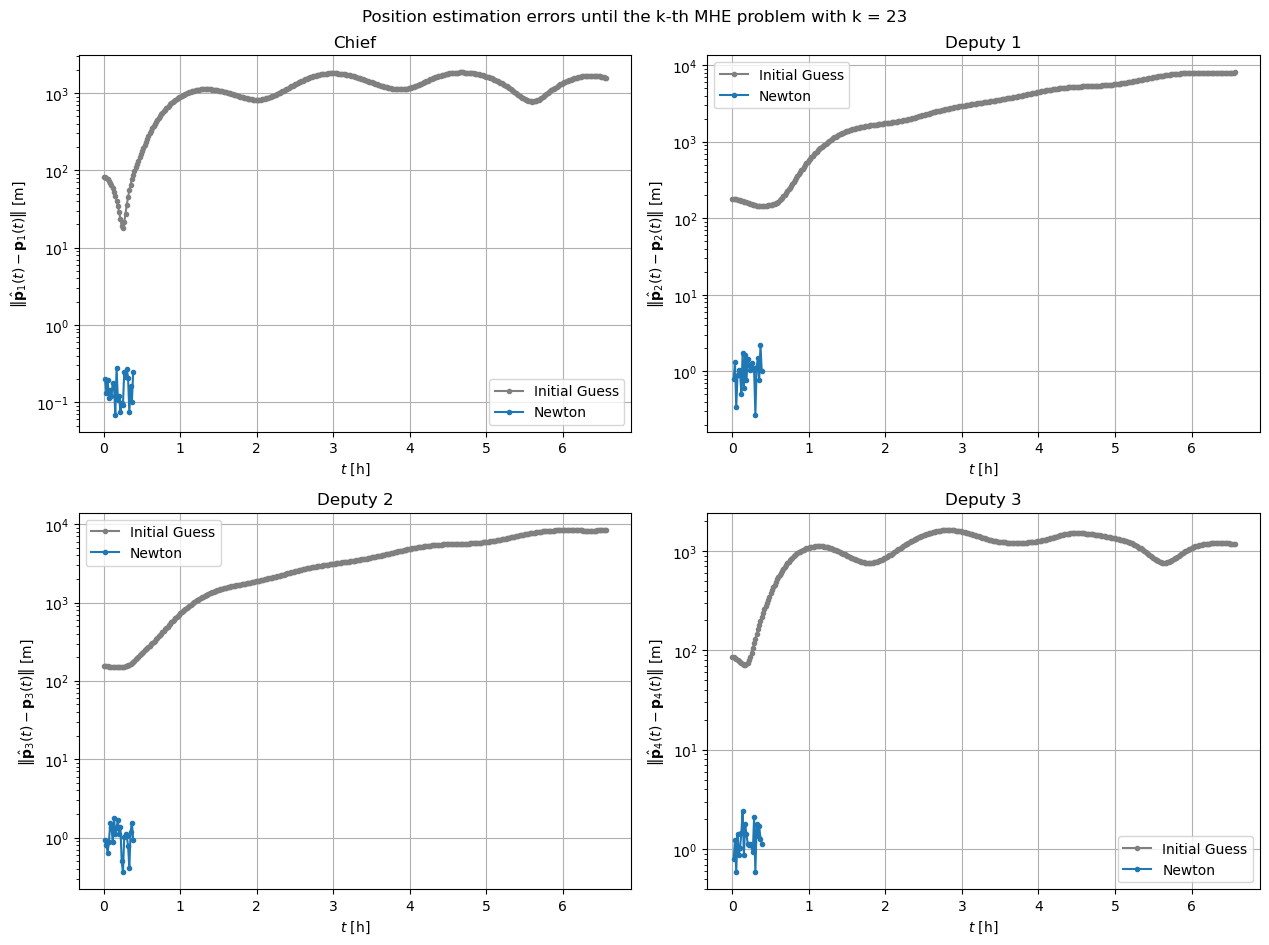

Windows:   6%|▌         | 23/394 [06:41<2:49:25, 27.40s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 61.979573659251336
Gradient norm: 5118.819184438423
Global estimation error: 1.8041443950943248
Spectral radius of inv(T) @ R: 0.6732026146889685
T minimum eigenvalue: 2.9691792133588146
Initial conditions estimation errors: 0.2430803560189392 m, 1.0087291339016324 m, 0.9335344825846915 m, 1.141883458883673 m
Position estimation errors: 0.8375394867493412 m, 2.7633617406220403 m, 0.35799121249096777 m, 2.939184210819622 m
Iteration 0.0
Newton direction error: 0.05304691594456741 in 0.08562649618233702
Iteration 0.1
Newton direction error: 0.03504132813552345 in 0.08562649618233702
Iteration 0.2
Newton direction error: 0.02347801458477376 in 0.08562649618233702

[Centralized Newton] Iteration 1
Cost function: 8.908601184903812 (-85.63%)
Gradient norm: 83.99231568809981 (-98.36%)
Global estimation error: 1.8035591591999252 (-0.03%)
Spectral radius of inv(T) @ R: 0.6732026144649143
T minimum eigenvalue: 2.9691792120166136
I

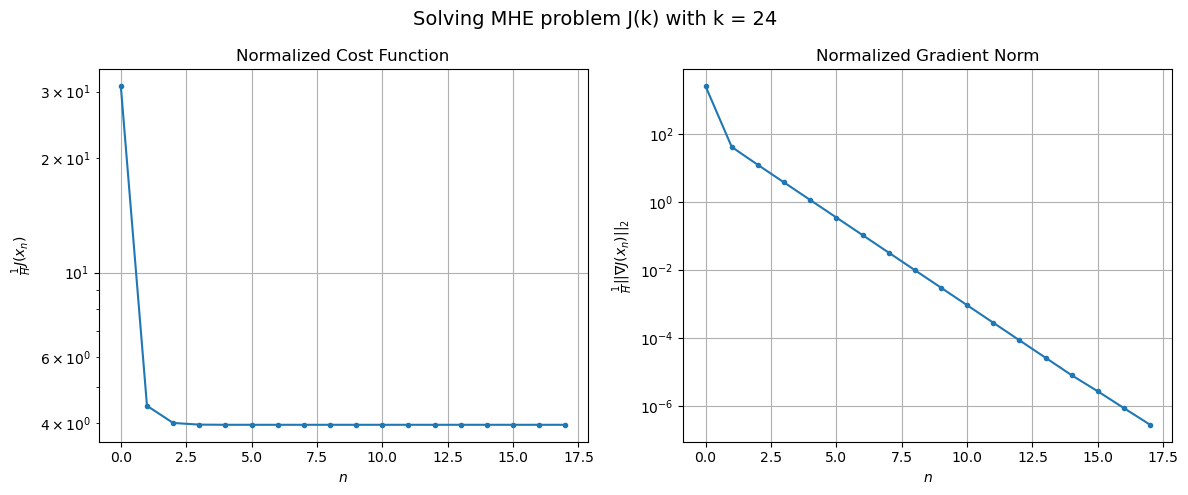

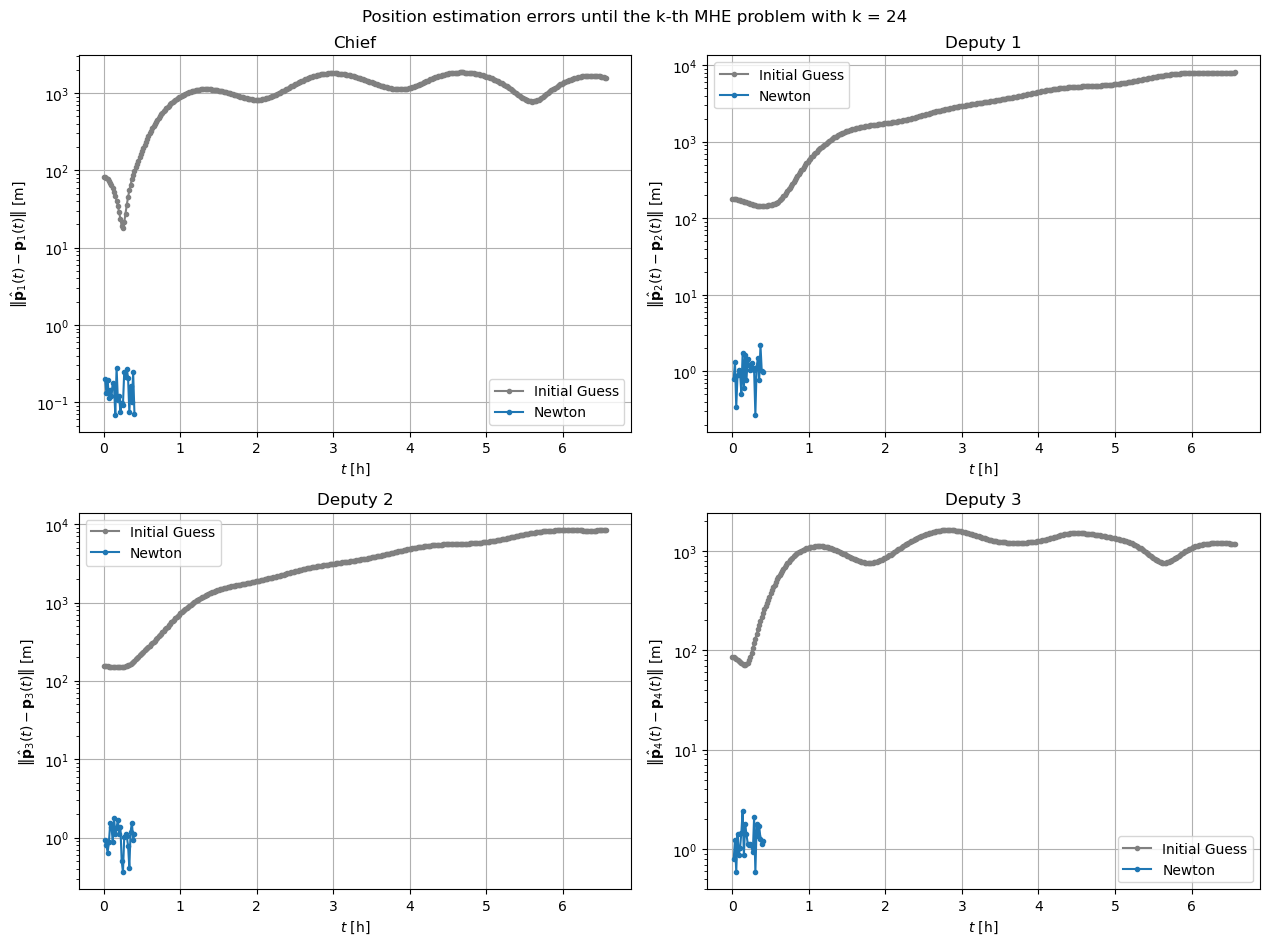

Windows:   6%|▌         | 24/394 [07:11<2:53:09, 28.08s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 82.06757661284408
Gradient norm: 6485.394373080177
Global estimation error: 1.9296765195674574
Spectral radius of inv(T) @ R: 0.6732026146512918
T minimum eigenvalue: 2.969179211649619
Initial conditions estimation errors: 0.07155340165832329 m, 0.9911444643122829 m, 1.1186358890276398 m, 1.2177270409300534 m
Position estimation errors: 0.9391724904718998 m, 1.1460042422926608 m, 2.2680621715908758 m, 3.03631481938866 m
Iteration 0.0
Newton direction error: 0.04083094351585046 in 0.06915281316187241
Iteration 0.1
Newton direction error: 0.026762799618526456 in 0.06915281316187241
Iteration 0.2
Newton direction error: 0.01789516261942115 in 0.06915281316187241

[Centralized Newton] Iteration 1
Cost function: 12.869594188959208 (-84.32%)
Gradient norm: 64.78068403151393 (-99.00%)
Global estimation error: 1.929292484105902 (-0.02%)
Spectral radius of inv(T) @ R: 0.673202614502606
T minimum eigenvalue: 2.9691792119612908
Ini

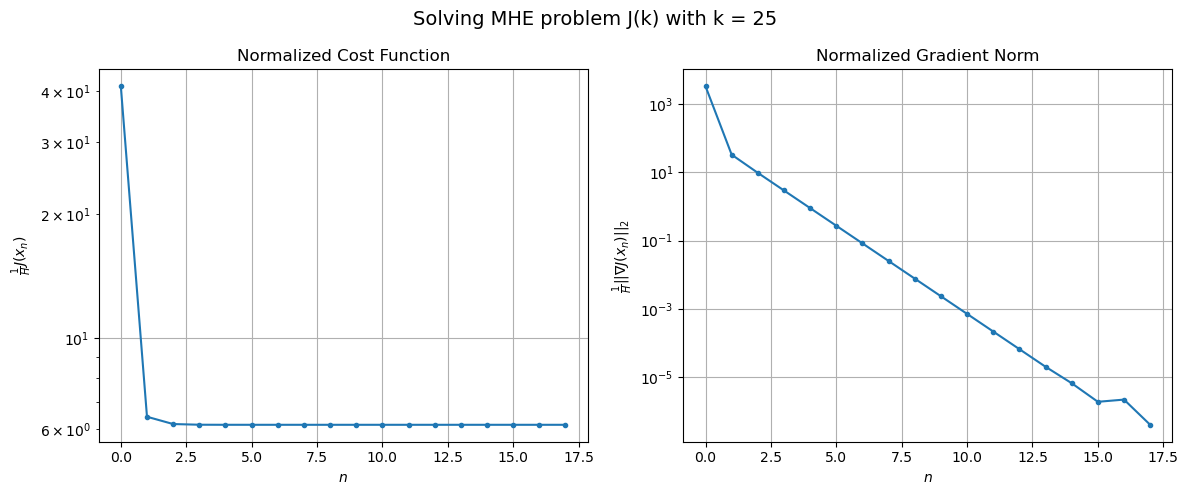

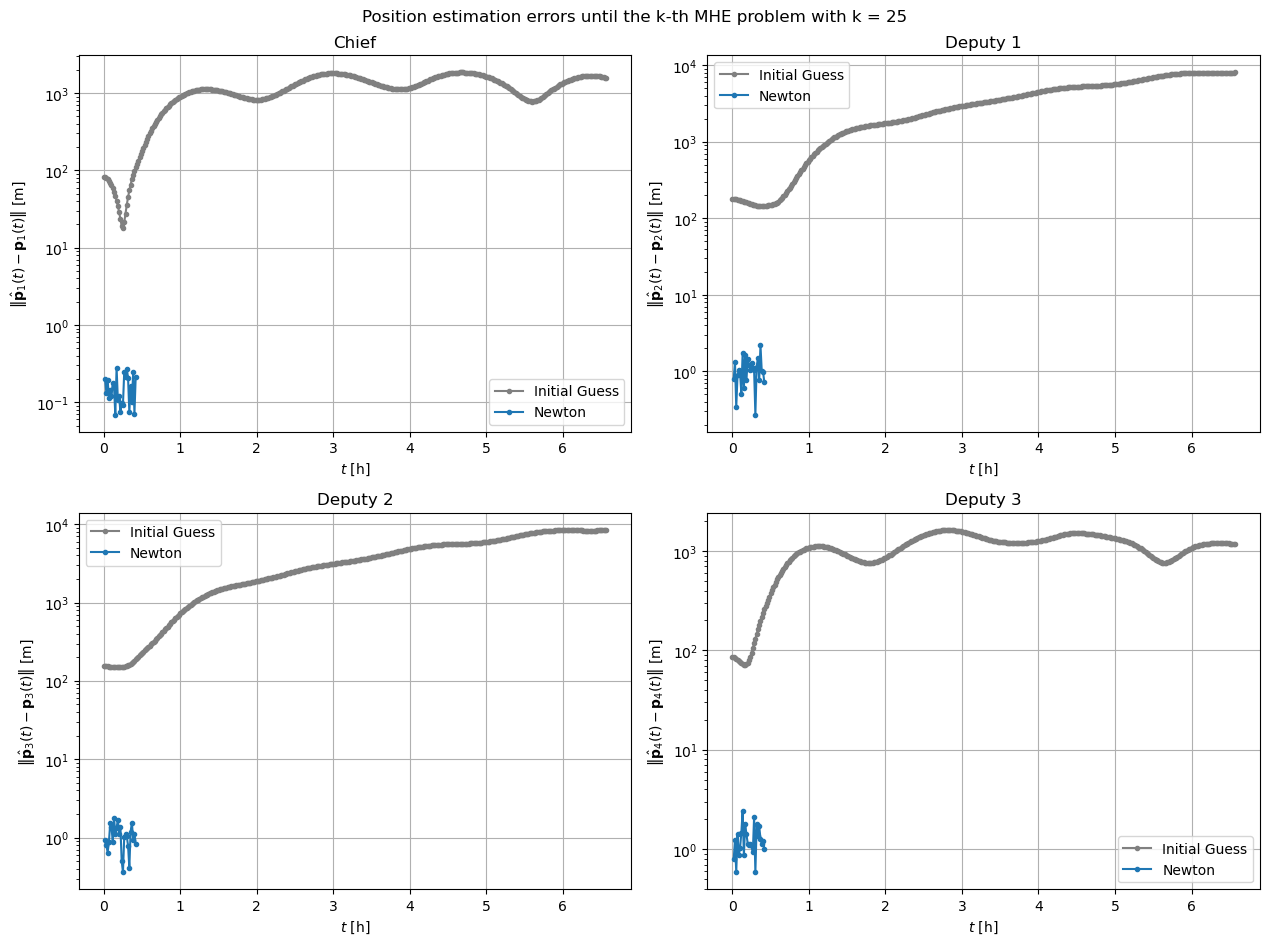

Windows:   6%|▋         | 25/394 [07:39<2:53:23, 28.19s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 59.66726999181477
Gradient norm: 5517.651335536045
Global estimation error: 1.5129714942902577
Spectral radius of inv(T) @ R: 0.6732026144680026
T minimum eigenvalue: 2.969179213330755
Initial conditions estimation errors: 0.21539875009584739 m, 0.7287577247219638 m, 0.8329285034652896 m, 1.008566811229082 m
Position estimation errors: 0.8546730549040288 m, 0.319921770145471 m, 0.7803391130030097 m, 1.2218987491790547 m
Iteration 0.0
Newton direction error: 0.02227777712681447 in 0.04702359153491102
Iteration 0.1
Newton direction error: 0.01342415734380595 in 0.04702359153491102
Iteration 0.2
Newton direction error: 0.008757995825846361 in 0.04702359153491102

[Centralized Newton] Iteration 1
Cost function: 9.257755182113494 (-84.48%)
Gradient norm: 35.35473547634973 (-99.36%)
Global estimation error: 1.513167205684044 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144141214
T minimum eigenvalue: 2.9691792127460666
Init

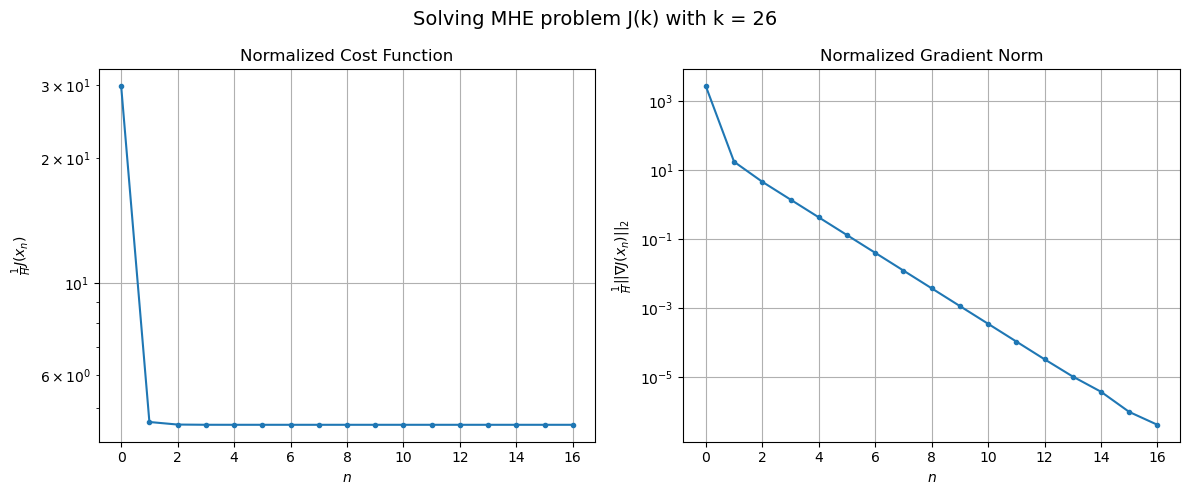

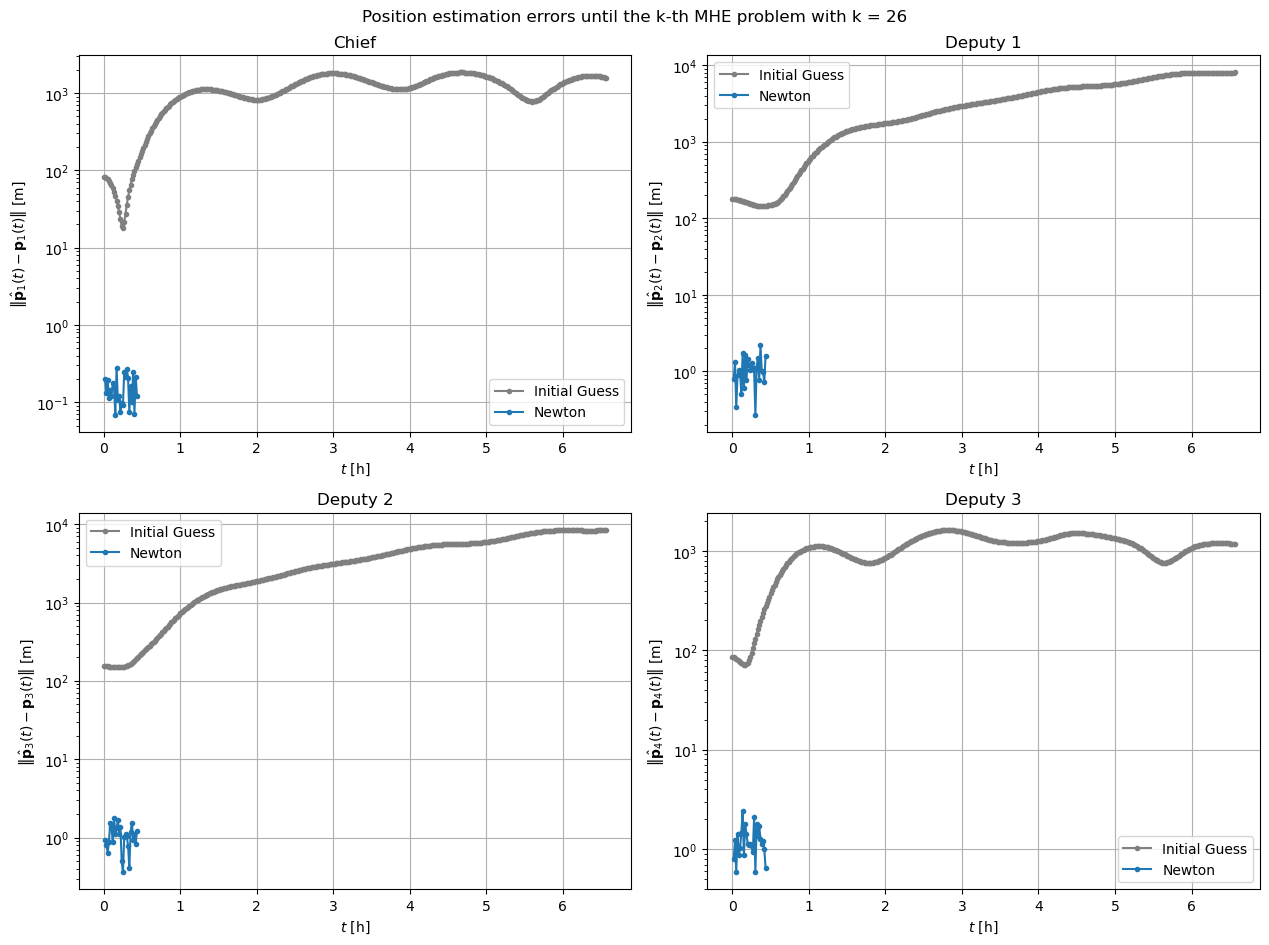

Windows:   7%|▋         | 26/394 [08:07<2:51:29, 27.96s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 63.417118121134095
Gradient norm: 4634.598731567902
Global estimation error: 2.1302897164152244
Spectral radius of inv(T) @ R: 0.6732026146148216
T minimum eigenvalue: 2.969179212900309
Initial conditions estimation errors: 0.1194763077210819 m, 1.6118944623428009 m, 1.2265900142645005 m, 0.6474808163621731 m
Position estimation errors: 0.6964452059232393 m, 3.1084998047915873 m, 2.762175693473725 m, 1.1438342654303328 m
Iteration 0.0
Newton direction error: 0.04655969658472508 in 0.08445458306651749
Iteration 0.1
Newton direction error: 0.029533428388211738 in 0.08445458306651749
Iteration 0.2
Newton direction error: 0.01957153619935244 in 0.08445458306651749

[Centralized Newton] Iteration 1
Cost function: 8.046850487295691 (-87.31%)
Gradient norm: 73.79650945765391 (-98.41%)
Global estimation error: 2.130153225375704 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144677201
T minimum eigenvalue: 2.969179212645119
Ini

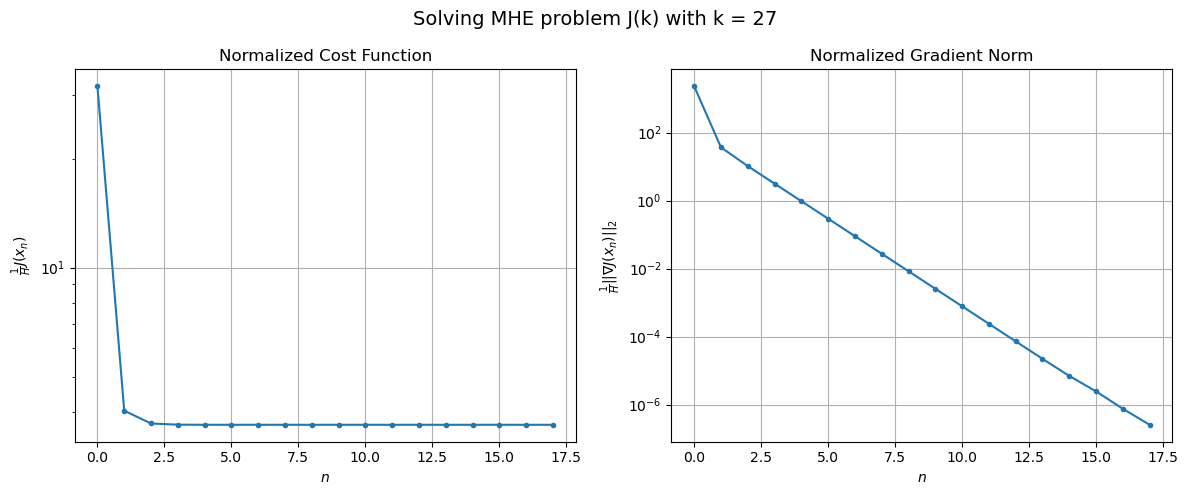

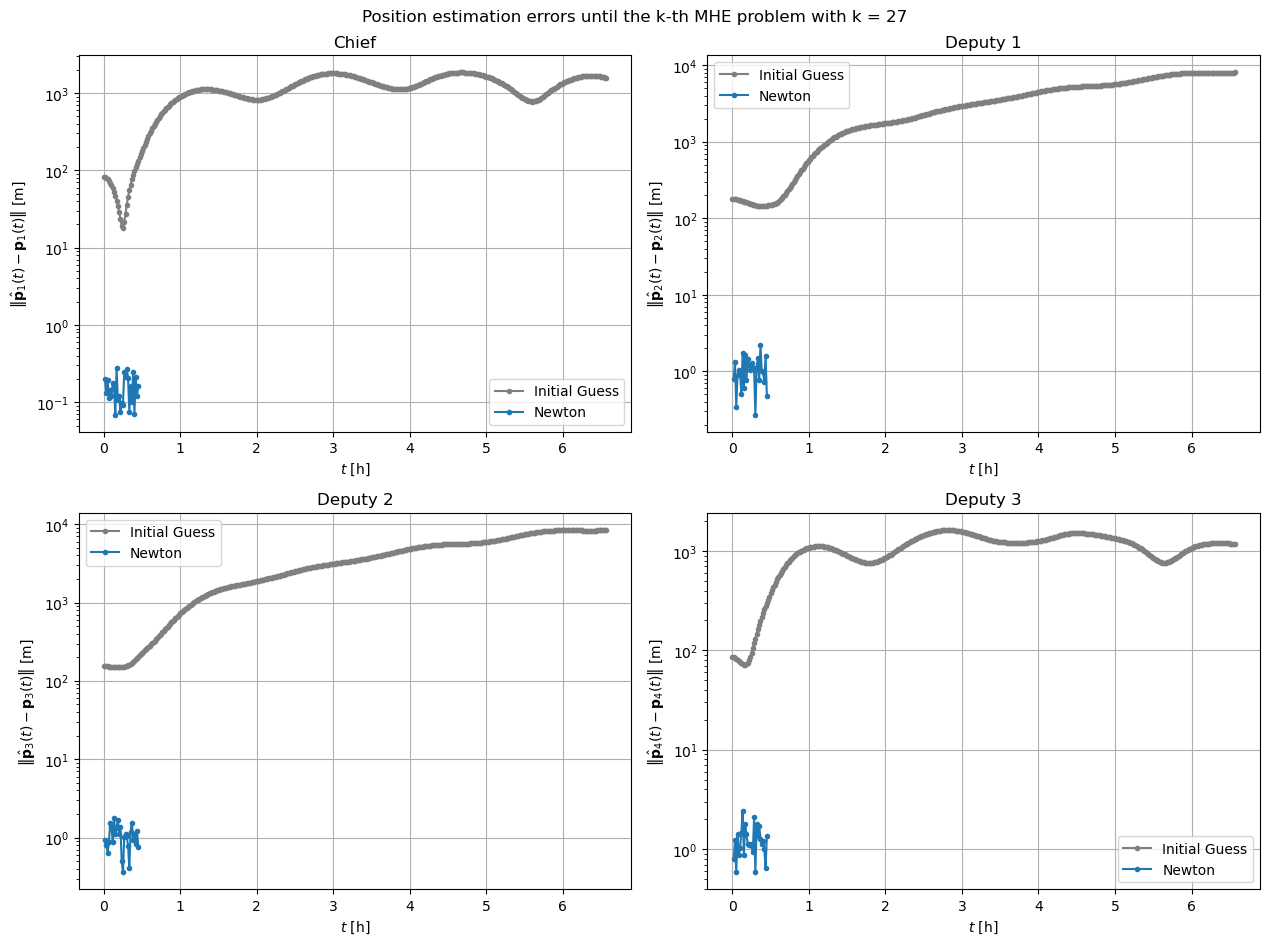

Windows:   7%|▋         | 27/394 [08:35<2:50:38, 27.90s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 52.06858991391117
Gradient norm: 3430.5339632019172
Global estimation error: 1.6389627534484403
Spectral radius of inv(T) @ R: 0.6732026146759592
T minimum eigenvalue: 2.969179213581756
Initial conditions estimation errors: 0.16338398487310404 m, 0.48341952141844363 m, 0.7611589881931544 m, 1.357989412453367 m
Position estimation errors: 0.7396717623793979 m, 2.5453914462488014 m, 1.979123354719484 m, 2.611493917941197 m
Iteration 0.0
Newton direction error: 0.053694282664668906 in 0.09223924163519522
Iteration 0.1
Newton direction error: 0.0346736256980187 in 0.09223924163519522
Iteration 0.2
Newton direction error: 0.023092668888687648 in 0.09223924163519522

[Centralized Newton] Iteration 1
Cost function: 8.275335282739196 (-84.11%)
Gradient norm: 85.10278289291062 (-97.52%)
Global estimation error: 1.6390693102259295 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144632509
T minimum eigenvalue: 2.969179212761504
Ini

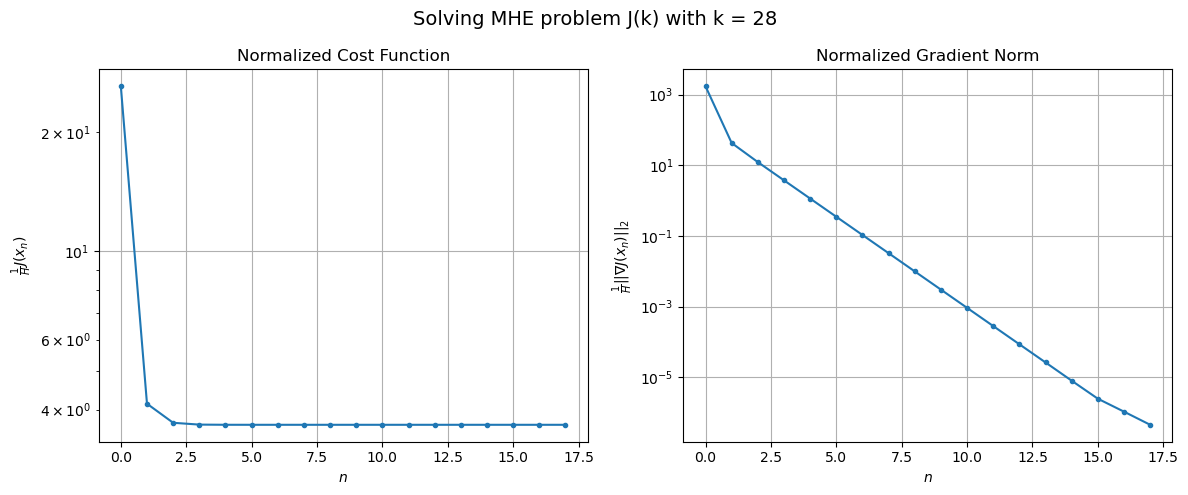

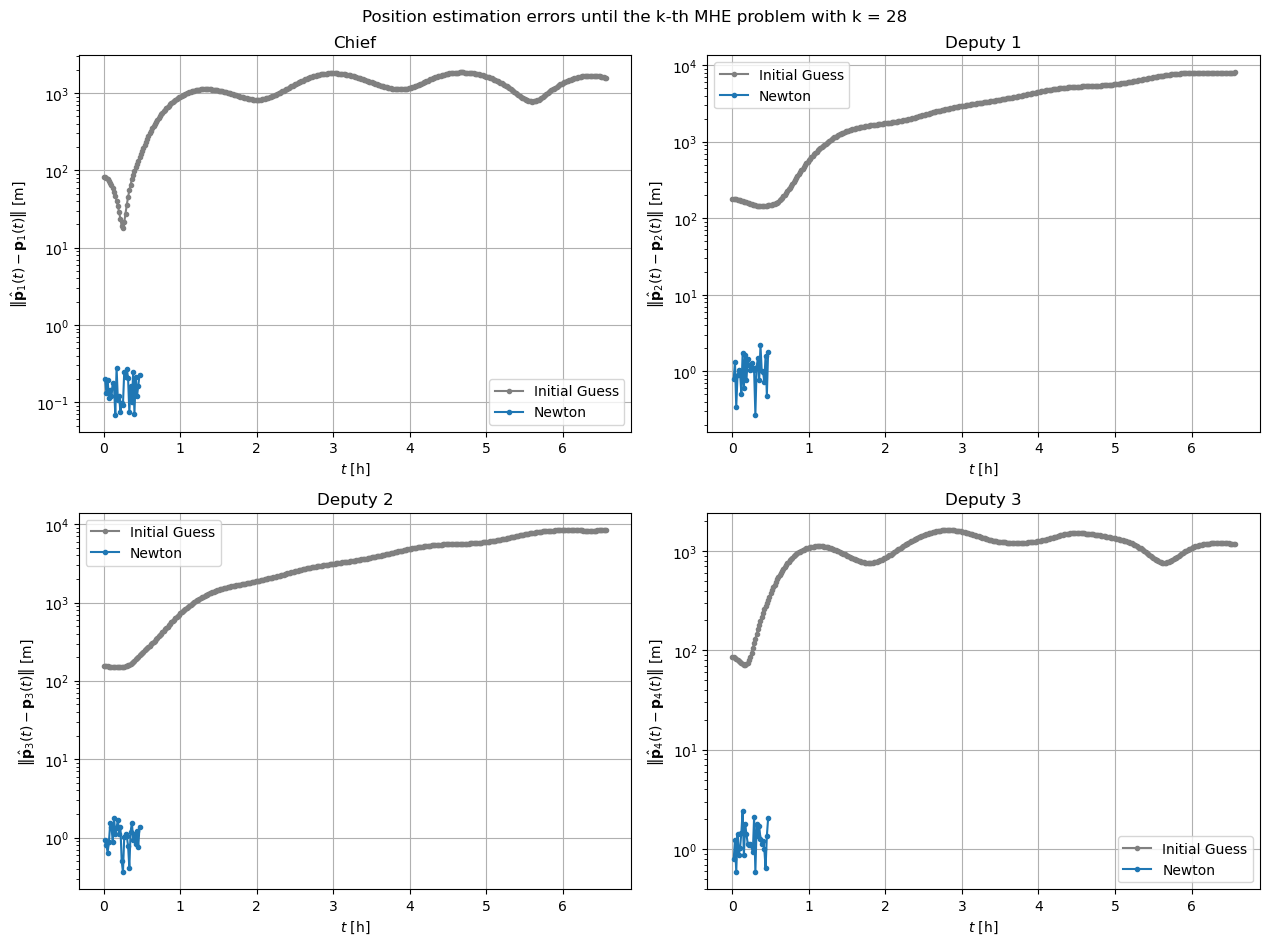

Windows:   7%|▋         | 28/394 [09:04<2:52:49, 28.33s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 166.09832419795737
Gradient norm: 9006.046688957262
Global estimation error: 3.0813131121400716
Spectral radius of inv(T) @ R: 0.6732026151673652
T minimum eigenvalue: 2.9691792092398477
Initial conditions estimation errors: 0.2286684760896252 m, 1.8198404285275407 m, 1.3825671502232368 m, 2.0528373865887515 m
Position estimation errors: 1.3741563247275033 m, 3.5457537023931023 m, 2.3695319788029607 m, 5.345576847934675 m
Iteration 0.0
Newton direction error: 0.08014355522161486 in 0.13163812328967975
Iteration 0.1
Newton direction error: 0.0527448568863418 in 0.13163812328967975
Iteration 0.2
Newton direction error: 0.03530571974660002 in 0.13163812328967975

[Centralized Newton] Iteration 1
Cost function: 12.198019901852721 (-92.66%)
Gradient norm: 127.1561540521928 (-98.59%)
Global estimation error: 3.080885363862421 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026146206335
T minimum eigenvalue: 2.969179211083121
Ini

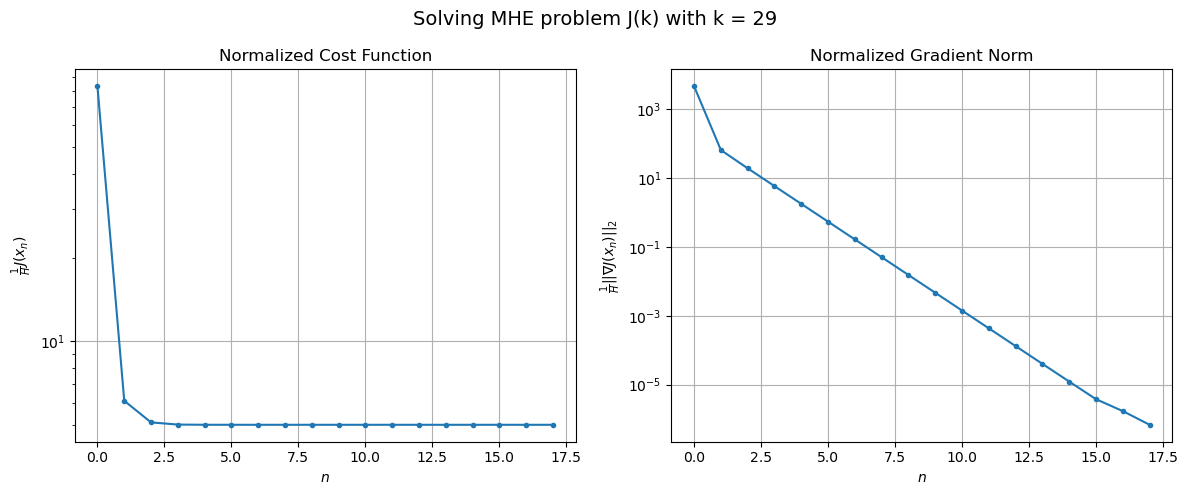

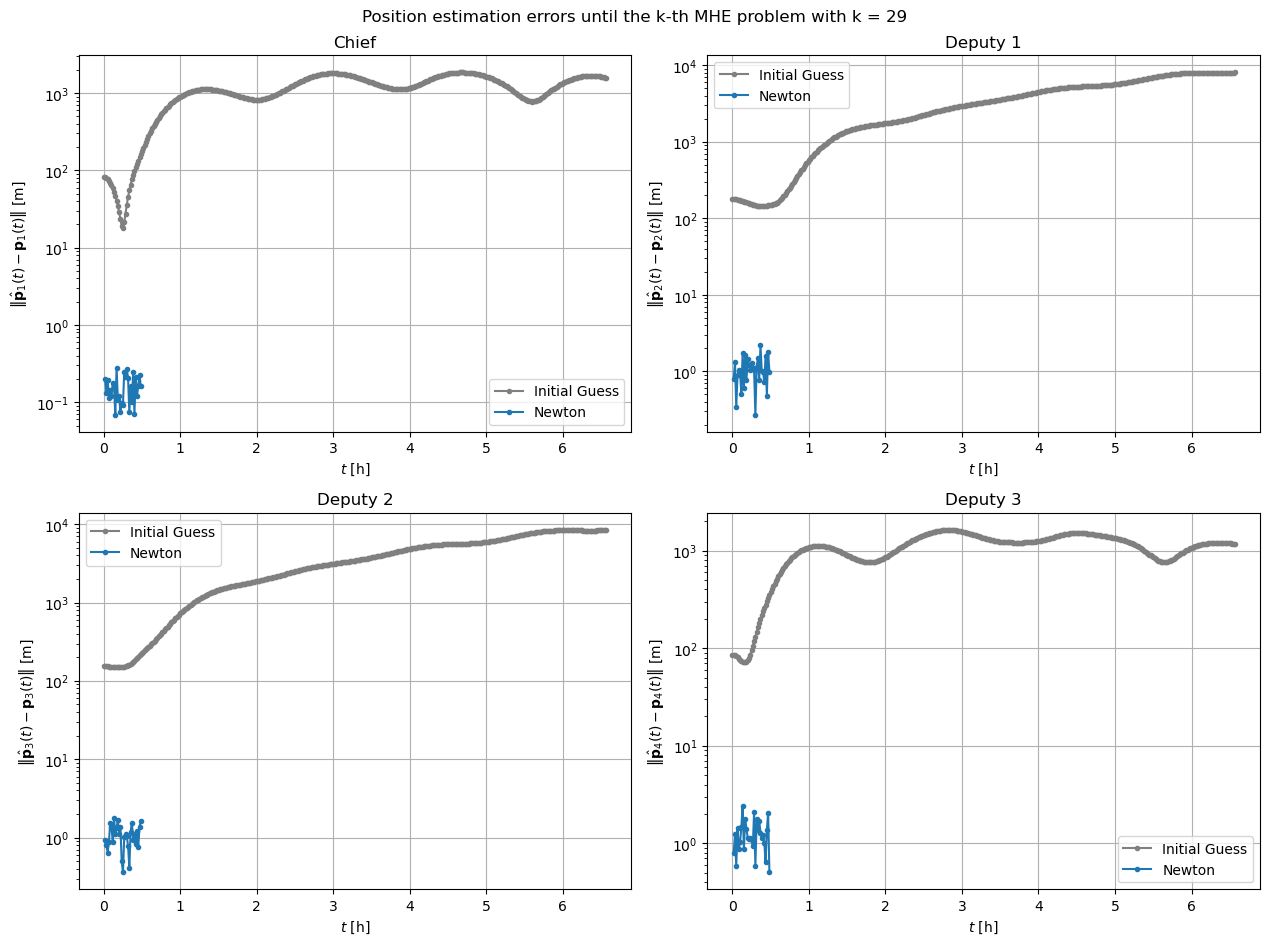

Windows:   7%|▋         | 29/394 [09:31<2:51:04, 28.12s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 83.2389337350138
Gradient norm: 4352.025132278473
Global estimation error: 1.9657616573143701
Spectral radius of inv(T) @ R: 0.6732026147042481
T minimum eigenvalue: 2.9691792111830404
Initial conditions estimation errors: 0.1601826921317282 m, 0.9761317997812732 m, 1.6202941129859667 m, 0.5045345470173999 m
Position estimation errors: 0.8885660750680229 m, 3.9834903482141173 m, 4.361093758308332 m, 2.8063841321921488 m
Iteration 0.0
Newton direction error: 0.06459613414971443 in 0.11151627156488254
Iteration 0.1
Newton direction error: 0.04166621242223105 in 0.11151627156488254
Iteration 0.2
Newton direction error: 0.02774112520726731 in 0.11151627156488254

[Centralized Newton] Iteration 1
Cost function: 16.691543821926338 (-79.95%)
Gradient norm: 102.31981848652252 (-97.65%)
Global estimation error: 1.9648384021359648 (-0.05%)
Spectral radius of inv(T) @ R: 0.673202614482677
T minimum eigenvalue: 2.969179211291522
Ini

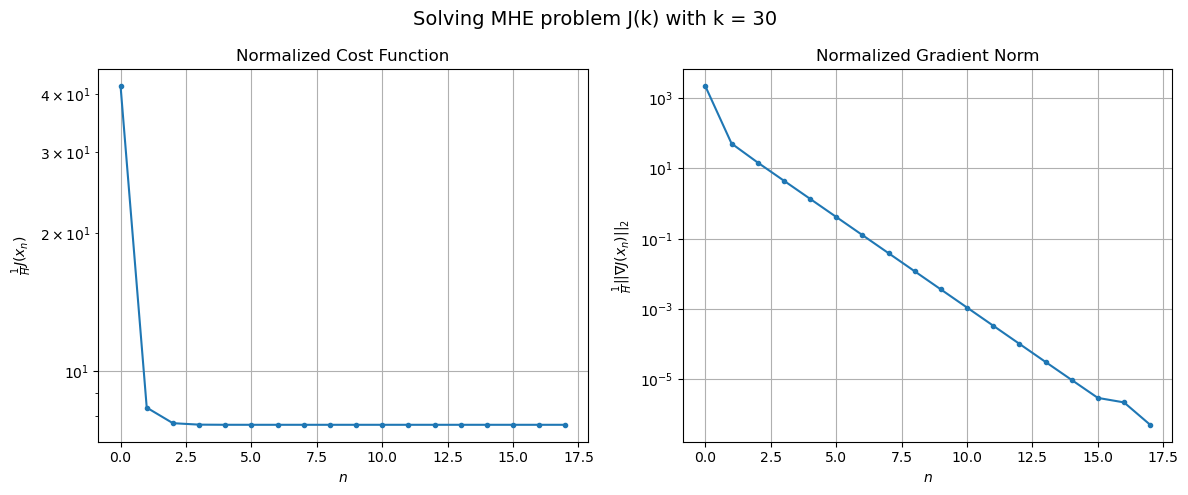

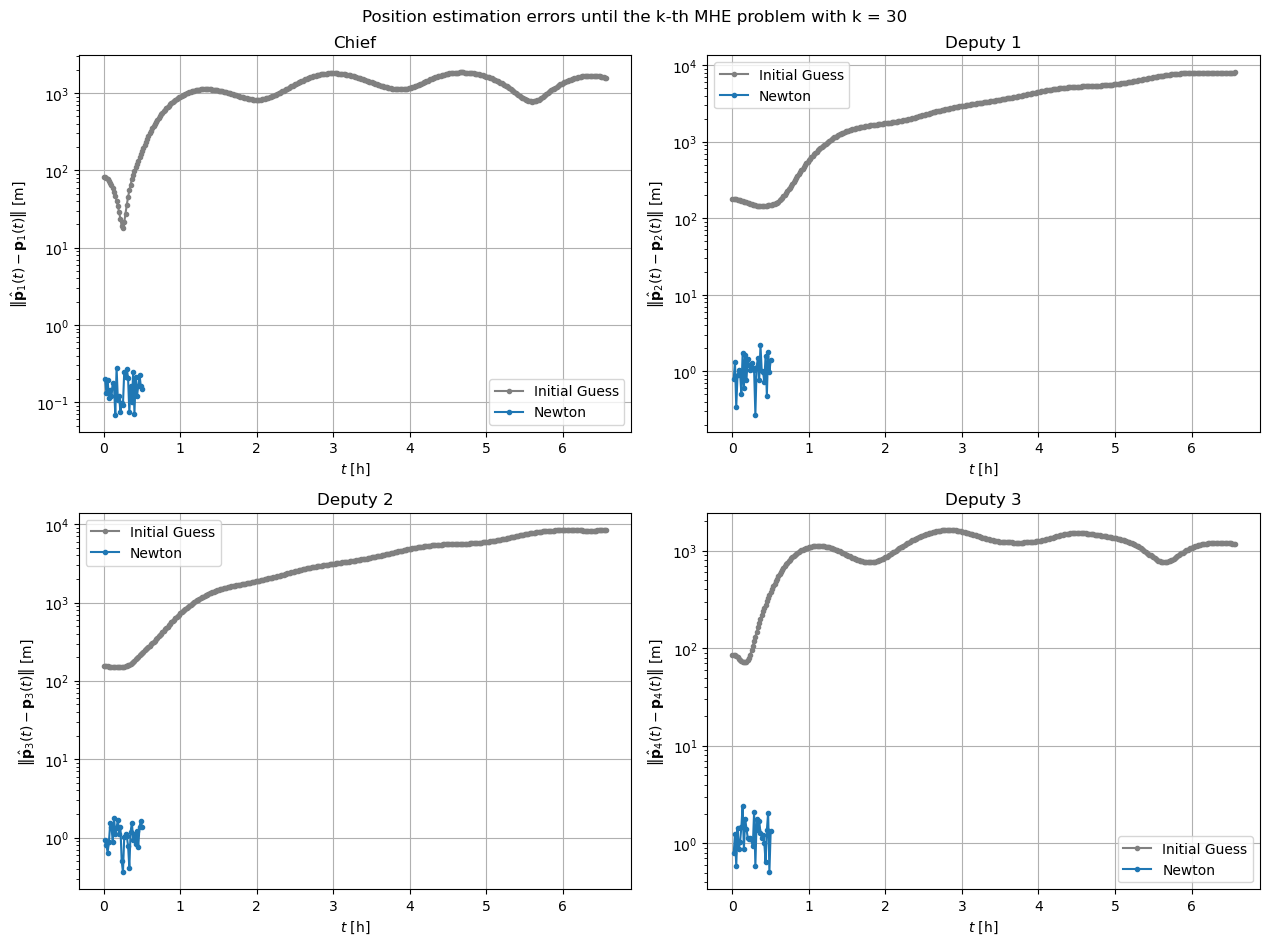

Windows:   8%|▊         | 30/394 [10:02<2:55:34, 28.94s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 109.54824278524417
Gradient norm: 7001.047089655113
Global estimation error: 2.3791712810432073
Spectral radius of inv(T) @ R: 0.6732026147823774
T minimum eigenvalue: 2.9691792125187546
Initial conditions estimation errors: 0.14954906426956552 m, 1.409854500199377 m, 1.3722453299944766 m, 1.3281329185313078 m
Position estimation errors: 1.1583794592516867 m, 3.290111508704003 m, 4.305169672909547 m, 2.6592285889244045 m
Iteration 0.0
Newton direction error: 0.07333823232120434 in 0.11585470374279695
Iteration 0.1
Newton direction error: 0.04876187866137252 in 0.11585470374279695
Iteration 0.2
Newton direction error: 0.03272523639433072 in 0.11585470374279695

[Centralized Newton] Iteration 1
Cost function: 14.53107949707577 (-86.74%)
Gradient norm: 116.46749727428576 (-98.34%)
Global estimation error: 2.378778043689995 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026145095545
T minimum eigenvalue: 2.969179210945405
Ini

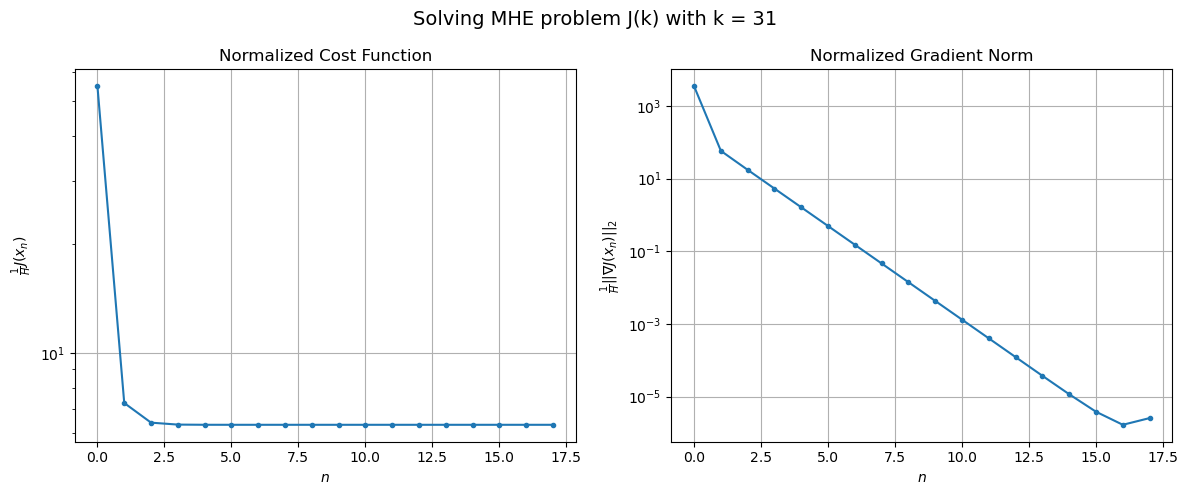

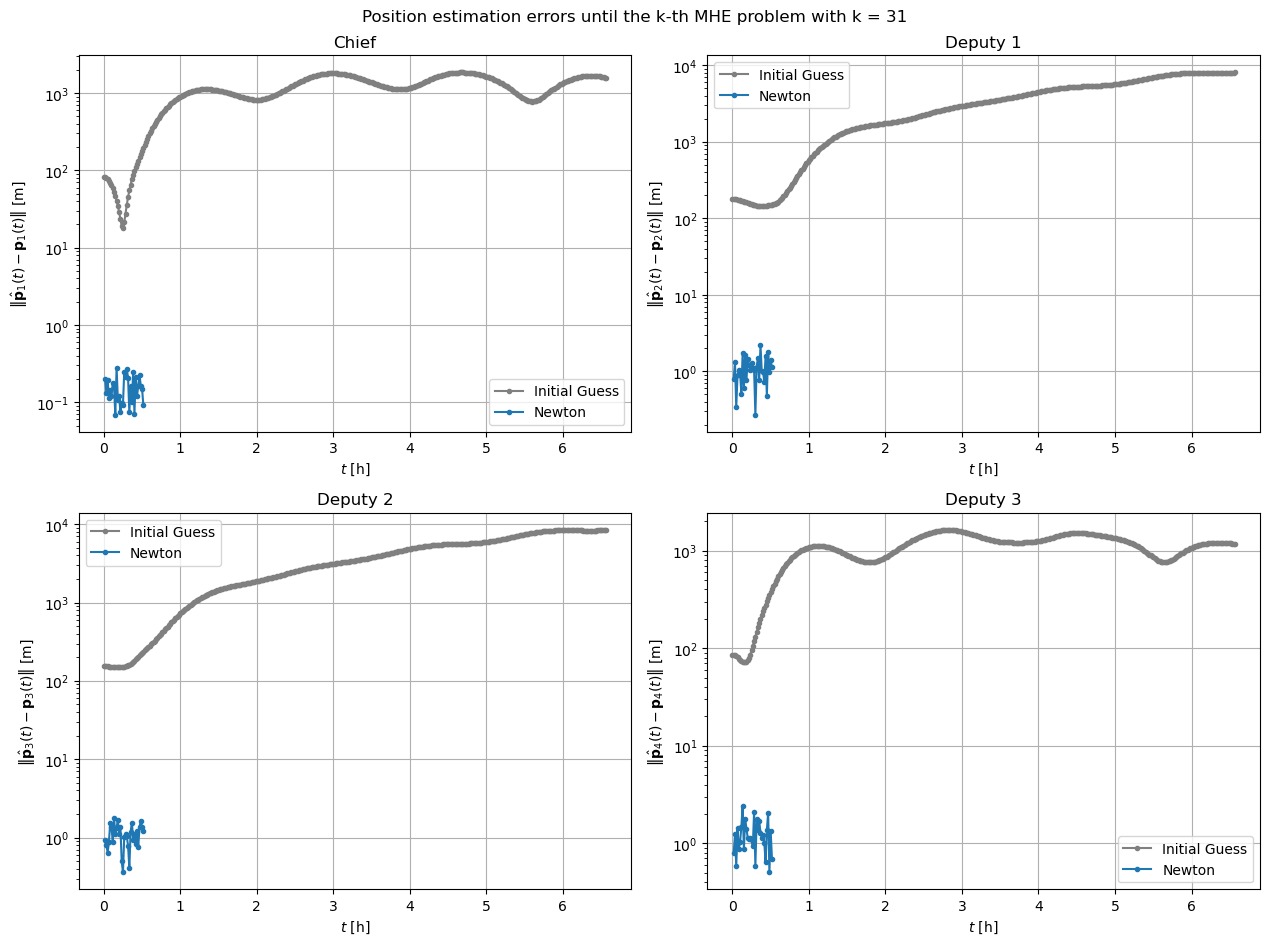

Windows:   8%|▊         | 31/394 [10:30<2:52:50, 28.57s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 74.38993150867852
Gradient norm: 5524.488431296479
Global estimation error: 1.7943957782129207
Spectral radius of inv(T) @ R: 0.6732026148606299
T minimum eigenvalue: 2.9691792076477634
Initial conditions estimation errors: 0.09093760367459022 m, 1.1352558507606094 m, 1.1980771903315377 m, 0.6958993818204975 m
Position estimation errors: 0.8875619388643878 m, 3.043346740118051 m, 2.814414437854038 m, 2.22786590440555 m
Iteration 0.0
Newton direction error: 0.06205400401168704 in 0.09904852358580091
Iteration 0.1
Newton direction error: 0.04110768419469443 in 0.09904852358580091
Iteration 0.2
Newton direction error: 0.027562584734401076 in 0.09904852358580091

[Centralized Newton] Iteration 1
Cost function: 10.558979850744768 (-85.81%)
Gradient norm: 98.21114925473314 (-98.22%)
Global estimation error: 1.7941185396455188 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144969757
T minimum eigenvalue: 2.9691792086240207
In

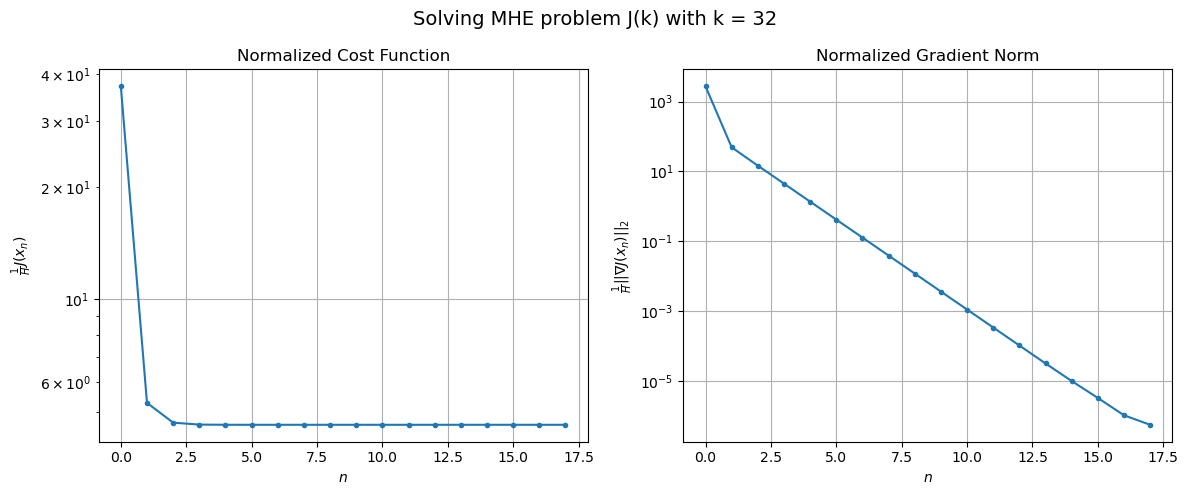

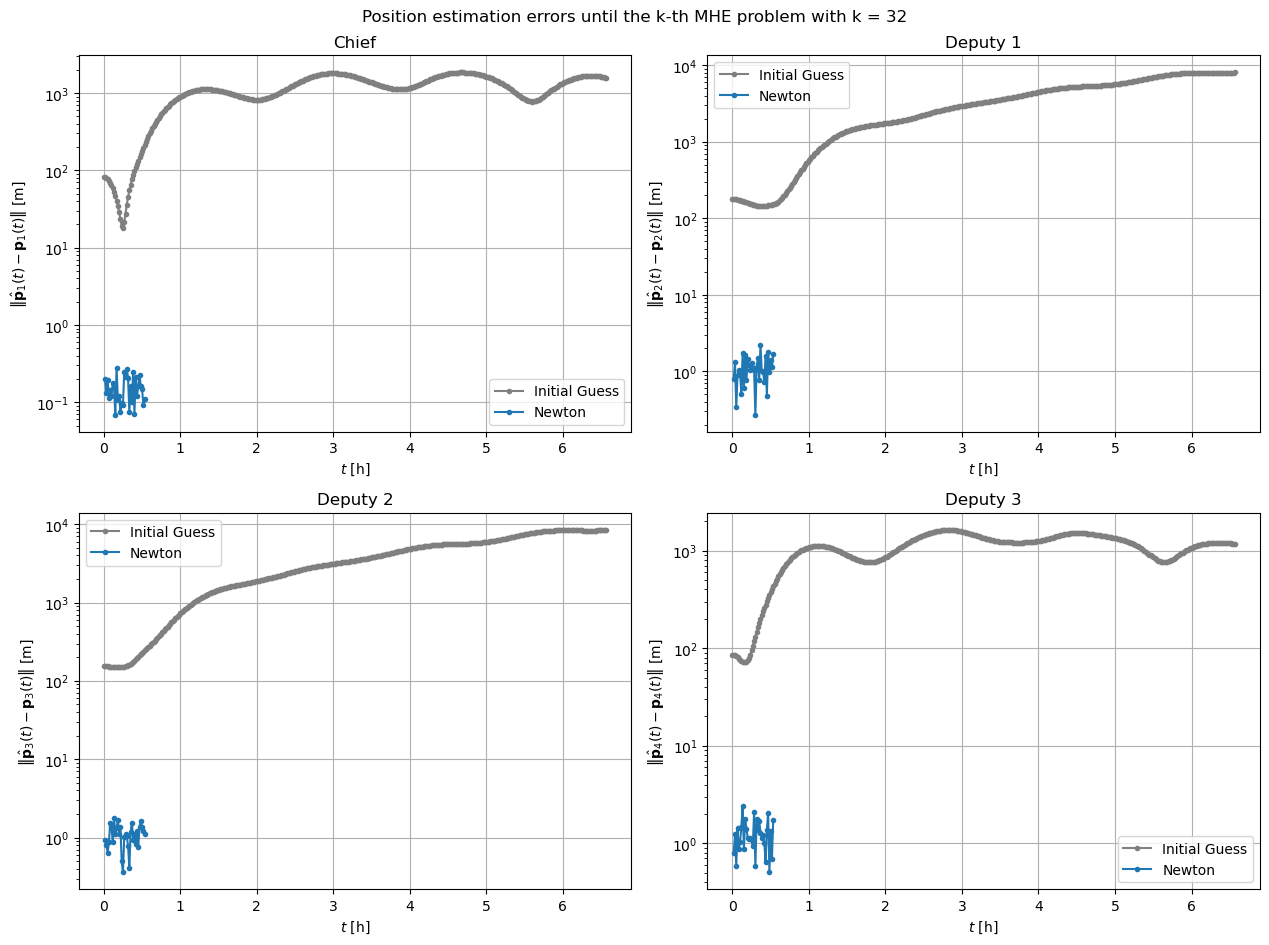

Windows:   8%|▊         | 32/394 [10:43<2:24:01, 23.87s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 55.22903857848824
Gradient norm: 5156.462460458377
Global estimation error: 2.67115316218162
Spectral radius of inv(T) @ R: 0.6732026148015722
T minimum eigenvalue: 2.9691792061676887
Initial conditions estimation errors: 0.11098375413594198 m, 1.703686720665212 m, 1.1018305523461447 m, 1.7329227508188954 m
Position estimation errors: 0.7319335808579241 m, 3.3920584319000575 m, 2.204462647140727 m, 3.8998840065972153 m
Iteration 0.0
Newton direction error: 0.046849863765928375 in 0.07355618637355867
Iteration 0.1
Newton direction error: 0.031228294235491786 in 0.07355618637355867
Iteration 0.2
Newton direction error: 0.020971297448265733 in 0.07355618637355867

[Centralized Newton] Iteration 1
Cost function: 8.567305740500137 (-84.49%)
Gradient norm: 74.12667539604462 (-98.56%)
Global estimation error: 2.6706392651283646 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144707559
T minimum eigenvalue: 2.9691792070945797
I

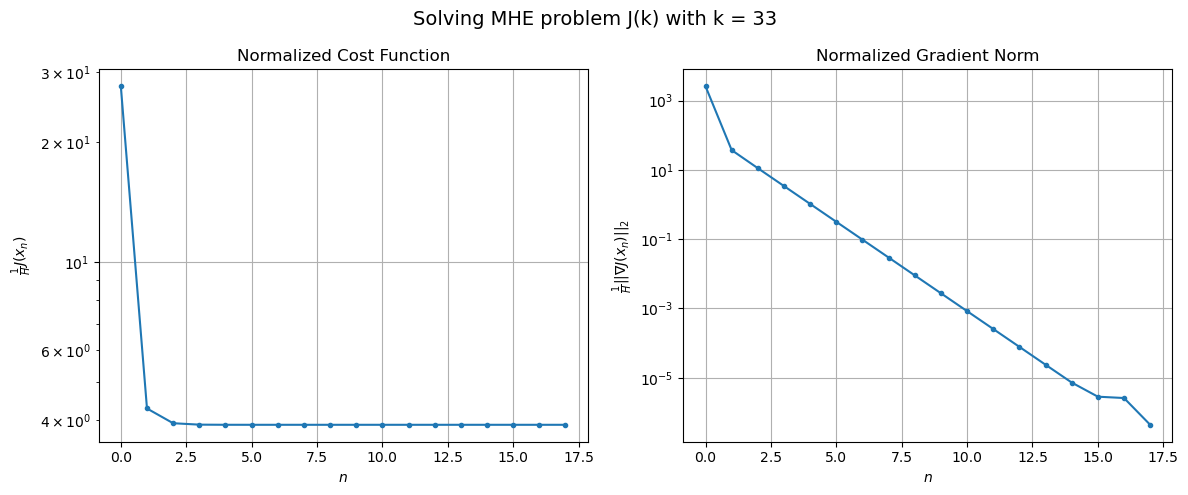

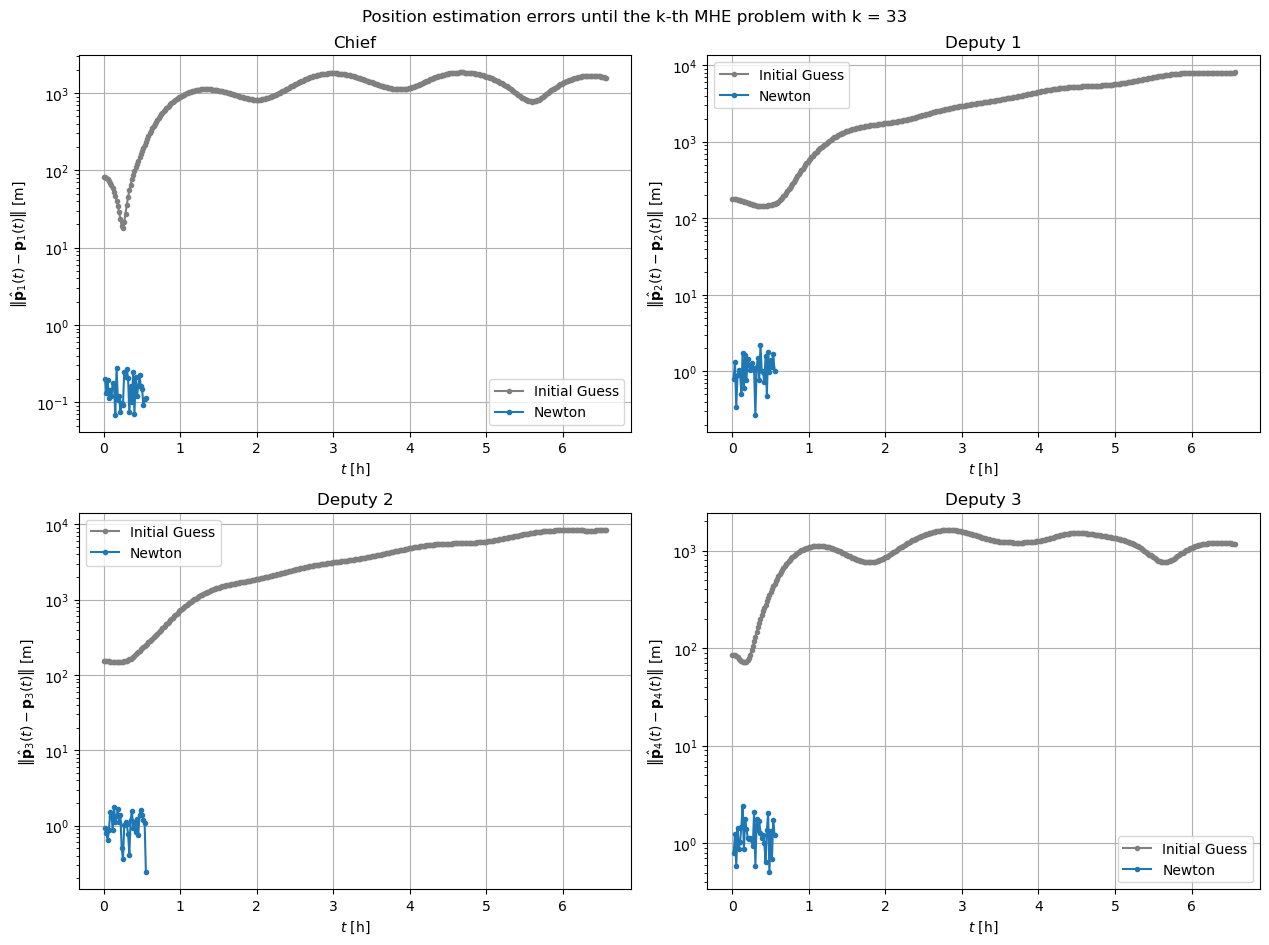

Windows:   8%|▊         | 33/394 [10:56<2:04:09, 20.63s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 34.99704910502424
Gradient norm: 3353.281783773187
Global estimation error: 1.6227944765067628
Spectral radius of inv(T) @ R: 0.6732026144671214
T minimum eigenvalue: 2.9691792056628397
Initial conditions estimation errors: 0.11200808800678172 m, 1.0258501575049346 m, 0.24070787597799811 m, 1.2285118729505868 m
Position estimation errors: 0.6135150084449713 m, 2.2329146872706267 m, 1.3516360448347535 m, 1.1471571301183536 m
Iteration 0.0
Newton direction error: 0.018534064578274487 in 0.04079396586906815
Iteration 0.1
Newton direction error: 0.010685340140994993 in 0.04079396586906815
Iteration 0.2
Newton direction error: 0.006865382369045245 in 0.04079396586906815

[Centralized Newton] Iteration 1
Cost function: 11.542088422656867 (-67.02%)
Gradient norm: 29.4662319660573 (-99.12%)
Global estimation error: 1.622705782048646 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144043739
T minimum eigenvalue: 2.96917920568553

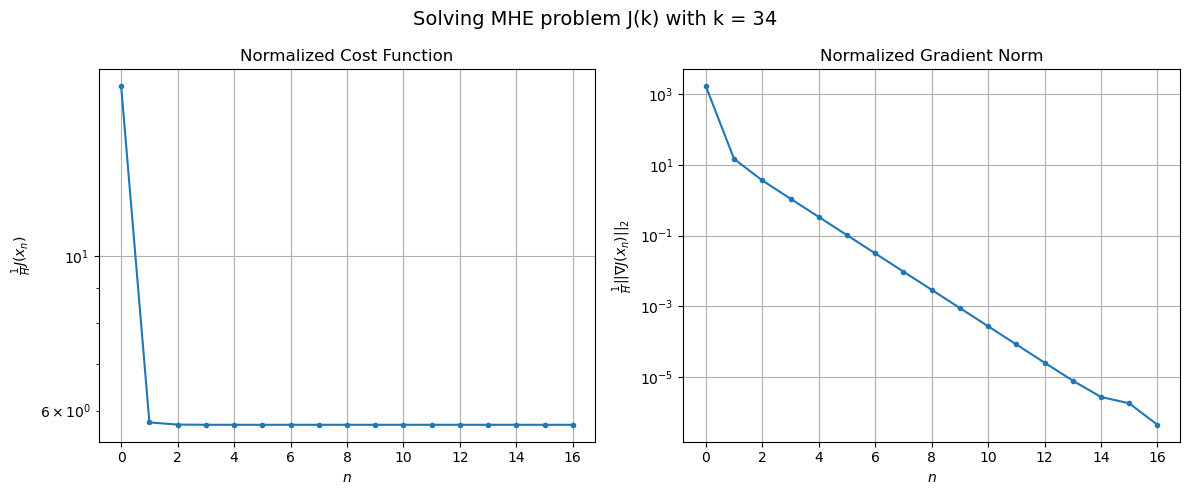

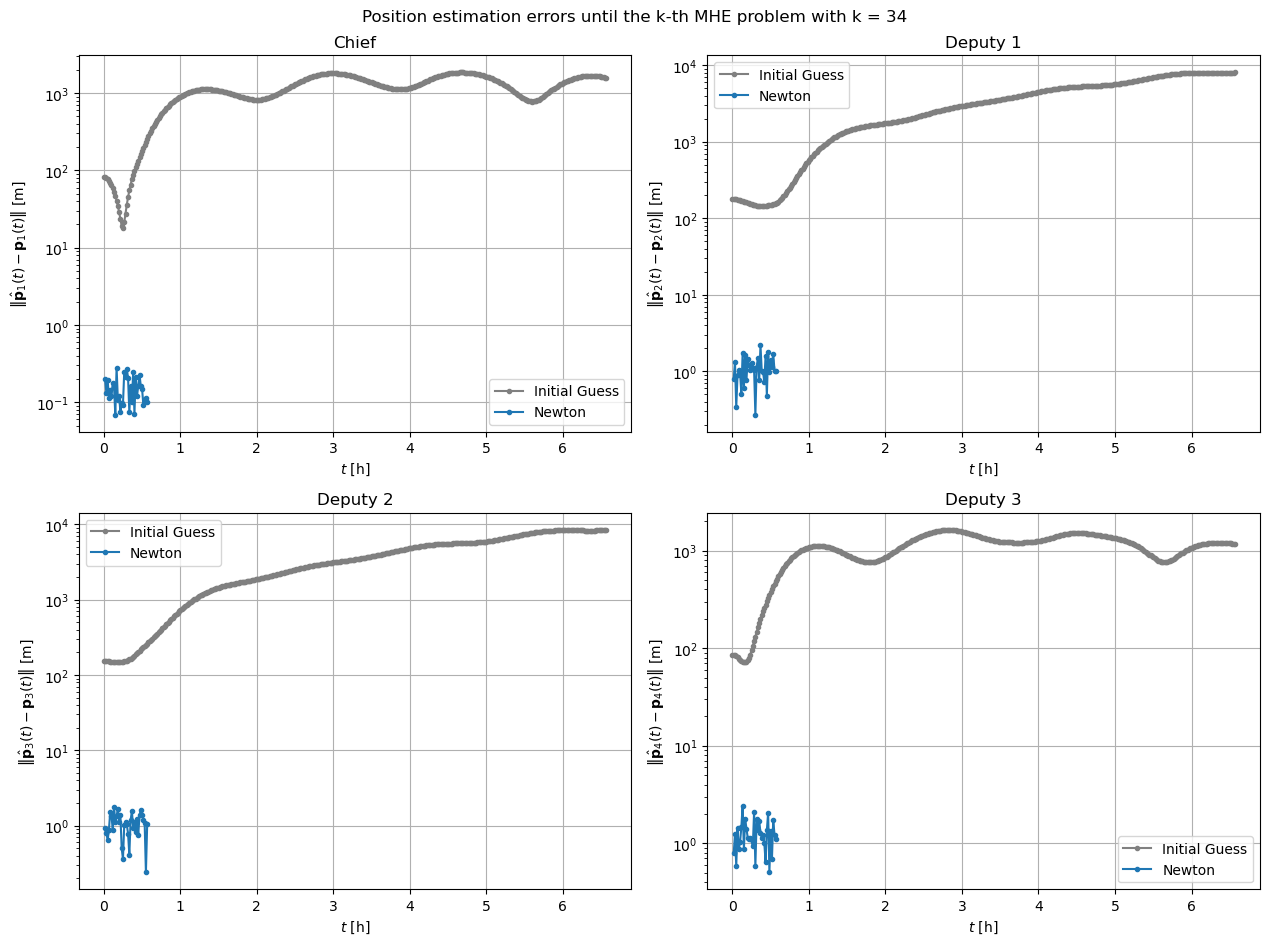

Windows:   9%|▊         | 34/394 [11:09<1:50:35, 18.43s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 71.63756039370065
Gradient norm: 4451.086744823929
Global estimation error: 1.841288523246265
Spectral radius of inv(T) @ R: 0.6732026145143771
T minimum eigenvalue: 2.969179204693178
Initial conditions estimation errors: 0.1007127113370436 m, 1.022744175204005 m, 1.052435705573443 m, 1.1068622356765012 m
Position estimation errors: 0.689710339154222 m, 1.9670781493839067 m, 2.791611618789501 m, 2.1224342260816136 m
Iteration 0.0
Newton direction error: 0.04038850269233798 in 0.08252134287132586
Iteration 0.1
Newton direction error: 0.024195997523380884 in 0.08252134287132586
Iteration 0.2
Newton direction error: 0.015755407592053704 in 0.08252134287132586

[Centralized Newton] Iteration 1
Cost function: 12.90326935433415 (-81.99%)
Gradient norm: 64.28344606369278 (-98.56%)
Global estimation error: 1.8415454569929857 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026144429296
T minimum eigenvalue: 2.9691792041745186
Initia

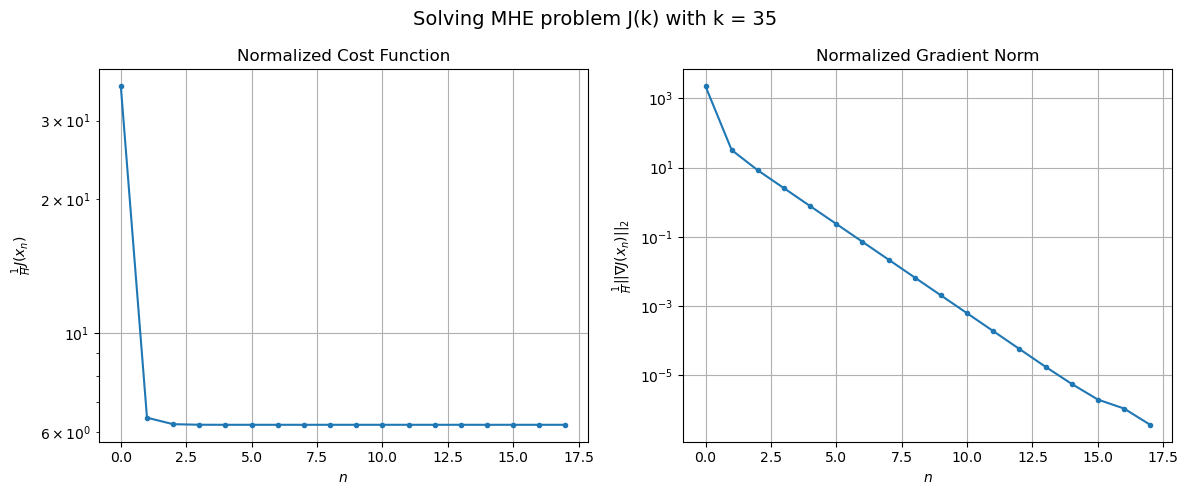

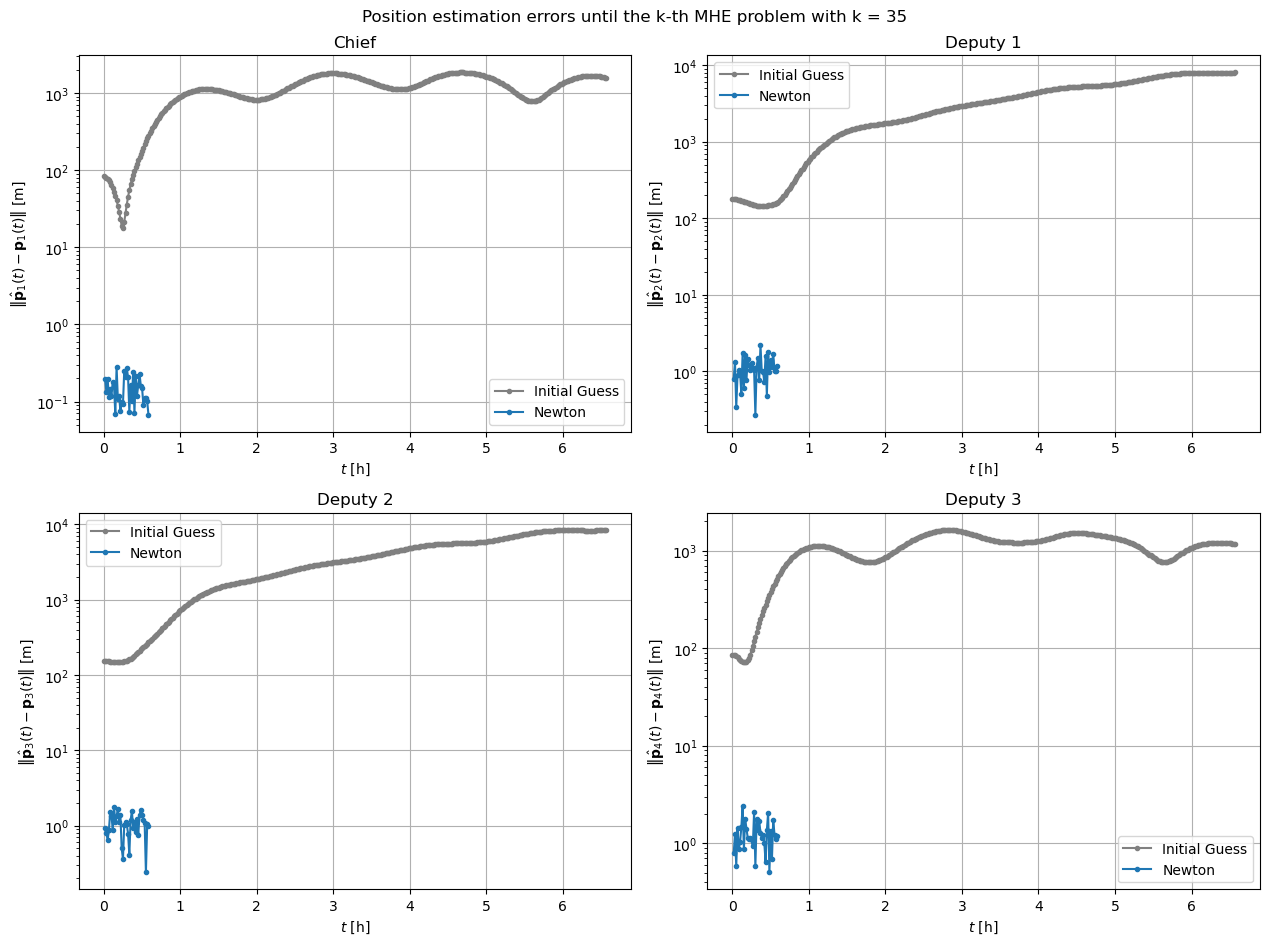

Windows:   9%|▉         | 35/394 [11:22<1:39:06, 16.56s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 55.750270020154886
Gradient norm: 2065.3117024102457
Global estimation error: 1.944190005040147
Spectral radius of inv(T) @ R: 0.6732026144114087
T minimum eigenvalue: 2.9691792019163668
Initial conditions estimation errors: 0.06723389489883816 m, 1.188502837144046 m, 0.9831091834762363 m, 1.180711273301387 m
Position estimation errors: 0.27190746358603174 m, 2.446029586558883 m, 2.4943754518349617 m, 2.9328001062641977 m
Iteration 0.0
Newton direction error: 0.02664138774169981 in 0.07918531942398026
Iteration 0.1
Newton direction error: 0.009267432878041933 in 0.07918531942398026
Iteration 0.2
Newton direction error: 0.003567296263618857 in 0.07918531942398026

[Centralized Newton] Iteration 1
Cost function: 7.045093243545363 (-87.36%)
Gradient norm: 42.63661279879947 (-97.94%)
Global estimation error: 1.9440560781432066 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026143872326
T minimum eigenvalue: 2.9691792018763903

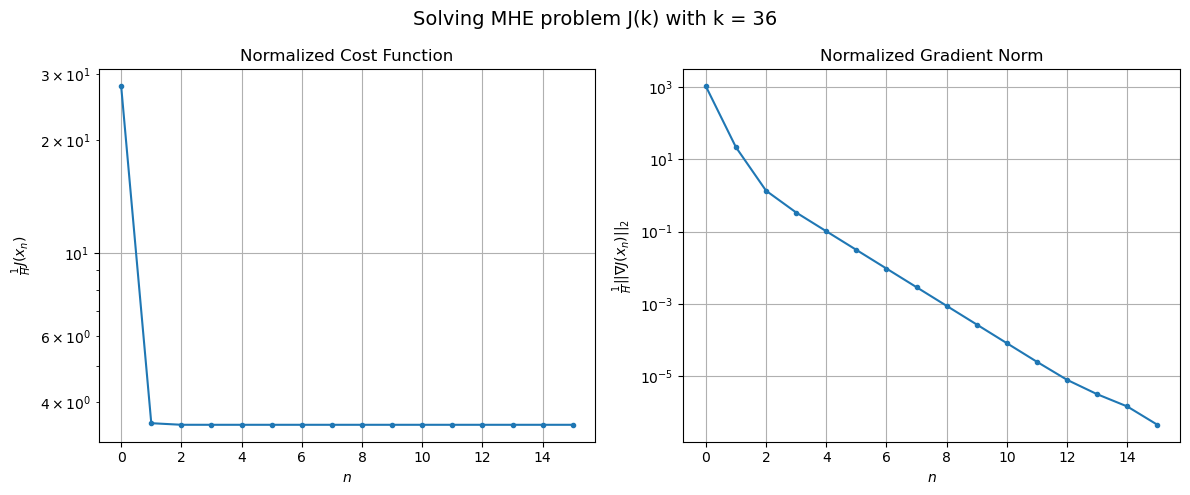

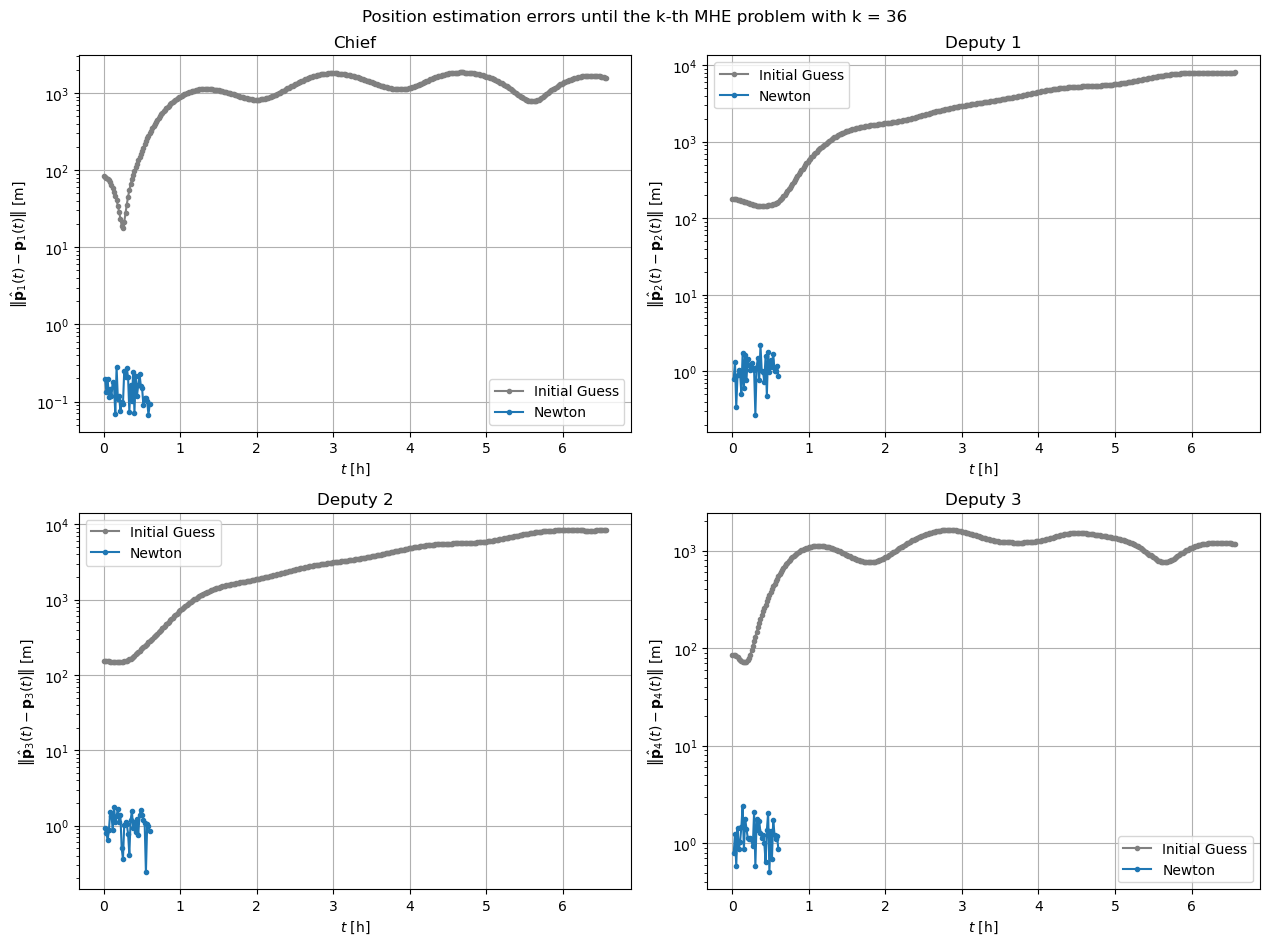

Windows:   9%|▉         | 36/394 [11:33<1:29:08, 14.94s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 24.926322398633232
Gradient norm: 1593.0759838531237
Global estimation error: 1.5031195143774254
Spectral radius of inv(T) @ R: 0.6732026145580682
T minimum eigenvalue: 2.9691791992358474
Initial conditions estimation errors: 0.09391825524567486 m, 0.8740873921171012 m, 0.8449519732834021 m, 0.8781574630491314 m
Position estimation errors: 0.25216762980900387 m, 0.7353920498870691 m, 1.9964421975553945 m, 2.478257436796979 m
Iteration 0.0
Newton direction error: 0.02324185623651423 in 0.052110763900717304
Iteration 0.1
Newton direction error: 0.012994881682488902 in 0.052110763900717304
Iteration 0.2
Newton direction error: 0.008251802791730186 in 0.052110763900717304

[Centralized Newton] Iteration 1
Cost function: 6.608608167665226 (-73.49%)
Gradient norm: 36.95580899004169 (-97.68%)
Global estimation error: 1.5029084308741214 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026144260672
T minimum eigenvalue: 2.9691791997

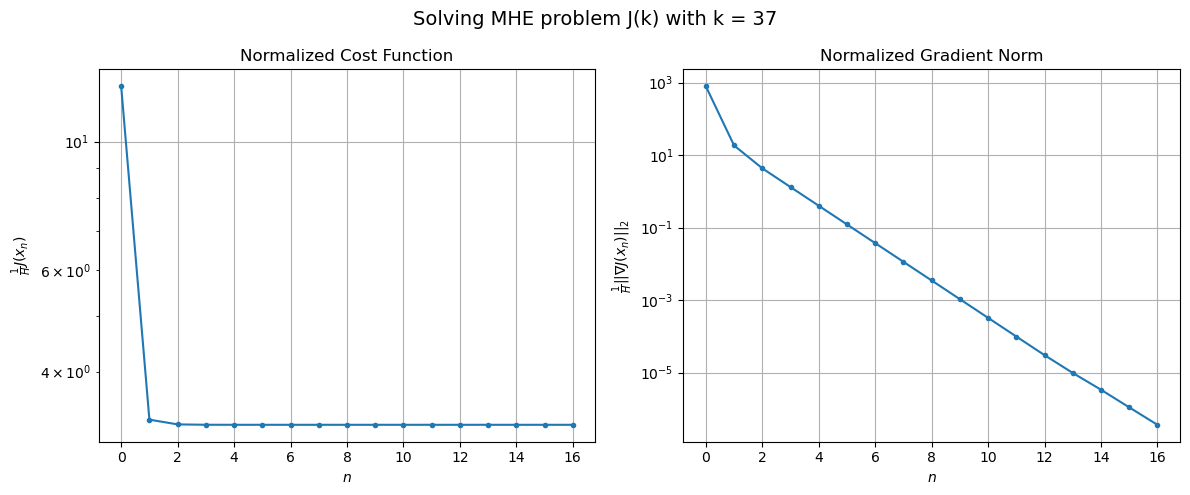

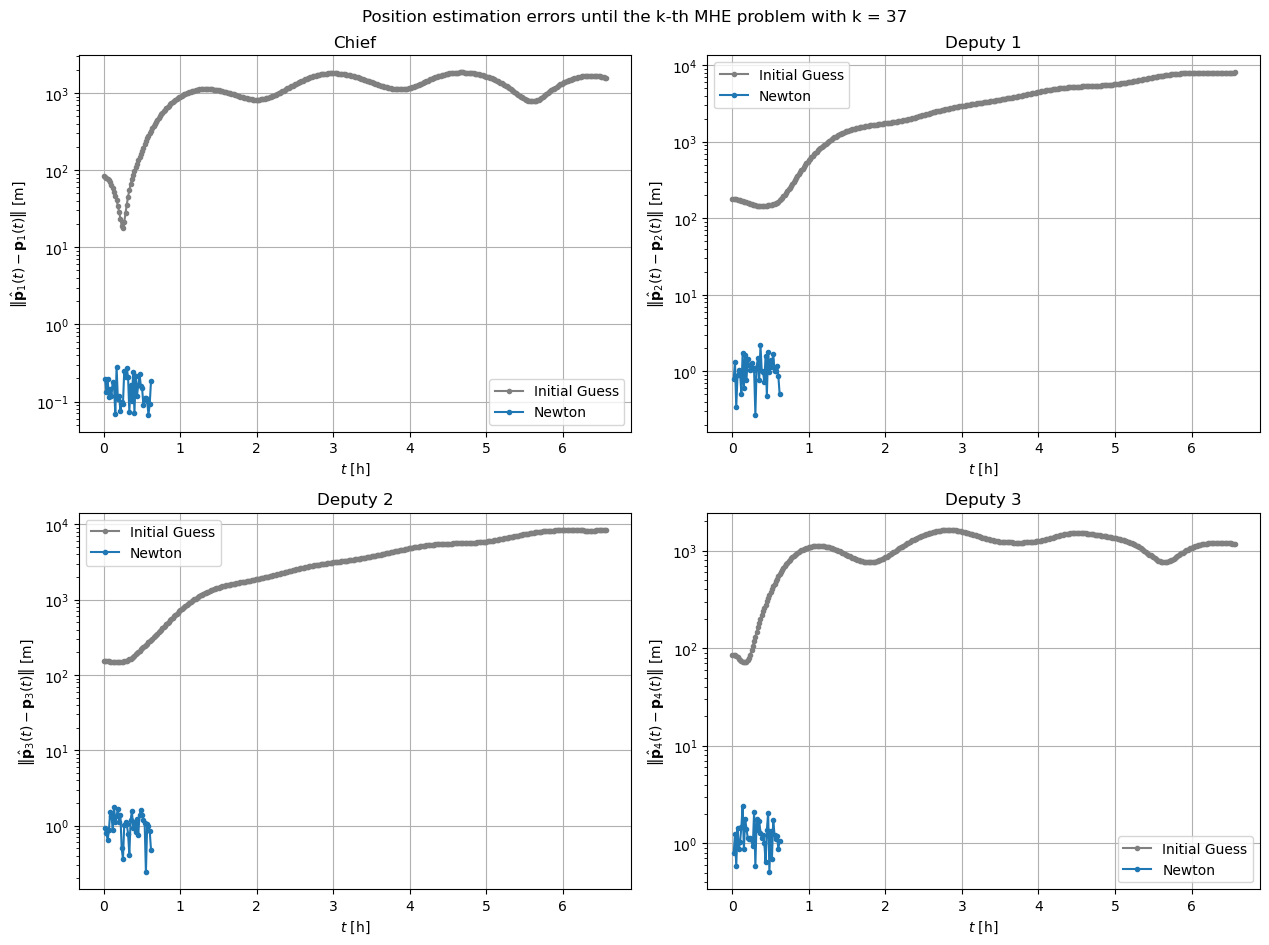

Windows:   9%|▉         | 37/394 [11:45<1:23:41, 14.07s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 41.26774064413975
Gradient norm: 3047.852059844792
Global estimation error: 1.2882069799145732
Spectral radius of inv(T) @ R: 0.6732026145832251
T minimum eigenvalue: 2.9691791972217447
Initial conditions estimation errors: 0.18409497475252082 m, 0.5139313912290584 m, 0.4746241659091208 m, 1.065552391139297 m
Position estimation errors: 0.4180836934480223 m, 1.4287203654265062 m, 1.5487403001187137 m, 1.2736185684195125 m
Iteration 0.0
Newton direction error: 0.026221234522498454 in 0.0602281357535948
Iteration 0.1
Newton direction error: 0.014438753225497602 in 0.0602281357535948
Iteration 0.2
Newton direction error: 0.009111772950541453 in 0.0602281357535948

[Centralized Newton] Iteration 1
Cost function: 8.66079328964933 (-79.01%)
Gradient norm: 41.70429102741103 (-98.63%)
Global estimation error: 1.2885170252490226 (0.02%)
Spectral radius of inv(T) @ R: 0.6732026144276921
T minimum eigenvalue: 2.9691791977785824
Ini

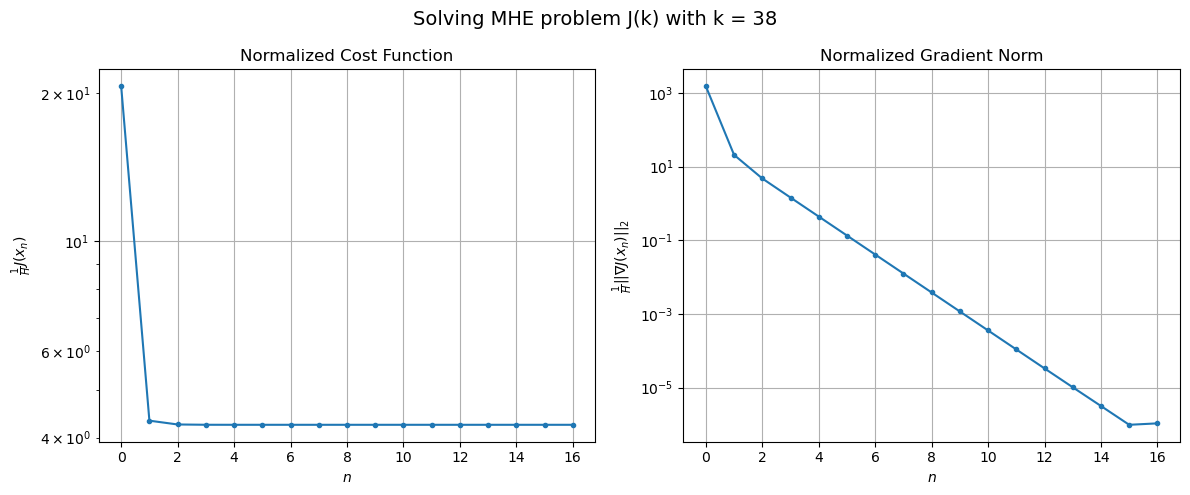

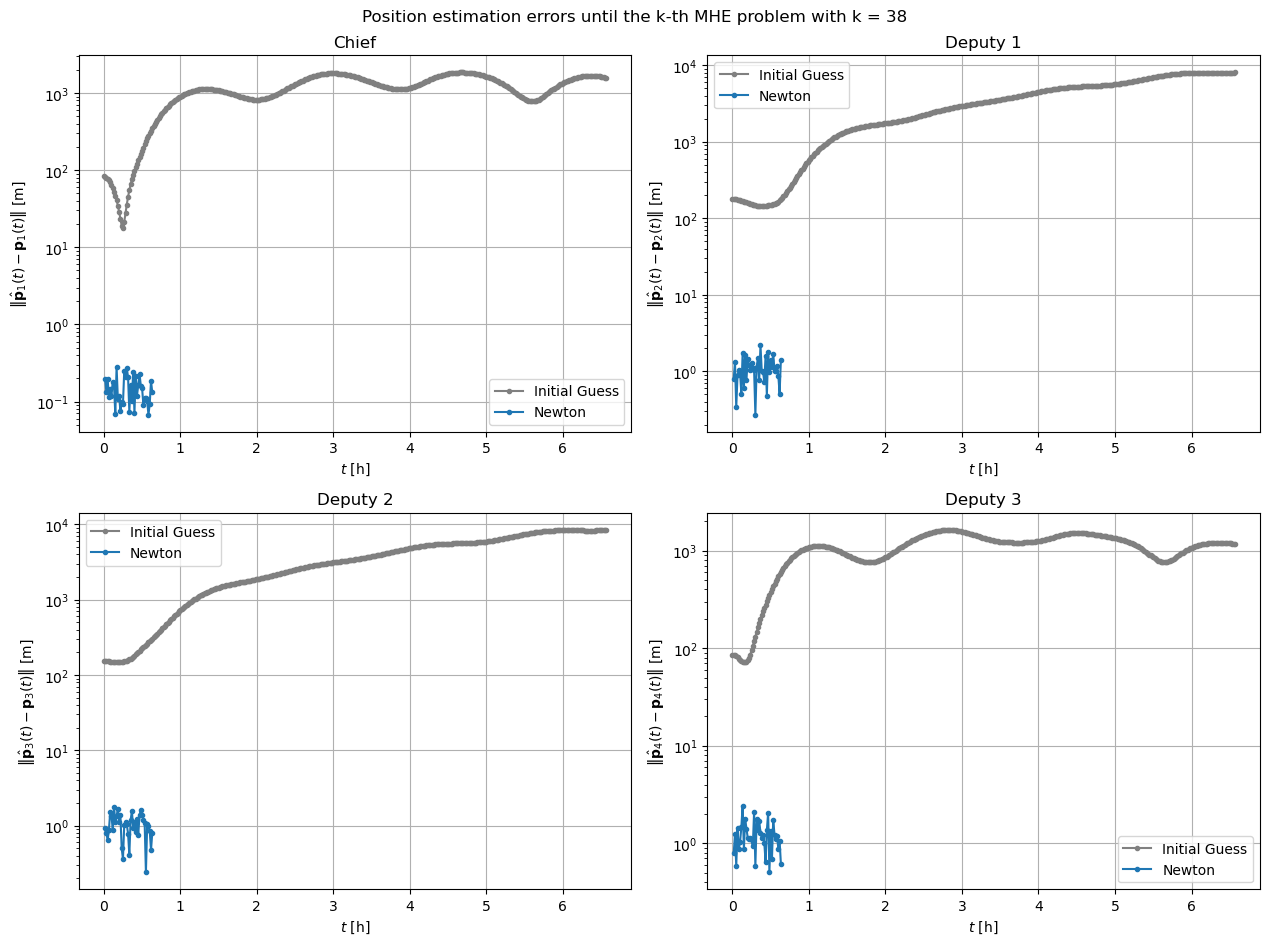

Windows:  10%|▉         | 38/394 [11:57<1:20:28, 13.56s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 58.92663096618383
Gradient norm: 4260.314643275571
Global estimation error: 1.748292721738428
Spectral radius of inv(T) @ R: 0.6732026146504017
T minimum eigenvalue: 2.969179197446377
Initial conditions estimation errors: 0.13108519099961558 m, 1.411393294560778 m, 0.8127438810437214 m, 0.6200447056078319 m
Position estimation errors: 0.5779762962666164 m, 3.4018958344661536 m, 2.0108582308260257 m, 2.458185059754673 m
Iteration 0.0
Newton direction error: 0.0616300260163204 in 0.09938160601924549
Iteration 0.1
Newton direction error: 0.04067060107000353 in 0.09938160601924549
Iteration 0.2
Newton direction error: 0.027242698504455407 in 0.09938160601924549

[Centralized Newton] Iteration 1
Cost function: 9.718373914329916 (-83.51%)
Gradient norm: 97.75016558008326 (-97.71%)
Global estimation error: 1.7479506369737394 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144822503
T minimum eigenvalue: 2.969179196512618
Initi

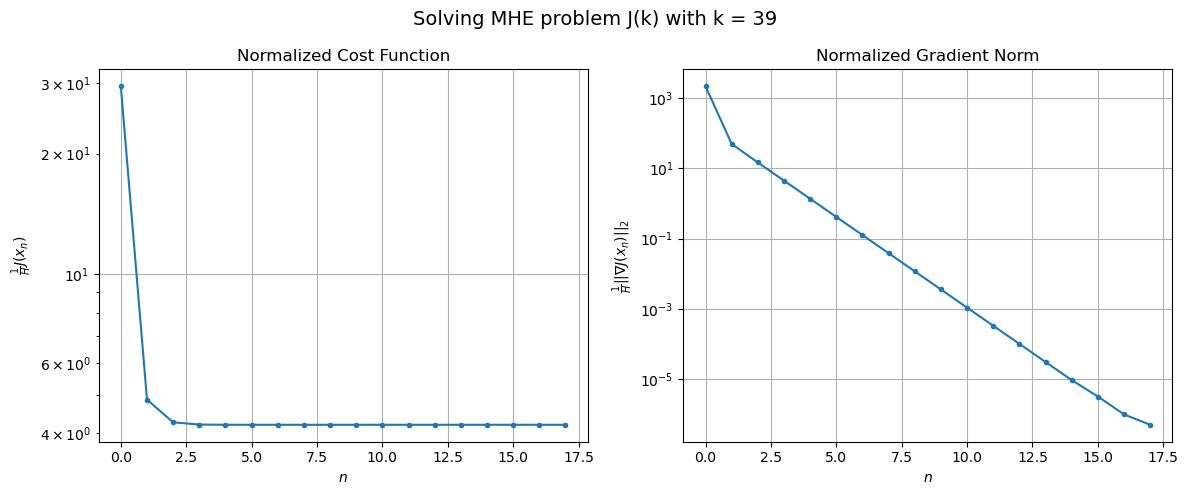

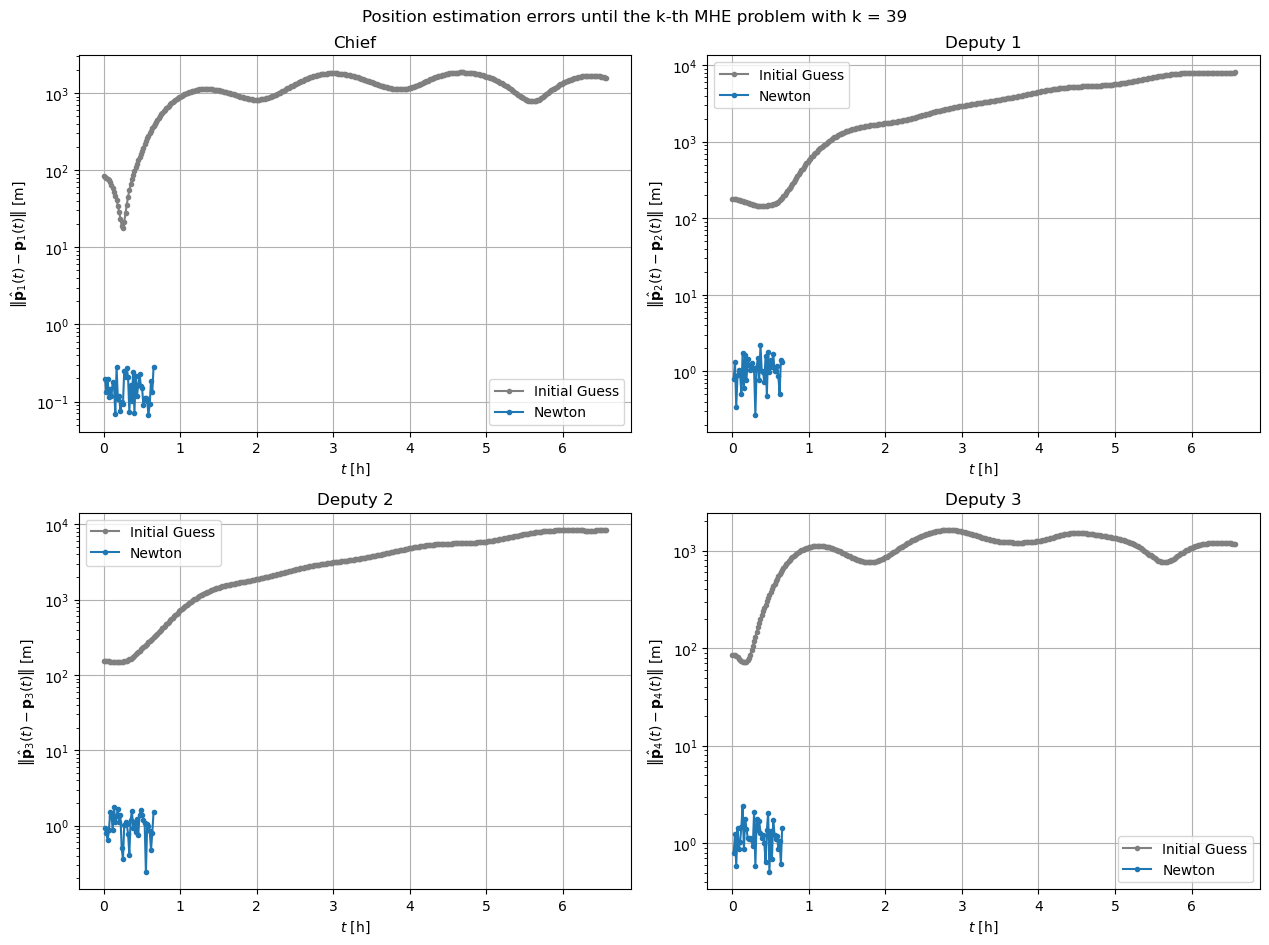

Windows:  10%|▉         | 39/394 [12:11<1:20:42, 13.64s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 23.897118487199712
Gradient norm: 1862.8948661283746
Global estimation error: 2.484189630985436
Spectral radius of inv(T) @ R: 0.6732026147150348
T minimum eigenvalue: 2.9691791928347433
Initial conditions estimation errors: 0.2813792669759818 m, 1.308323197680909 m, 1.5309904240159218 m, 1.4260798575117906 m
Position estimation errors: 0.47474082160128 m, 3.2297476193783563 m, 2.943188284519365 m, 2.9705260486690737 m
Iteration 0.0
Newton direction error: 0.03970731453747201 in 0.06249300458506773
Iteration 0.1
Newton direction error: 0.0263580537160792 in 0.06249300458506773
Iteration 0.2
Newton direction error: 0.017682205426035862 in 0.06249300458506773

[Centralized Newton] Iteration 1
Cost function: 10.347334461938926 (-56.70%)
Gradient norm: 62.941389599026316 (-96.62%)
Global estimation error: 2.483754728965348 (-0.02%)
Spectral radius of inv(T) @ R: 0.6732026144931065
T minimum eigenvalue: 2.9691791935360725
Ini

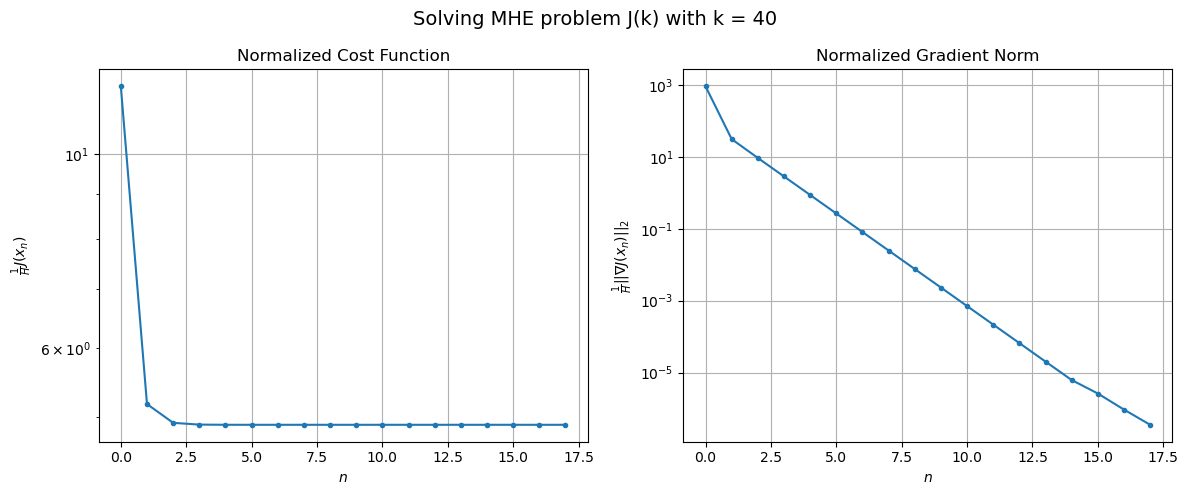

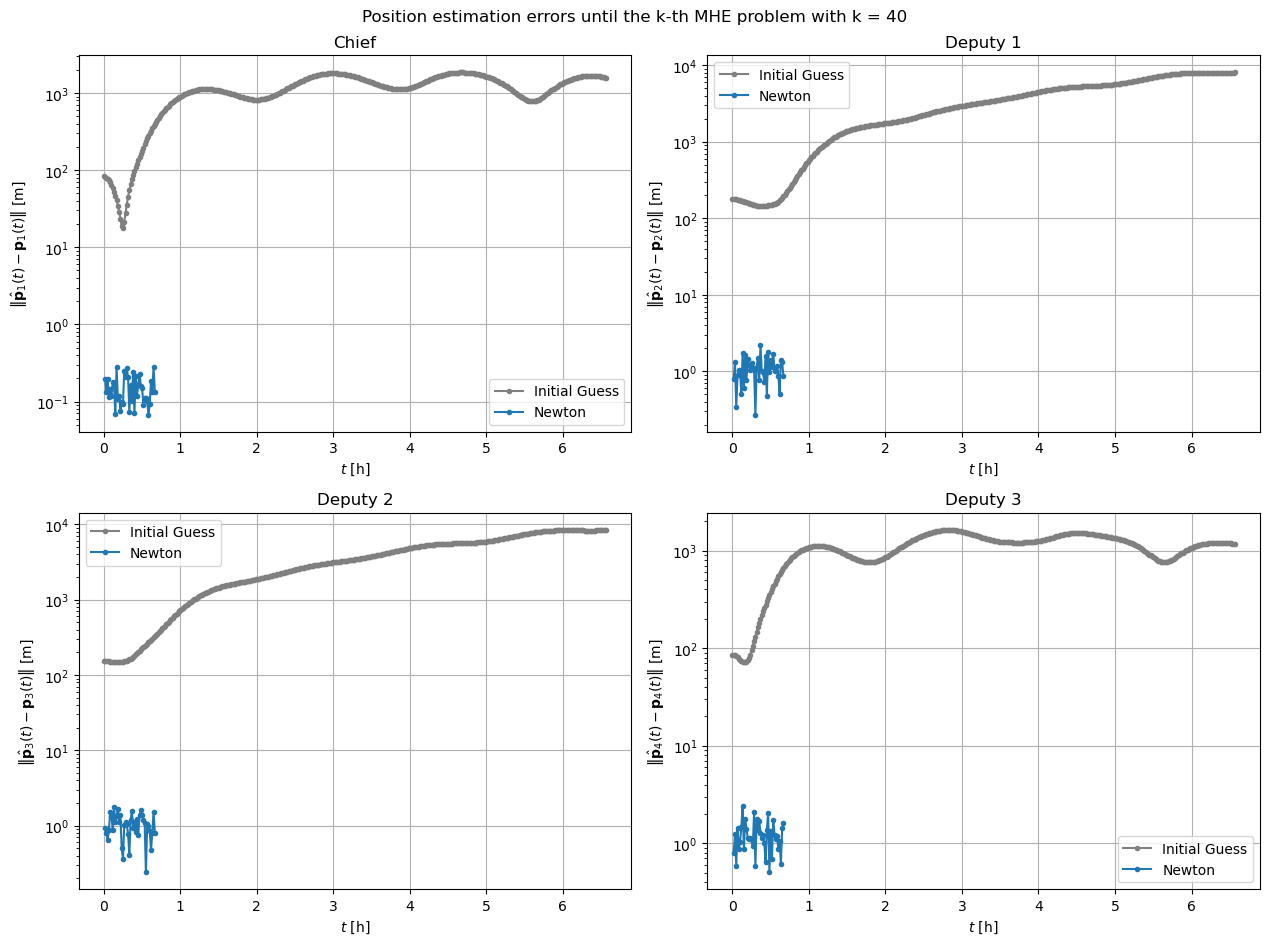

Windows:  10%|█         | 40/394 [12:46<1:57:55, 19.99s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 30.213765328546458
Gradient norm: 2168.450682702934
Global estimation error: 2.0022306777927605
Spectral radius of inv(T) @ R: 0.6732026146607148
T minimum eigenvalue: 2.9691791910482466
Initial conditions estimation errors: 0.1339701051885178 m, 0.8709899988793508 m, 0.8099487402308616 m, 1.6048853844940403 m
Position estimation errors: 0.42808058327672516 m, 0.8006776844221848 m, 1.2595723790830533 m, 2.2759939752883653 m
Iteration 0.0
Newton direction error: 0.027041557602912287 in 0.0561666689496871
Iteration 0.1
Newton direction error: 0.01597795729049533 in 0.0561666689496871
Iteration 0.2
Newton direction error: 0.010355875575985064 in 0.0561666689496871

[Centralized Newton] Iteration 1
Cost function: 8.293233953126137 (-72.55%)
Gradient norm: 42.993113784171186 (-98.02%)
Global estimation error: 2.002710668542315 (0.02%)
Spectral radius of inv(T) @ R: 0.6732026144501144
T minimum eigenvalue: 2.969179191827404
In

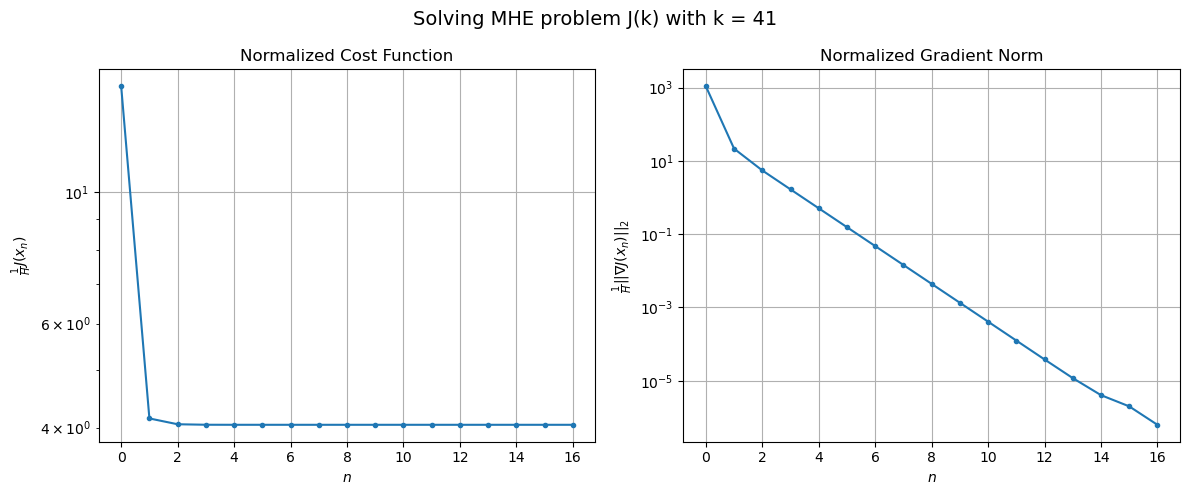

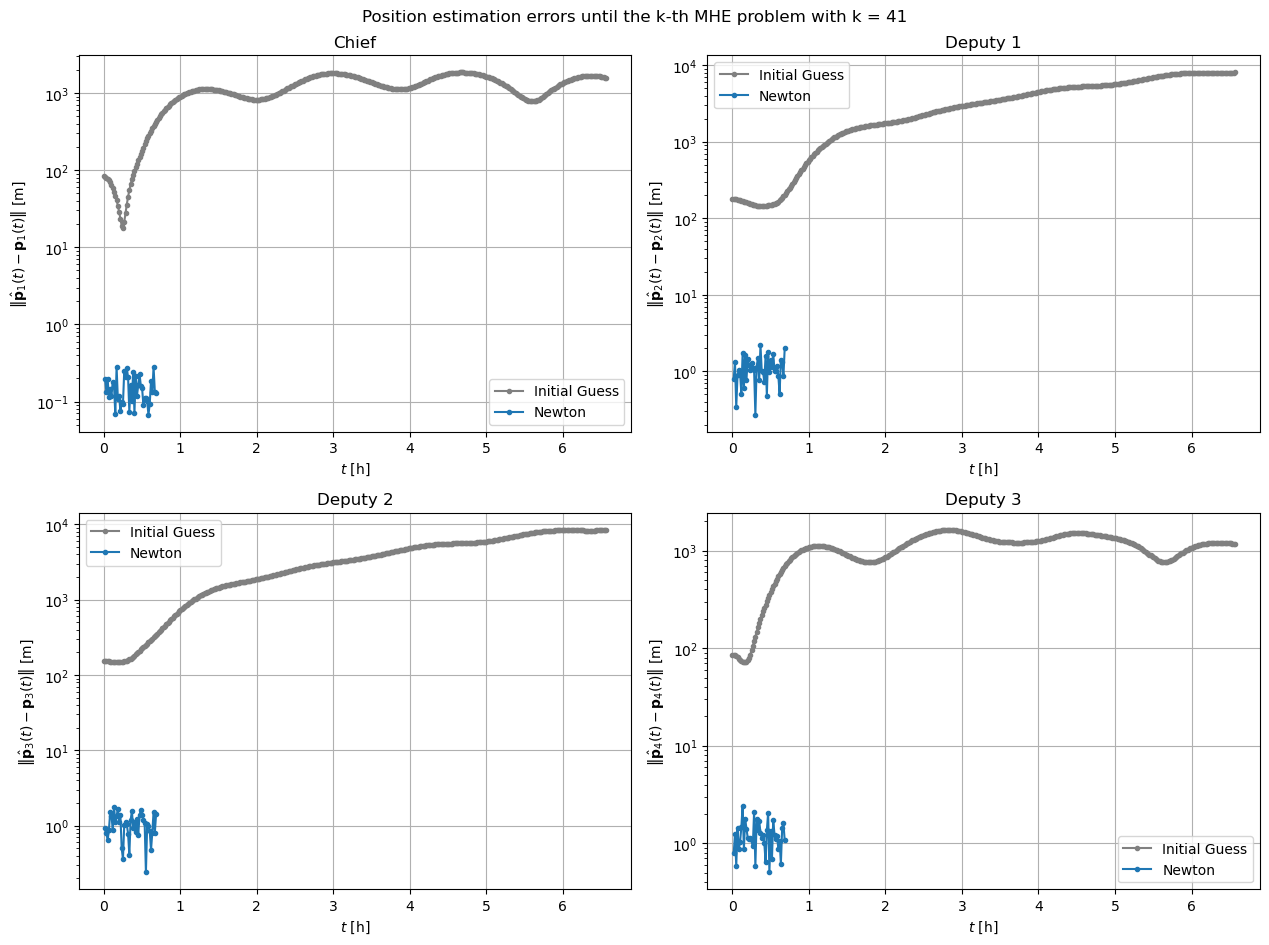

Windows:  10%|█         | 41/394 [13:18<2:18:44, 23.58s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 55.077133921532756
Gradient norm: 3453.5290357228914
Global estimation error: 2.700627896408956
Spectral radius of inv(T) @ R: 0.6732026147842783
T minimum eigenvalue: 2.9691791933857377
Initial conditions estimation errors: 0.12934892194356018 m, 2.0091093890347107 m, 1.445934895636944 m, 1.070325362378286 m
Position estimation errors: 0.6407619095652584 m, 4.347908189877561 m, 3.700385658391562 m, 2.8901627828953687 m
Iteration 0.0
Newton direction error: 0.07426827190547781 in 0.11744697755594224
Iteration 0.1
Newton direction error: 0.04922560812998766 in 0.11744697755594224
Iteration 0.2
Newton direction error: 0.03301016410348752 in 0.11744697755594224

[Centralized Newton] Iteration 1
Cost function: 6.687834782519877 (-87.86%)
Gradient norm: 118.00163183177347 (-96.58%)
Global estimation error: 2.7001358010511645 (-0.02%)
Spectral radius of inv(T) @ R: 0.67320261451416
T minimum eigenvalue: 2.969179191363417
Initi

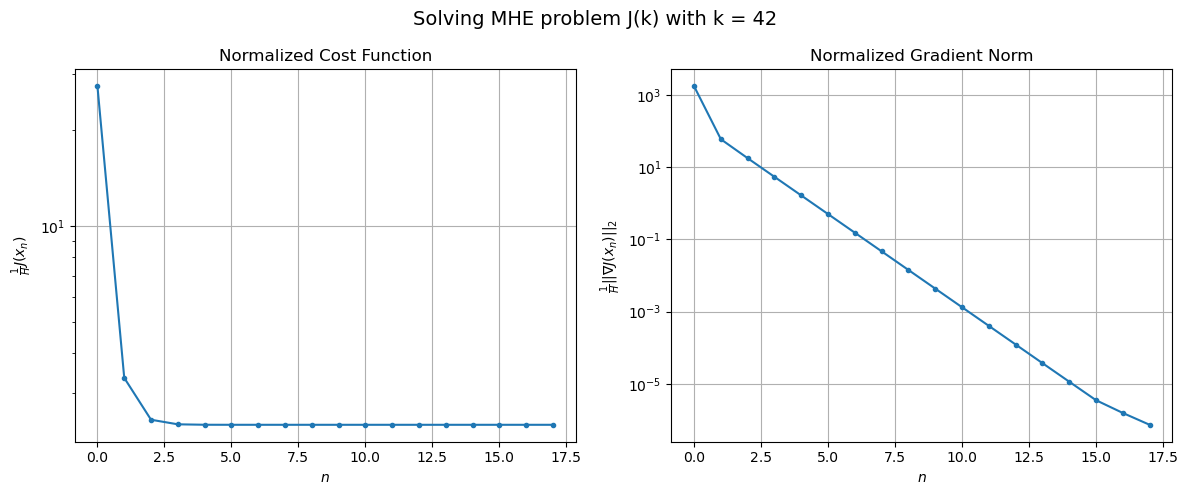

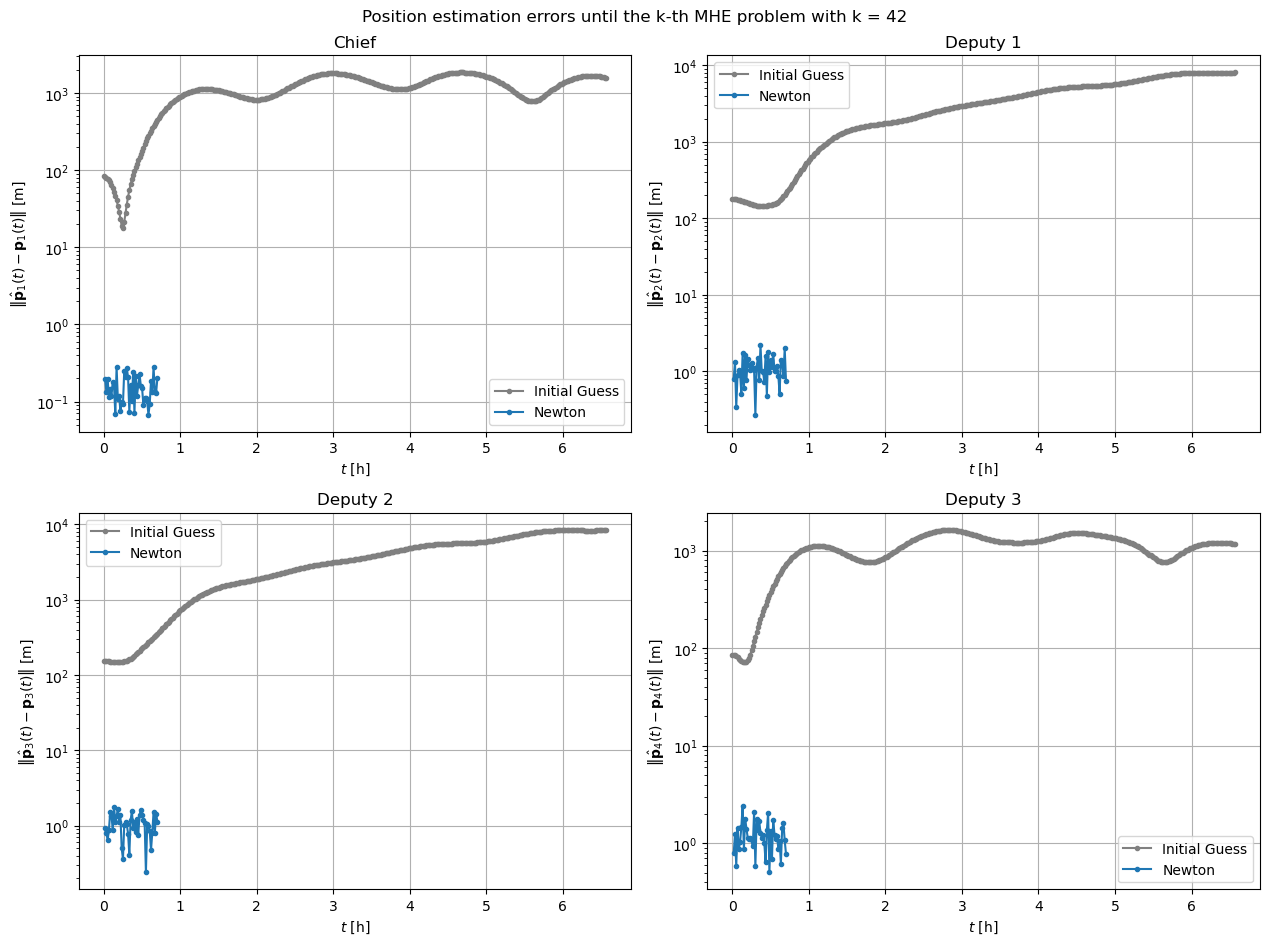

Windows:  11%|█         | 42/394 [13:52<2:37:15, 26.81s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 42.96650594695569
Gradient norm: 3910.1916837497447
Global estimation error: 1.584169129733387
Spectral radius of inv(T) @ R: 0.6732026149668625
T minimum eigenvalue: 2.9691791866542836
Initial conditions estimation errors: 0.20151001046679404 m, 0.7568714197470054 m, 1.1328535973166625 m, 0.7809240276836629 m
Position estimation errors: 0.4392446081821658 m, 1.962264906750059 m, 3.2662502025041293 m, 2.0402684163554334 m
Iteration 0.0
Newton direction error: 0.043245443752700334 in 0.0721228101796189
Iteration 0.1
Newton direction error: 0.028247378532510928 in 0.0721228101796189
Iteration 0.2
Newton direction error: 0.01887057483440529 in 0.0721228101796189

[Centralized Newton] Iteration 1
Cost function: 7.43911151618814 (-82.69%)
Gradient norm: 68.65804850762851 (-98.24%)
Global estimation error: 1.5837621498227448 (-0.03%)
Spectral radius of inv(T) @ R: 0.6732026145177725
T minimum eigenvalue: 2.9691791883384204
Ini

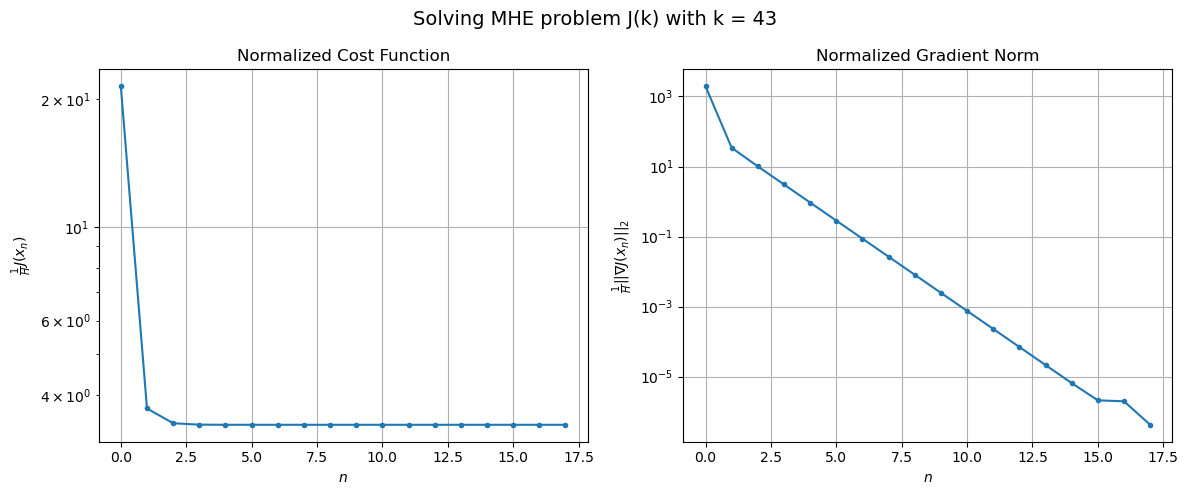

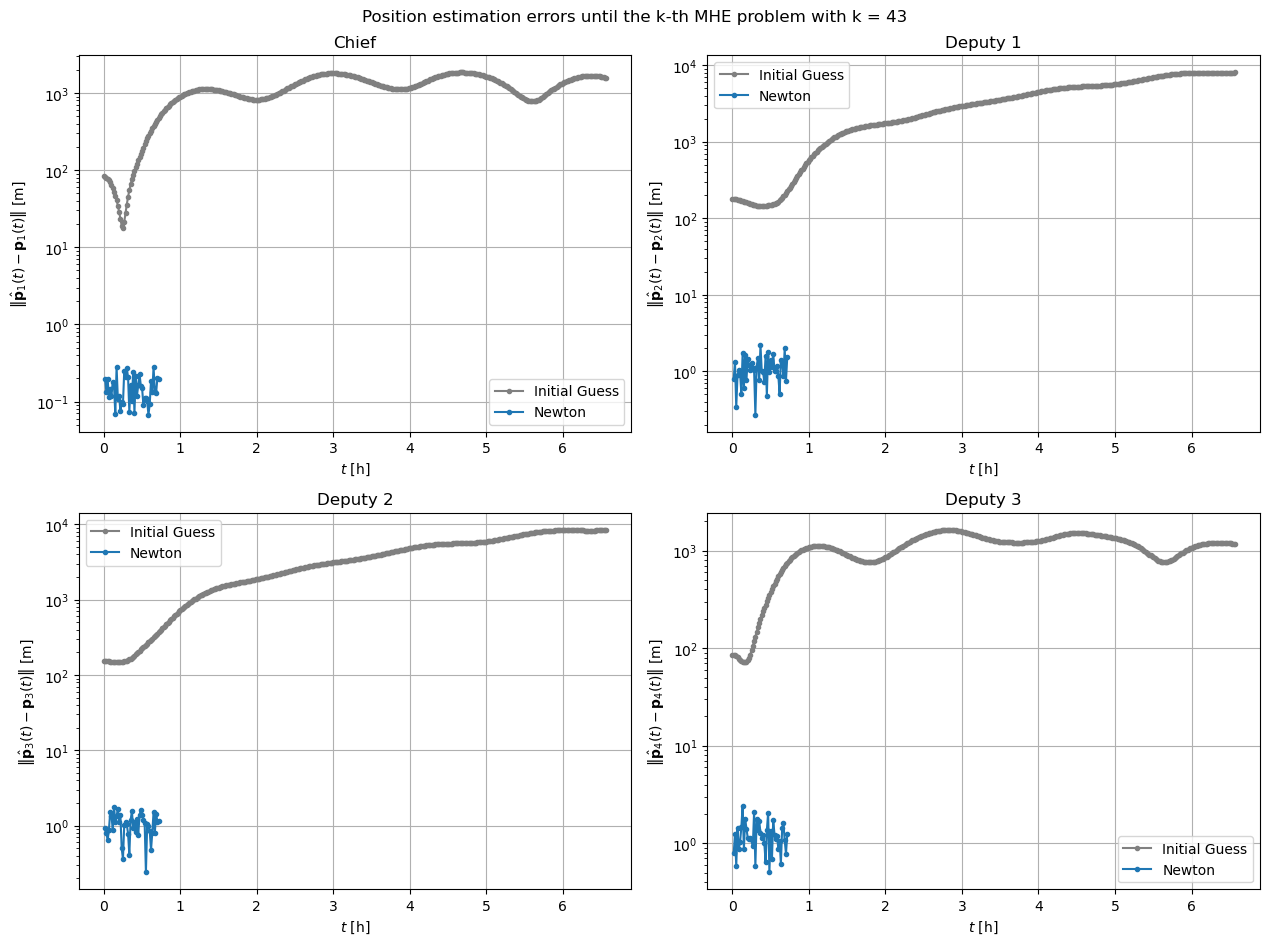

Windows:  11%|█         | 43/394 [14:26<2:50:05, 29.08s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 47.2423450076242
Gradient norm: 1241.1846441852144
Global estimation error: 2.297229371926591
Spectral radius of inv(T) @ R: 0.6732026145071225
T minimum eigenvalue: 2.969179187419288
Initial conditions estimation errors: 0.19877236308171553 m, 1.5333718445098758 m, 1.1590100415404094 m, 1.2414330435074745 m
Position estimation errors: 0.23307223760852822 m, 2.553739691419626 m, 2.127689750978252 m, 3.665194982132735 m
Iteration 0.0
Newton direction error: 0.03298483825054242 in 0.08081308213719586
Iteration 0.1
Newton direction error: 0.016889904919368773 in 0.08081308213719586
Iteration 0.2
Newton direction error: 0.01030501694342802 in 0.08081308213719586

[Centralized Newton] Iteration 1
Cost function: 5.745395630534931 (-87.84%)
Gradient norm: 52.50118277861917 (-95.77%)
Global estimation error: 2.2972388667241446 (0.00%)
Spectral radius of inv(T) @ R: 0.6732026144167383
T minimum eigenvalue: 2.9691791873483093
Init

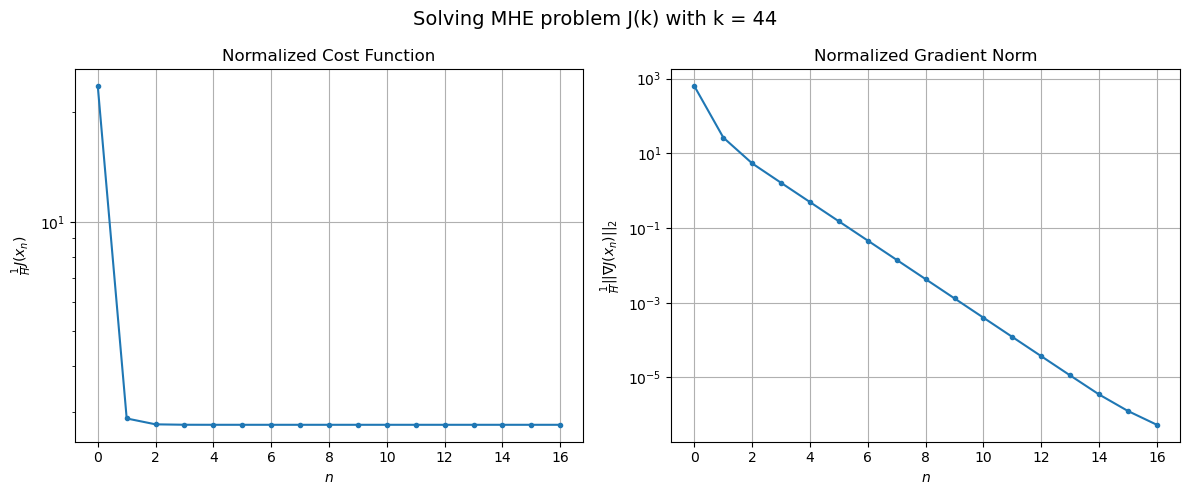

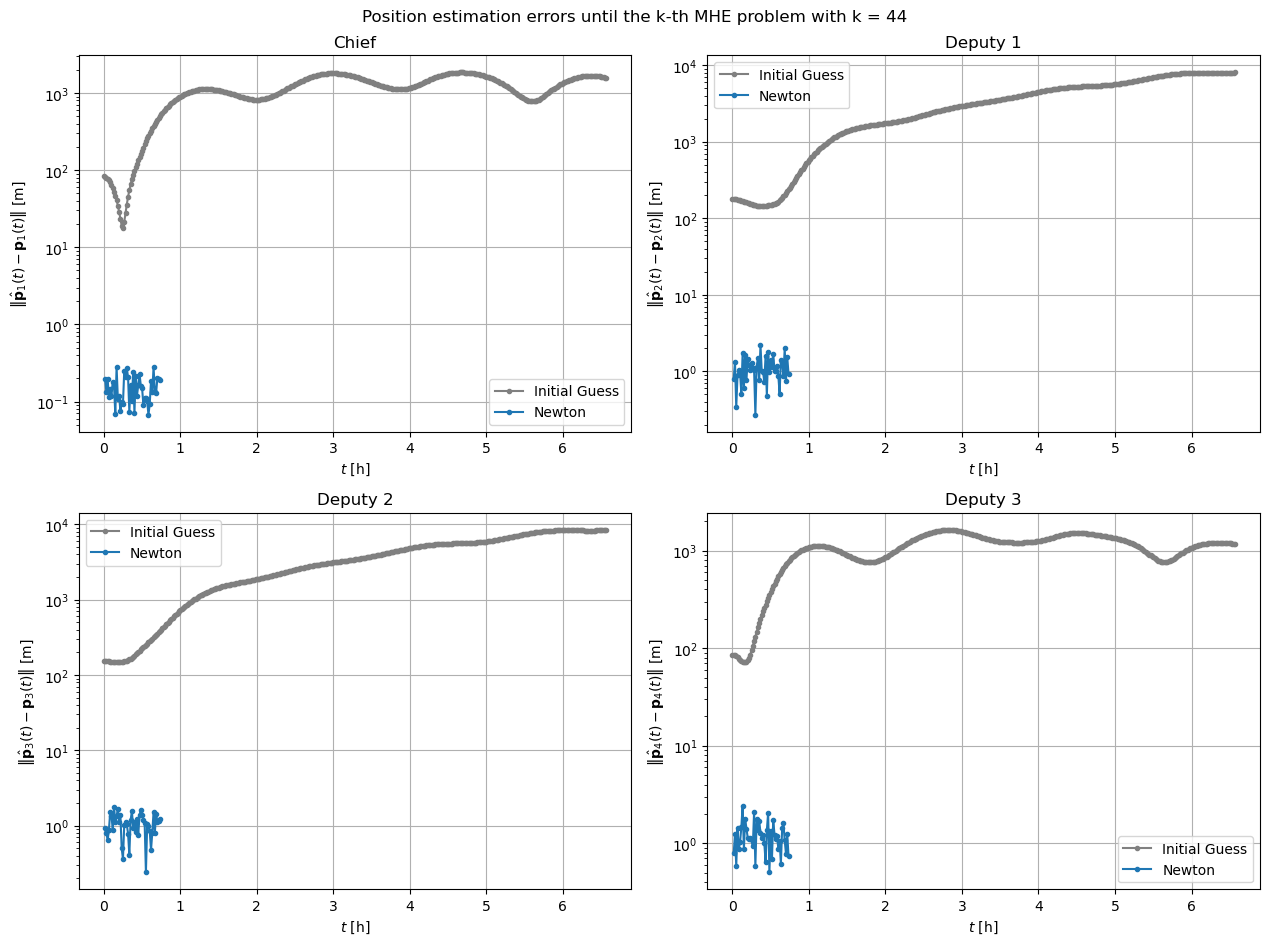

Windows:  11%|█         | 44/394 [15:02<3:00:24, 30.93s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 90.09510074901982
Gradient norm: 5596.726733743496
Global estimation error: 1.7179573838365465
Spectral radius of inv(T) @ R: 0.6732026145982537
T minimum eigenvalue: 2.9691791878103846
Initial conditions estimation errors: 0.19241896083621932 m, 0.9236555624982533 m, 1.233587243292049 m, 0.7330367723395825 m
Position estimation errors: 0.9346113042246106 m, 2.3991825800206694 m, 3.294554377490206 m, 0.9683349345597962 m
Iteration 0.0
Newton direction error: 0.04783224090035801 in 0.09534920701512403
Iteration 0.1
Newton direction error: 0.029072854824230807 in 0.09534920701512403
Iteration 0.2
Newton direction error: 0.01902016272849524 in 0.09534920701512403

[Centralized Newton] Iteration 1
Cost function: 6.988624285378732 (-92.24%)
Gradient norm: 76.07502110069821 (-98.64%)
Global estimation error: 1.717941326363755 (-0.00%)
Spectral radius of inv(T) @ R: 0.6732026144548796
T minimum eigenvalue: 2.9691791866701105
In

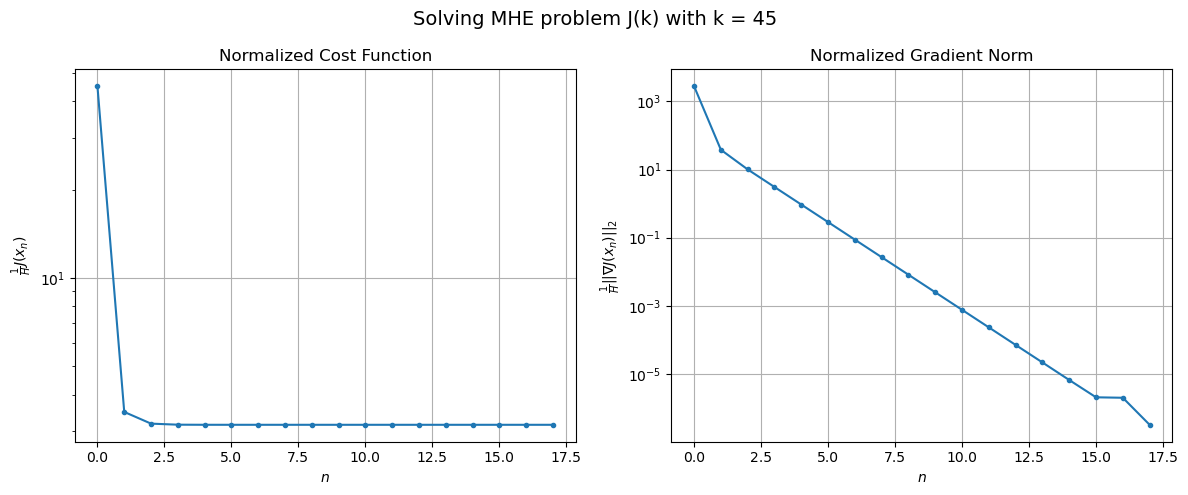

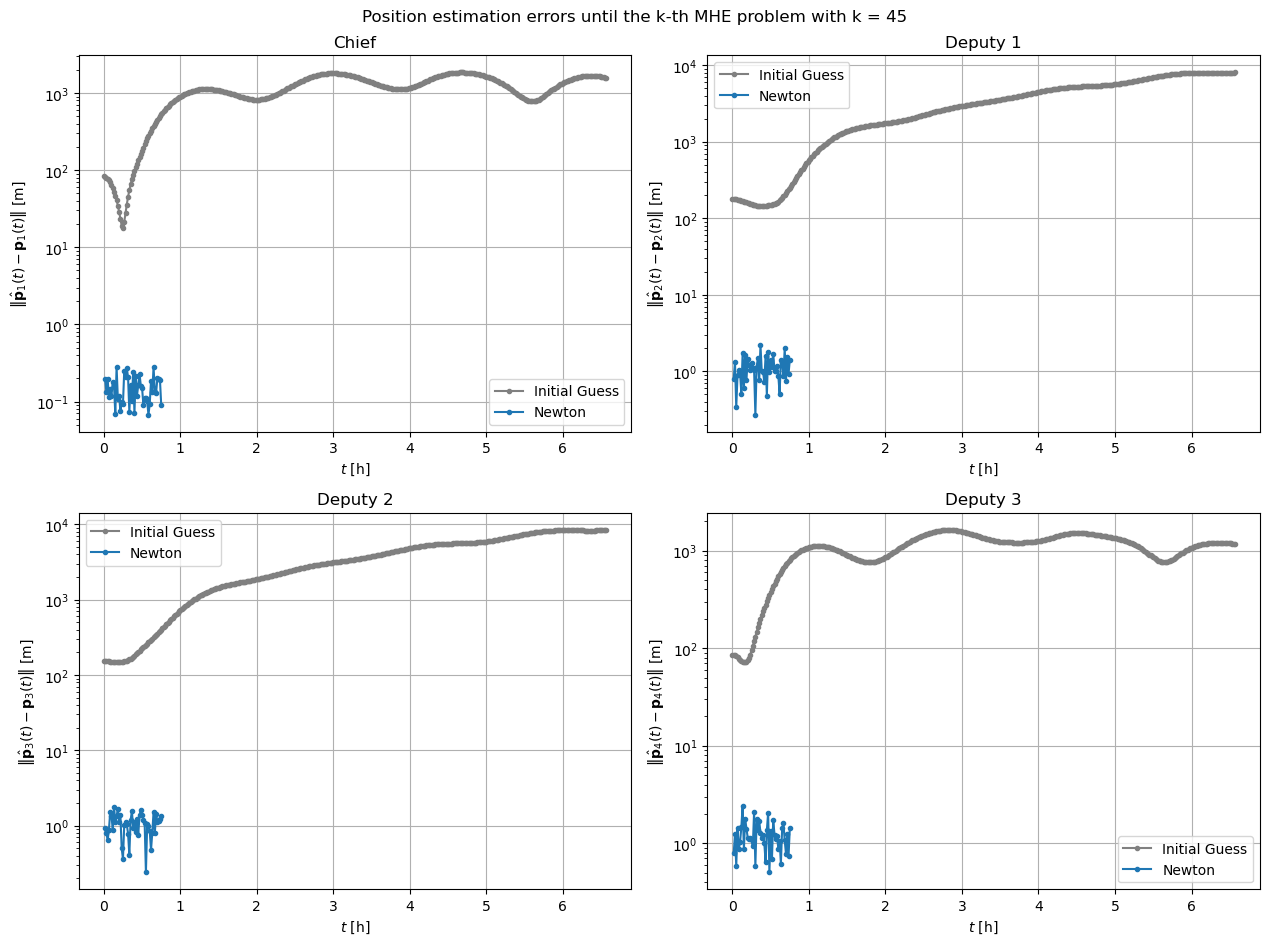

Windows:  11%|█▏        | 45/394 [15:31<2:57:45, 30.56s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 57.58390370924029
Gradient norm: 3615.849870685311
Global estimation error: 2.431211942749996
Spectral radius of inv(T) @ R: 0.6732026150651674
T minimum eigenvalue: 2.9691791823966707
Initial conditions estimation errors: 0.09051588863093932 m, 1.4143796183996509 m, 1.3610889817062939 m, 1.430855849485043 m
Position estimation errors: 0.6183362560307518 m, 3.068537458558387 m, 2.873806829827657 m, 2.428528516074729 m
Iteration 0.0
Newton direction error: 0.04933548088484343 in 0.08940802738434386
Iteration 0.1
Newton direction error: 0.031215311399958087 in 0.08940802738434386
Iteration 0.2
Newton direction error: 0.020671260179442236 in 0.08940802738434386

[Centralized Newton] Iteration 1
Cost function: 9.512571295122928 (-83.48%)
Gradient norm: 78.45290009747985 (-97.83%)
Global estimation error: 2.4310189260258257 (-0.01%)
Spectral radius of inv(T) @ R: 0.6732026145467059
T minimum eigenvalue: 2.969179184501416
Init

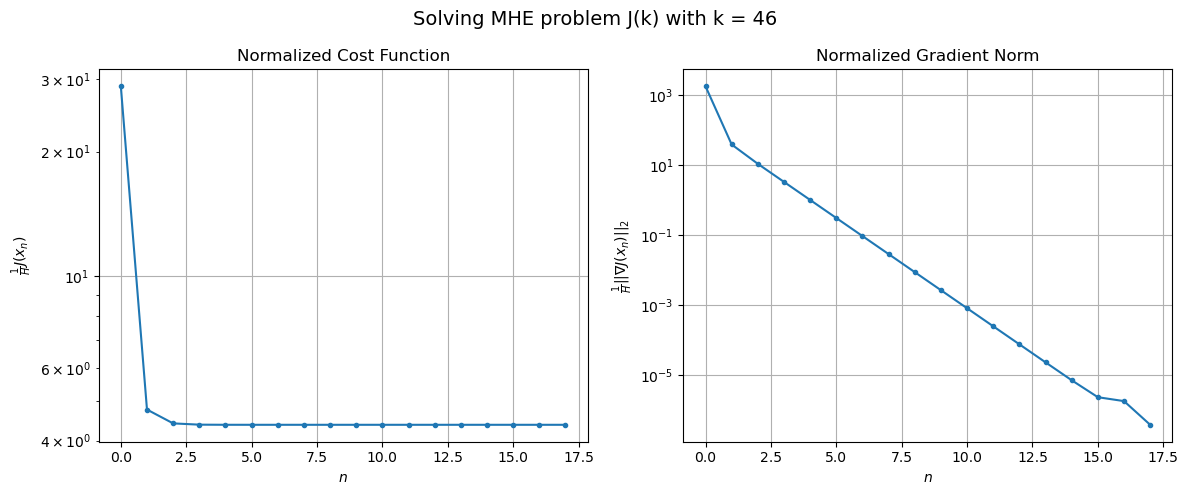

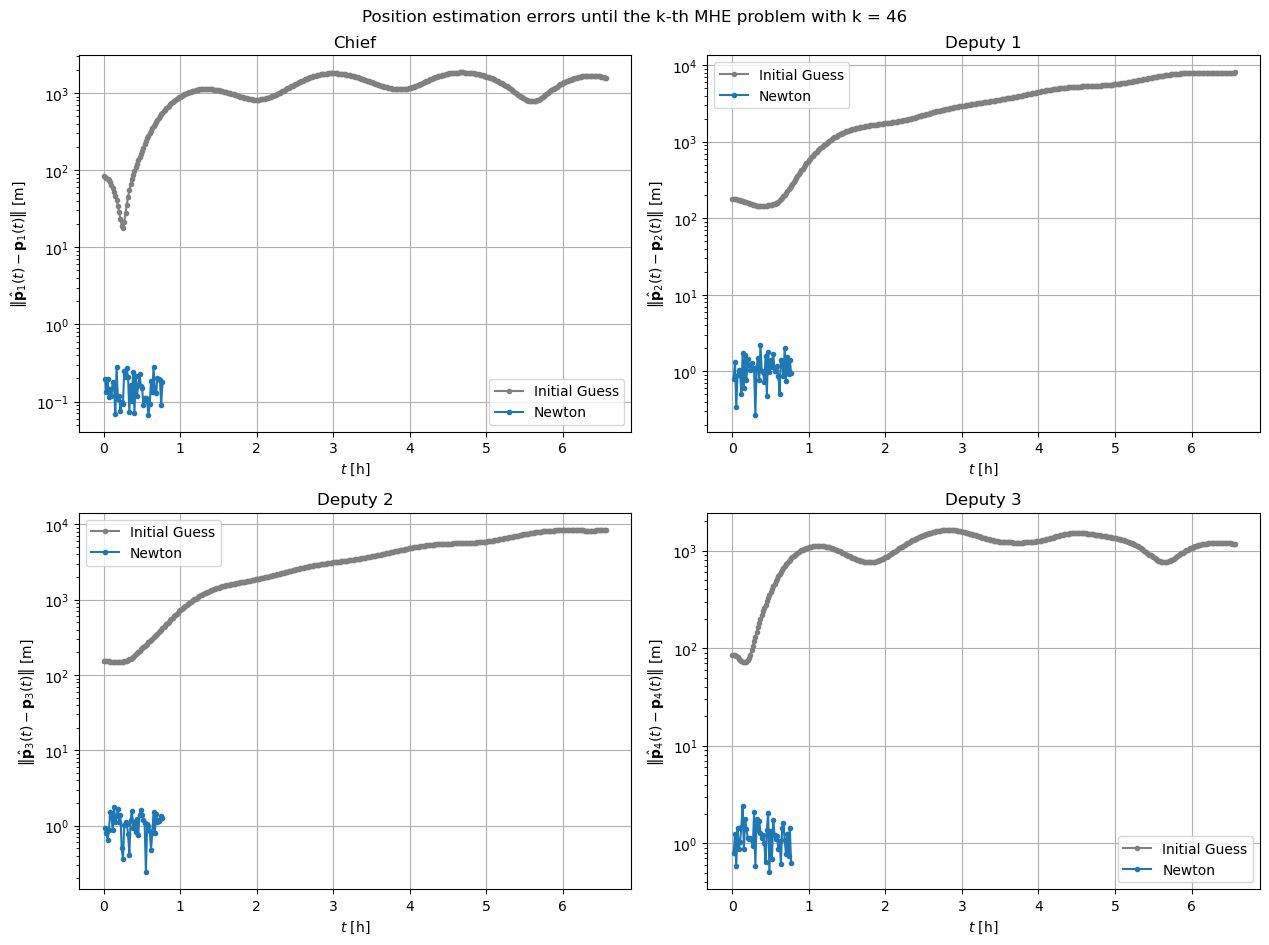

Windows:  12%|█▏        | 46/394 [16:05<3:02:49, 31.52s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 60.06272116837144
Gradient norm: 4765.268635196686
Global estimation error: 1.7193744966287823
Spectral radius of inv(T) @ R: 0.6732026145758111
T minimum eigenvalue: 2.969179185650536
Initial conditions estimation errors: 0.1767360960751527 m, 0.9569519811255993 m, 1.2670657892555726 m, 0.6330671810648045 m
Position estimation errors: 0.6283459393505213 m, 3.27878337517549 m, 3.396227086026196 m, 0.9608708811157328 m
Iteration 0.0
Newton direction error: 0.04627129339123491 in 0.07788084442537667
Iteration 0.1
Newton direction error: 0.030202557085464533 in 0.07788084442537667
Iteration 0.2
Newton direction error: 0.02017302541170709 in 0.07788084442537667

[Centralized Newton] Iteration 1
Cost function: 12.014923112104853 (-80.00%)
Gradient norm: 73.47419289377113 (-98.46%)
Global estimation error: 1.718765014116192 (-0.04%)
Spectral radius of inv(T) @ R: 0.6732026144586543
T minimum eigenvalue: 2.9691791848132683
Init

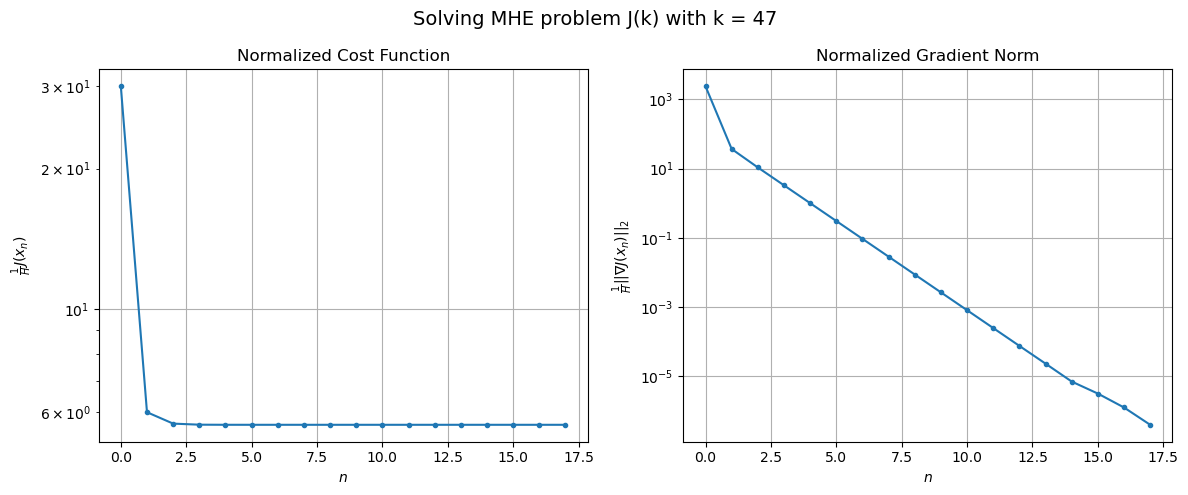

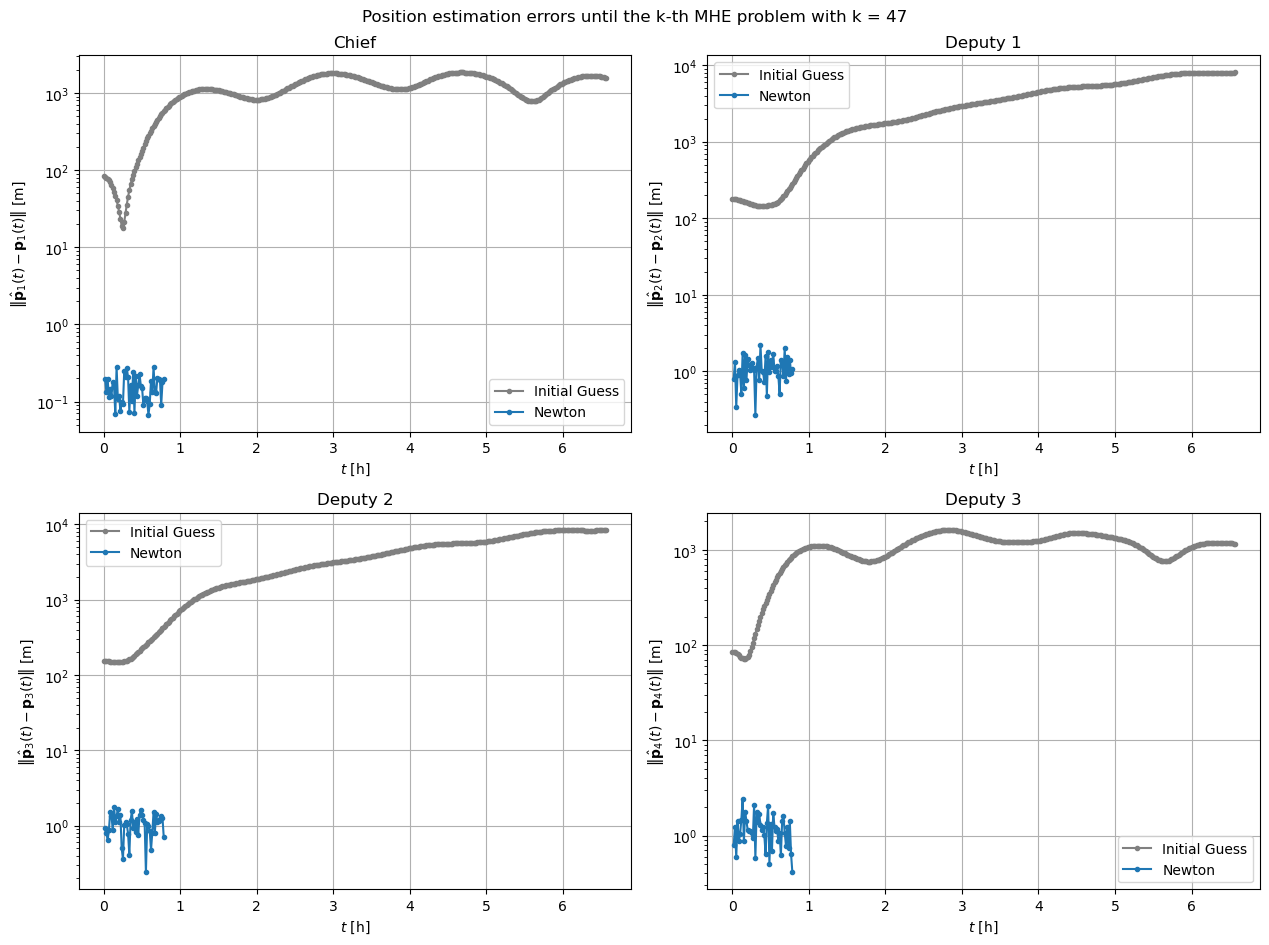

Windows:  12%|█▏        | 47/394 [16:37<3:02:56, 31.63s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 25.488810731892997
Gradient norm: 1819.1955392357386
Global estimation error: 1.3534223177610767
Spectral radius of inv(T) @ R: 0.6732026144955705
T minimum eigenvalue: 2.969179184371626
Initial conditions estimation errors: 0.19739605148440365 m, 1.0642775081251532 m, 0.7002481462666494 m, 0.41065811930028717 m
Position estimation errors: 0.2958552654739143 m, 2.6198602330172127 m, 1.096584435533203 m, 0.9809866238475569 m
Iteration 0.0
Newton direction error: 0.0267286290449942 in 0.04897812451354539
Iteration 0.1
Newton direction error: 0.01684340841315457 in 0.04897812451354539
Iteration 0.2
Newton direction error: 0.011140946659142274 in 0.04897812451354539

[Centralized Newton] Iteration 1
Cost function: 11.670719409299915 (-54.21%)
Gradient norm: 42.391280015177976 (-97.67%)
Global estimation error: 1.353364535925299 (-0.00%)
Spectral radius of inv(T) @ R: 0.673202614420129
T minimum eigenvalue: 2.9691791839000183

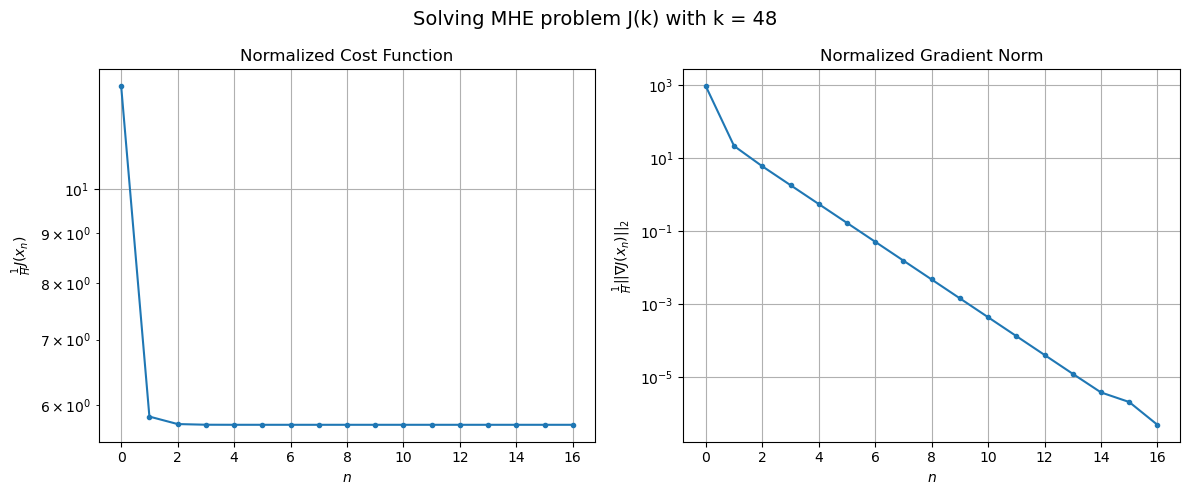

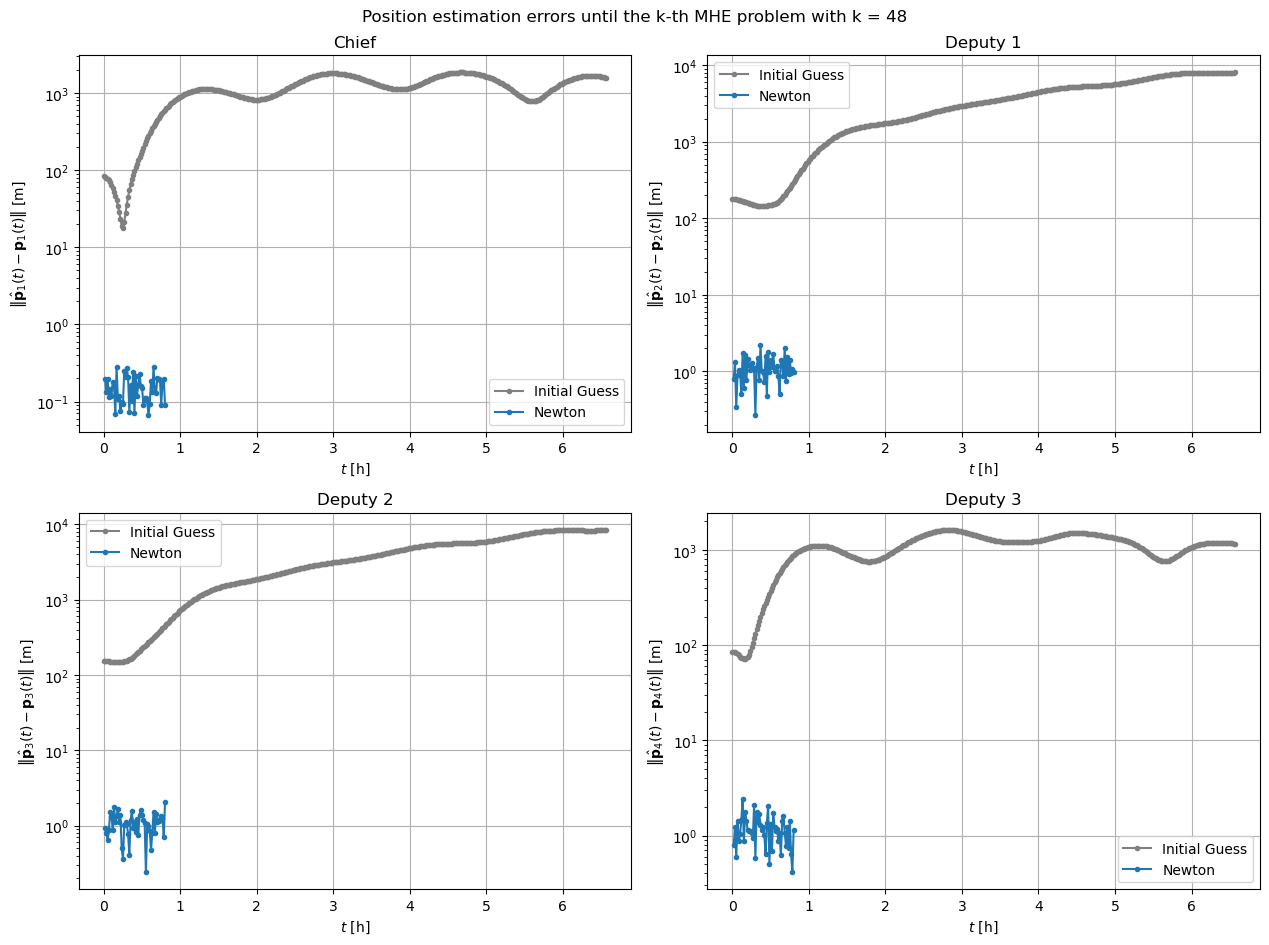

Windows:  12%|█▏        | 48/394 [17:09<3:02:37, 31.67s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 63.30540368087651
Gradient norm: 3799.1654192337937
Global estimation error: 2.5714799707090443
Spectral radius of inv(T) @ R: 0.6732026149017218
T minimum eigenvalue: 2.969179181750327
Initial conditions estimation errors: 0.08899746955585738 m, 0.9806918504304128 m, 2.0834647008213953 m, 1.1404359778009194 m
Position estimation errors: 0.5453374102457185 m, 1.548837903496643 m, 3.930841308497317 m, 2.0459476782286656 m
Iteration 0.0
Newton direction error: 0.0665005191369591 in 0.10873337276406886
Iteration 0.1
Newton direction error: 0.04365911391868685 in 0.10873337276406886
Iteration 0.2
Newton direction error: 0.029205439887631184 in 0.10873337276406886

[Centralized Newton] Iteration 1
Cost function: 11.67406843258875 (-81.56%)
Gradient norm: 105.35165681249404 (-97.23%)
Global estimation error: 2.571747027909243 (0.01%)
Spectral radius of inv(T) @ R: 0.6732026145421667
T minimum eigenvalue: 2.9691791829402114
Ini

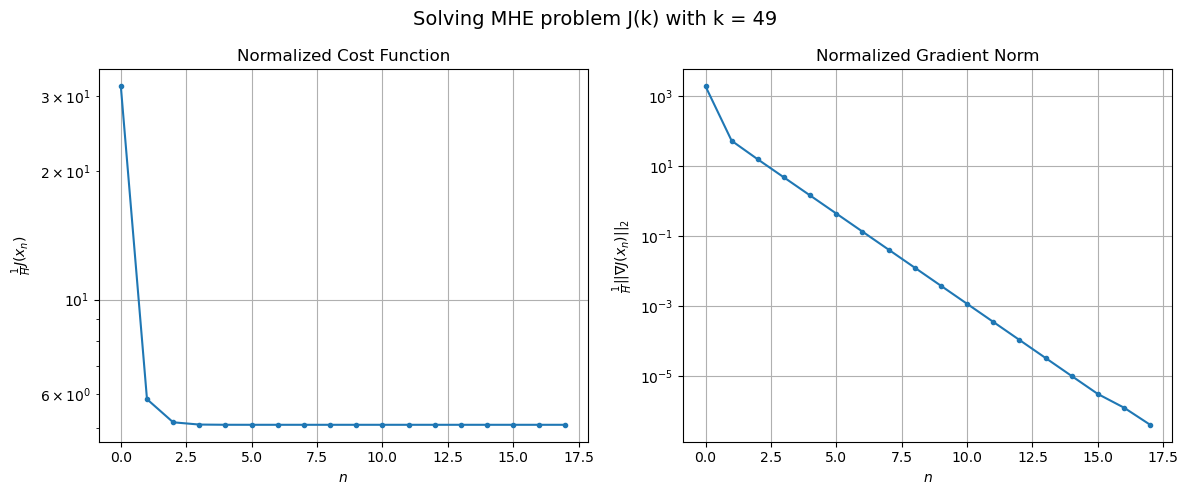

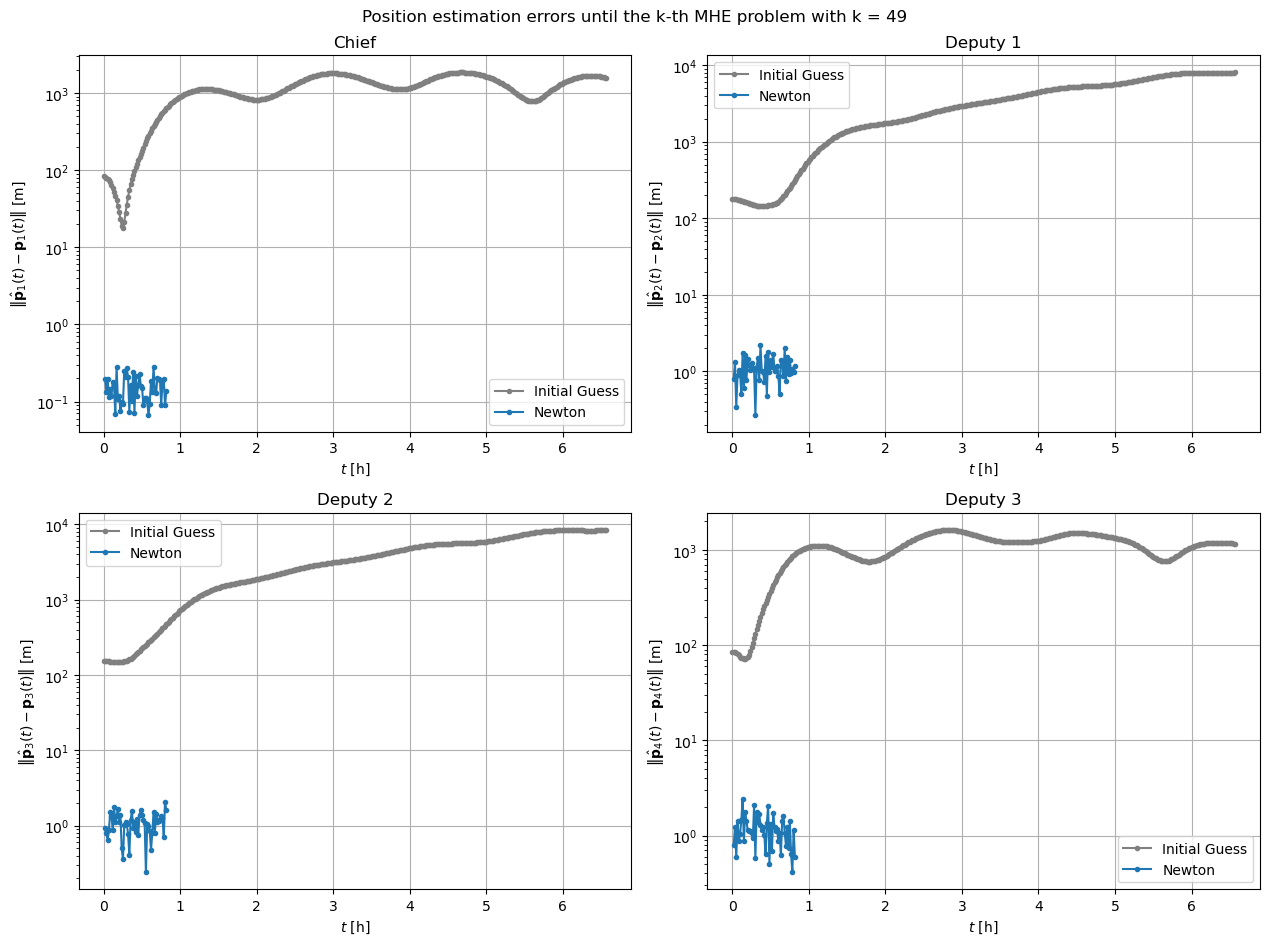

Windows:  12%|█▏        | 49/394 [17:41<3:02:27, 31.73s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 40.587880526344705
Gradient norm: 1483.298721279868
Global estimation error: 2.075592635213366
Spectral radius of inv(T) @ R: 0.6732026146619389
T minimum eigenvalue: 2.969179183519272
Initial conditions estimation errors: 0.13709626547757023 m, 1.176724113056197 m, 1.5940659772819084 m, 0.5987103355273629 m
Position estimation errors: 0.21204866211081982 m, 2.586013388491759 m, 5.07415739207129 m, 2.335546474062611 m
Iteration 0.0
Newton direction error: 0.05058428502990022 in 0.08884259282261664
Iteration 0.1
Newton direction error: 0.03235736554139113 in 0.08884259282261664
Iteration 0.2
Newton direction error: 0.021493863250783757 in 0.08884259282261664

[Centralized Newton] Iteration 1
Cost function: 9.451179065475355 (-76.71%)
Gradient norm: 80.12859205977794 (-94.60%)
Global estimation error: 2.0746435526271583 (-0.05%)
Spectral radius of inv(T) @ R: 0.6732026144626894
T minimum eigenvalue: 2.9691791834015873
Init

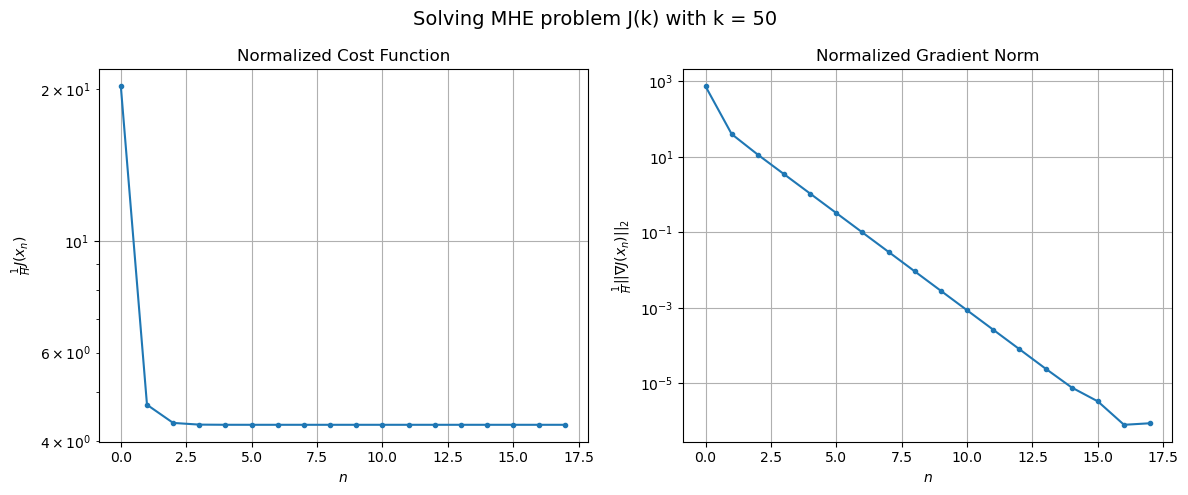

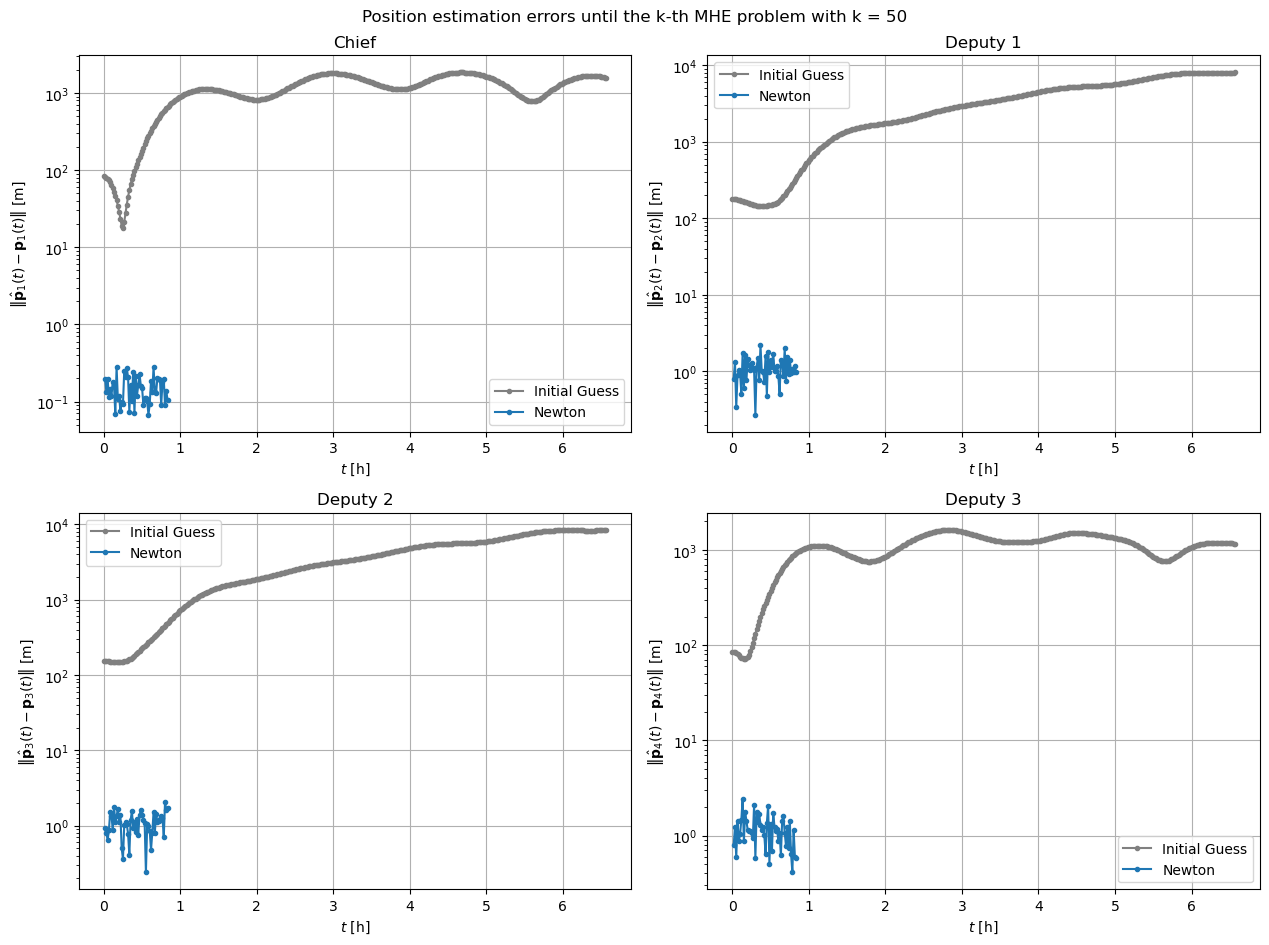

Windows:  13%|█▎        | 50/394 [18:14<3:04:37, 32.20s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 41.63175654253578
Gradient norm: 2474.5907357105807
Global estimation error: 2.081141294506652
Spectral radius of inv(T) @ R: 0.6732026145606929
T minimum eigenvalue: 2.969179184629414
Initial conditions estimation errors: 0.10338784303866913 m, 0.9786287509172065 m, 1.7395731572284865 m, 0.5790781127179035 m
Position estimation errors: 0.42447178899147153 m, 1.4946299174980524 m, 3.203788177514924 m, 0.608146787745297 m
Iteration 0.0
Newton direction error: 0.0345831805002352 in 0.06773113970062601
Iteration 0.1
Newton direction error: 0.021117603226808338 in 0.06773113970062601
Iteration 0.2
Newton direction error: 0.013835894863856005 in 0.06773113970062601

[Centralized Newton] Iteration 1
Cost function: 12.70667534335179 (-69.48%)
Gradient norm: 54.99825248157601 (-97.78%)
Global estimation error: 2.0811176109749447 (-0.00%)
Spectral radius of inv(T) @ R: 0.6732026144328741
T minimum eigenvalue: 2.9691791837979133
I

KeyboardInterrupt: 

In [14]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

# Apply the algorithm
X_est = np.zeros((n, 1, K))
for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
    x_true_initial = X_true[:, :, k - H + 1]
    x_true_end = X_true[:, :, k]
    x = x_init.copy()
    centralized_newton.cost_values, centralized_newton.gradient_norm_values = [], []
    prev_cost_value = None
    prev_gradient_norm_value = None
    prev_global_estimation_error = None
    grad_norm_order_history = []
    for iteration in range(centralized_newton.max_iterations + 1):
        # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
        J_x = centralized_newton.J(k, dt, Y, x)
        DJ_x = centralized_newton.DJ(k, dt, Y, x)
        HJ_x = centralized_newton.HJ(k, dt, Y, x)
        T_matrix_x = np.zeros_like(HJ_x)
        R_matrix_x = np.zeros_like(HJ_x)
        for i in range(config.N):
            for j in range(config.N):
                block = HJ_x[i*config.n_x:(i+1)*config.n_x, j*config.n_x:(j+1)*config.n_x]
                if i == j or i == 0 or j == 0:
                    T_matrix_x[i*config.n_x:(i+1)*config.n_x, j*config.n_x:(j+1)*config.n_x] = block
                else:
                    R_matrix_x[i*config.n_x:(i+1)*config.n_x, j*config.n_x:(j+1)*config.n_x] = -block
        spectral_radius_T_inv_R = max(abs(np.linalg.eigvals(np.linalg.inv(T_matrix_x) @ R_matrix_x)))

        # Convergence tracking
        cost_value = J_x[0][0]
        gradient_norm_value = np.linalg.norm(DJ_x)

        # Store the values
        centralized_newton.cost_values.append(cost_value)
        centralized_newton.gradient_norm_values.append(gradient_norm_value)

        # Metrics
        if prev_cost_value is not None:
            cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
            gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
            global_estimation_error_change = (np.linalg.norm(x - x_true_initial) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
        prev_cost_value = cost_value
        prev_gradient_norm_value = gradient_norm_value
        prev_global_estimation_error = np.linalg.norm(x - x_true_initial)
        
        # Track gradient norm order of magnitude
        current_order = int(np.floor(np.log10(gradient_norm_value + 1e-12)))  # avoid log(0)
        grad_norm_order_history.append(current_order)

        if centralized_newton.grad_norm_order_mag:
            if len(grad_norm_order_history) >= 3:
                if grad_norm_order_history[-1] == grad_norm_order_history[-2] == grad_norm_order_history[-3]:
                    stagnant_order = True
                    if k == centralized_newton.H - 1:
                        stagnant_order = False
                else:
                    stagnant_order = False
            else:
                stagnant_order = False
        else:
            stagnant_order = False
            
        # Propagate window initial conditions for metrics 
        x_end = x.copy()
        for _ in range(centralized_newton.H - 1):
            x_end = centralized_newton.dyn.f(dt, x_end)

        # Check convergence and print metrics
        if gradient_norm_value < centralized_newton.grad_norm_tol or iteration == centralized_newton.max_iterations or stagnant_order:
            reason = "tolerance reached" if gradient_norm_value < centralized_newton.grad_norm_tol else \
                    "max iteration reached" if iteration == centralized_newton.max_iterations else \
                    "gradient norm stagnated"
            print(f"[Centralized Newton] STOP on Iteration {iteration} ({reason})")
            print(f"Cost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)\nSpectral radius of inv(T) @ R: {spectral_radius_T_inv_R}\nT minimum eigenvalue: {min(np.linalg.eigvalsh(T_matrix_x))}")
            print(f"Final initial conditions estimation errors: {np.linalg.norm(x[:config.n_p, :] - x_true_initial[:config.n_p, :])} m, {np.linalg.norm(x[config.n_x : config.n_x + config.n_p, :] - x_true_initial[config.n_x : config.n_x + config.n_p, :])} m, {np.linalg.norm(x[2 * config.n_x : 2 * config.n_x + config.n_p, :] - x_true_initial[2 * config.n_x : 2 * config.n_x + config.n_p, :])} m, {np.linalg.norm(x[3 * config.n_x : 3 * config.n_x + config.n_p, :] - x_true_initial[3 * config.n_x : 3 * config.n_x + config.n_p, :])} m")
            print(f"Final position estimation errors: {np.linalg.norm(x_end[:config.n_p, :] - x_true_end[:config.n_p, :])} m, {np.linalg.norm(x_end[config.n_x : config.n_x + config.n_p, :] - x_true_end[config.n_x : config.n_x + config.n_p, :])} m, {np.linalg.norm(x_end[2 * config.n_x : 2 * config.n_x + config.n_p, :] - x_true_end[2 * config.n_x : 2 * config.n_x + config.n_p, :])} m, {np.linalg.norm(x_end[3 * config.n_x : 3 * config.n_x + config.n_p, :] - x_true_end[3 * config.n_x : 3 * config.n_x + config.n_p, :])} m\n")
            break
        else:
            if iteration == 0:
                print(f"[Centralized Newton] Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)}\nSpectral radius of inv(T) @ R: {spectral_radius_T_inv_R}\nT minimum eigenvalue: {min(np.linalg.eigvalsh(T_matrix_x))}")
            else:
                print(f"[Centralized Newton] Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)\nSpectral radius of inv(T) @ R: {spectral_radius_T_inv_R}\nT minimum eigenvalue: {min(np.linalg.eigvalsh(T_matrix_x))}")
                
        # Print estimation errors 
        print(f"Initial conditions estimation errors: {np.linalg.norm(x[:config.n_p, :] - x_true_initial[:config.n_p, :])} m, {np.linalg.norm(x[config.n_x : config.n_x + config.n_p, :] - x_true_initial[config.n_x : config.n_x + config.n_p, :])} m, {np.linalg.norm(x[2 * config.n_x : 2 * config.n_x + config.n_p, :] - x_true_initial[2 * config.n_x : 2 * config.n_x + config.n_p, :])} m, {np.linalg.norm(x[3 * config.n_x : 3 * config.n_x + config.n_p, :] - x_true_initial[3 * config.n_x : 3 * config.n_x + config.n_p, :])} m")
        print(f"Position estimation errors: {np.linalg.norm(x_end[:config.n_p, :] - x_true_end[:config.n_p, :])} m, {np.linalg.norm(x_end[config.n_x : config.n_x + config.n_p, :] - x_true_end[config.n_x : config.n_x + config.n_p, :])} m, {np.linalg.norm(x_end[2 * config.n_x : 2 * config.n_x + config.n_p, :] - x_true_end[2 * config.n_x : 2 * config.n_x + config.n_p, :])} m, {np.linalg.norm(x_end[3 * config.n_x : 3 * config.n_x + config.n_p, :] - x_true_end[3 * config.n_x : 3 * config.n_x + config.n_p, :])} m")
            
        # Solve for the Newton step - this is one iteration
        if k == H - 1:
            delta_x = solve(HJ_x, -DJ_x)
        else:
            delta_x = np.zeros((config.n, 1))
            delta_x_goal = solve(HJ_x, -DJ_x)
            for sub_iteration in range(3):
                delta_x = solve(T_matrix_x, R_matrix_x @ delta_x - DJ_x)
                print(f"Iteration {iteration}.{sub_iteration}\nNewton direction error: {np.linalg.norm(delta_x - delta_x_goal)} in {np.linalg.norm(delta_x_goal)}")
        print()
        x += delta_x
    
        # Save the current iteration
        centralized_newton.iterations = iteration + 1
        
    # Propagate window initial conditions getting estimate at timestamp k
    x_init = x.copy()
    for _ in range(centralized_newton.H - 1):
        x = centralized_newton.dyn.f(dt, x)
    X_est[:, :, k] = x.copy()
    
    plots(k, centralized_newton)

    # ================= Third Plot =================
    # Compute position estimation errors
    position_estimation_error_1_newton, position_estimation_error_2_newton, position_estimation_error_3_newton, position_estimation_error_4_newton = position_estimation_error(X_est[:, :, H - 1 : k + 1], X_true[:, :, H - 1 : k + 1])
    
    # Plot results **in the main process**
    fig, axs = plt.subplots(2, 2, figsize=(2 * 6.4, 2 * 4.8))
    axs = axs.flatten()
    
    # Plot position estimation errors within the current window
    time = np.arange(0, K) / dt
    agent_names = ['Chief', 'Deputy 1', 'Deputy 2', 'Deputy 3']
    agent_initial_errors = [position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial]
    agent_newton = [position_estimation_error_1_newton, position_estimation_error_2_newton, position_estimation_error_3_newton, position_estimation_error_4_newton]
    for i in range(N):
        ax = axs[i]
        ax.set_title(agent_names[i])
        ax.plot(time, agent_initial_errors[i], linestyle='-', color='grey', marker='.', label='Initial Guess')
        ax.plot(time[H - 1 : k + 1], agent_newton[i], linestyle='-', color='C0', marker='.', label='Newton')
        ax.set_xlabel(r'$t$ [h]')
        ax.set_ylabel(rf'$\left\|\hat{{\mathbf{{p}}}}_{{{i+1}}}(t) - \mathbf{{p}}_{{{i+1}}}(t)\right\|$ [m]')
        ax.set_yscale('log')
        ax.grid(True)
        ax.legend()
    
    fig.suptitle(f'Position estimation errors until the k-th MHE problem with k = {k}')
    plt.tight_layout() 
    plt.show()

    # Warm-start
    x_init = dyn.f(dt, x_init)

# After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
for k in range(H - 1, K):
    position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
    position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
    position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
    position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
rmse_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
rmse_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
rmse_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
rmse_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
print(f'This Monte Carlo run RMSE for {K - H + 1} timestamps:')
print(f'RMSE_1 = {np.mean(rmse_1)}\nRMSE_2 = {np.mean(rmse_2)}\nRMSE_3 = {np.mean(rmse_3)}\nRMSE_4 = {np.mean(rmse_4)}')
print(f'CentralizedNewton applied to J(H - 1) converged with {first_round_stop_iteration} iterations.')
print(f'CentralizedNewton applied to J(k) with k = H, ..., K - 1 converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()